In [1]:
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics import tsaplots
from pmdarima import auto_arima
from prophet import Prophet

/home/romh/miniconda3/envs/other/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# get all files from the data/ folder and concatenate them into a single dataframe
# we dont know the file names, so we use the glob module to get all files
files = glob.glob('data/*.csv')
dfs = [pd.read_csv(f) for f in files]
df = pd.concat(dfs)

df['gas_price'] = df['gas_price'] * 1e-9 # 1 Wei = 1e-9 Gwei
block_number = len(df['block_number'].unique())
block_gas_prices = df.groupby('block_number')['gas_price'].apply(list)
min_gas_prices = block_gas_prices.apply(min).sort_index()

In [3]:
block_gas_prices

block_number
21275422    [12.86719551, 12.86719551, 12.86719551, 12.867...
21275423    [13.163674888000001, 13.163674888000001, 13.16...
21275424    [13.001608879, 13.001708879, 13.001708879, 13....
21275425    [12.968538854, 12.968538854, 12.968538855, 12....
21275426    [13.294173569000002, 13.294173569000002, 13.29...
                                  ...                        
21278407    [11.755205762000001, 9.175315267, 28.175315267...
21278408    [9.120848515, 9.0, 8.963468302, 8.109333273, 1...
21278409    [8.036665241, 9.025665241, 8.828698568, 9.0256...
21278410    [10.056054823, 9.026054823, 8.130314823, 8.095...
21278411    [13.418888656, 9.388888656, 8.434805002000001,...
Name: gas_price, Length: 2988, dtype: object

In [4]:
# count number of transactions, blocks, transactions per block
num_transactions = len(df)
num_blocks = len(df['block_number'].unique())
# mean transactions per block
mean_transactions_per_block = num_transactions / num_blocks

print(f'Number of transactions: {num_transactions}')
print(f'Number of blocks: {num_blocks}')
print(f'Mean transactions per block: {mean_transactions_per_block:.2f}')

Number of transactions: 505542
Number of blocks: 2988
Mean transactions per block: 169.19


### Train Validation Test Split

In [5]:
train_percentage = 0.7
validation_percentage = 0.15
test_percentage = 0.15

train_size = int(len(min_gas_prices) * train_percentage)
validation_size = int(len(min_gas_prices) * validation_percentage)
test_size = len(min_gas_prices) - train_size - validation_size

train_indices = np.arange(0, train_size)
validation_indices = np.arange(train_size, train_size + validation_size)
test_indices = np.arange(train_size + validation_size, len(min_gas_prices))

train_data_min_gas_prices = min_gas_prices.iloc[train_indices]
validation_data_min_gas_prices = min_gas_prices.iloc[validation_indices]
test_data_min_gas_prices = min_gas_prices.iloc[test_indices]

train_data_block_gas_prices = block_gas_prices.iloc[train_indices]
validation_data_block_gas_prices = block_gas_prices.iloc[validation_indices]
test_data_block_gas_prices = block_gas_prices.iloc[test_indices]

# save block numbers and values for each set (block numbers for plotting)
train_block_numbers = block_gas_prices.iloc[train_indices].index
validation_block_numbers = block_gas_prices.iloc[validation_indices].index
test_block_numbers = block_gas_prices.iloc[test_indices].index

train_data_min_gas_prices = np.array(train_data_min_gas_prices.values)
validation_data_min_gas_prices = np.array(validation_data_min_gas_prices.values)
test_data_min_gas_prices = np.array(test_data_min_gas_prices.values)

train_data_block_gas_prices = np.array(train_data_block_gas_prices.values)
validation_data_block_gas_prices = np.array(validation_data_block_gas_prices.values)
test_data_block_gas_prices = np.array(test_data_block_gas_prices.values)

print(f"train length: {len(train_data_min_gas_prices)} which is {len(train_data_min_gas_prices) / len(min_gas_prices) * 100}%")
print(f"validation length: {len(validation_data_min_gas_prices)} which is {len(validation_data_min_gas_prices) / len(min_gas_prices) * 100}%")
print(f"test length: {len(test_data_min_gas_prices)} which is {len(test_data_min_gas_prices) / len(min_gas_prices) * 100}%")

train length: 2091 which is 69.97991967871486%
validation length: 448 which is 14.99330655957162%
test length: 449 which is 15.026773761713521%


# Minimum Price Prediction

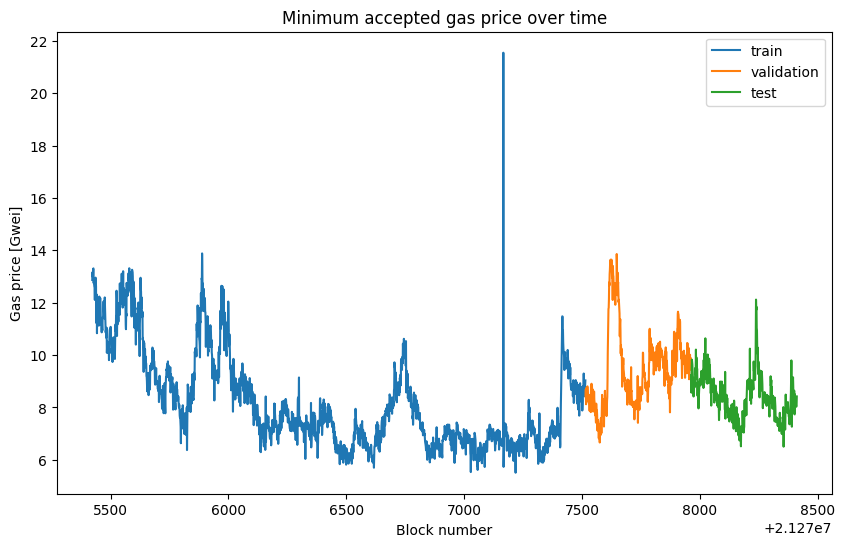

In [68]:
# plot the data (train, validation, test)
plt.figure(figsize=(10, 6))
plt.plot(train_block_numbers, train_data_min_gas_prices, label='train')
plt.plot(validation_block_numbers, validation_data_min_gas_prices, label='validation')
plt.plot(test_block_numbers, test_data_min_gas_prices, label='test')
plt.xlabel('Block number')
plt.ylabel('Gas price [Gwei]')
plt.title('Minimum accepted gas price over time')
plt.legend()
plt.show()

In [6]:
# Custom Dataset Class
class MinimumTimeSeriesDataset:
    def __init__(self, block_gas_prices, seq_length):
        self.block_gas_prices = block_gas_prices
        self.seq_length = seq_length
        self.X, self.y = self._create_sequences()

    def _create_sequences(self):
        X, y = [], []
        for i in range(len(self.block_gas_prices) - self.seq_length):
            # Flatten the sequence and target block
            sequence = np.hstack(self.block_gas_prices[i:i + self.seq_length])
            target = self.block_gas_prices[i + self.seq_length]
            X.append(sequence)
            y.append(target)

        return np.array(X), np.array(y)

    def get_data(self):
        return self.X, self.y

# Custom DataLoader Class
class MinimumTimeSeriesDataLoader(DataLoader):
    def __init__(self, dataset, batch_size, shuffle):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data = self._create_data()
        self.n_batches = len(self.data)

    def _create_data(self):
        data = list(zip(self.dataset.X, self.dataset.y))
        if self.shuffle:
            np.random.shuffle(data)
        return data

    def __iter__(self):
        self.current_batch = 0
        return self

    def __next__(self):
        if self.current_batch >= self.n_batches:
            raise StopIteration
        batch = self.data[self.current_batch:self.current_batch + self.batch_size]
        X, y = zip(*batch)
        self.current_batch += self.batch_size
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return self.n_batches

# Hyperparameters
seq_length = 20
batch_size = 32

# Create the datasets and dataloaders
train_dataset = MinimumTimeSeriesDataset(train_data_min_gas_prices, seq_length)
train_loader = MinimumTimeSeriesDataLoader(train_dataset, batch_size, shuffle=True)
validation_dataset = MinimumTimeSeriesDataset(validation_data_min_gas_prices, seq_length)
validation_loader = MinimumTimeSeriesDataLoader(validation_dataset, batch_size, shuffle=False)
test_dataset = MinimumTimeSeriesDataset(test_data_min_gas_prices, seq_length)
test_loader = MinimumTimeSeriesDataLoader(test_dataset, batch_size, shuffle=False)

### SARIMA

In [13]:
train_plus_val = np.concatenate([train_data_min_gas_prices, validation_data_min_gas_prices])
train_plus_val_block_numbers = np.concatenate([train_block_numbers, validation_block_numbers])

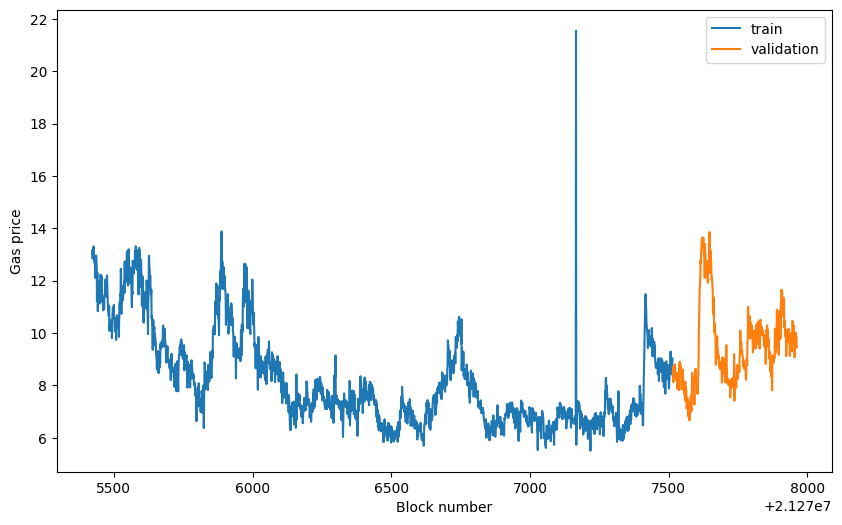

In [14]:
# plot the data (train, validation, test)
plt.figure(figsize=(10, 6))
plt.plot(train_block_numbers, train_data_min_gas_prices, label='train')
plt.plot(validation_block_numbers, validation_data_min_gas_prices, label='validation')
plt.xlabel('Block number')
plt.ylabel('Gas price')
plt.legend()

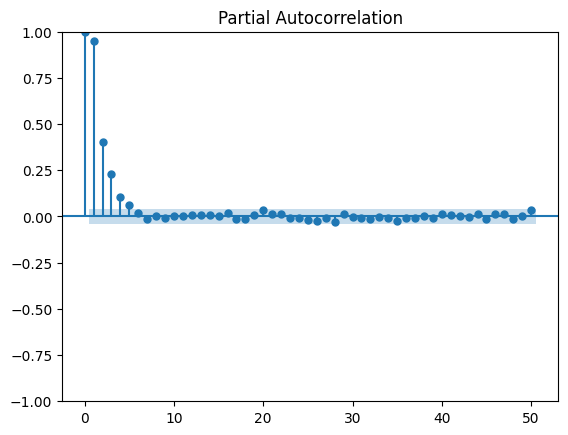

In [15]:
tsaplots.plot_pacf(train_plus_val, lags=50);

Because of the first non-zero term in the PACF, let us try differencing with $d=1$, i.e., define $X_t = Y_t - Y_{t-1}$.

In [16]:
train_plus_val_1_diff = np.diff(train_plus_val, 1)
# drop nan values
train_plus_val_1_diff = train_plus_val_1_diff[1:]

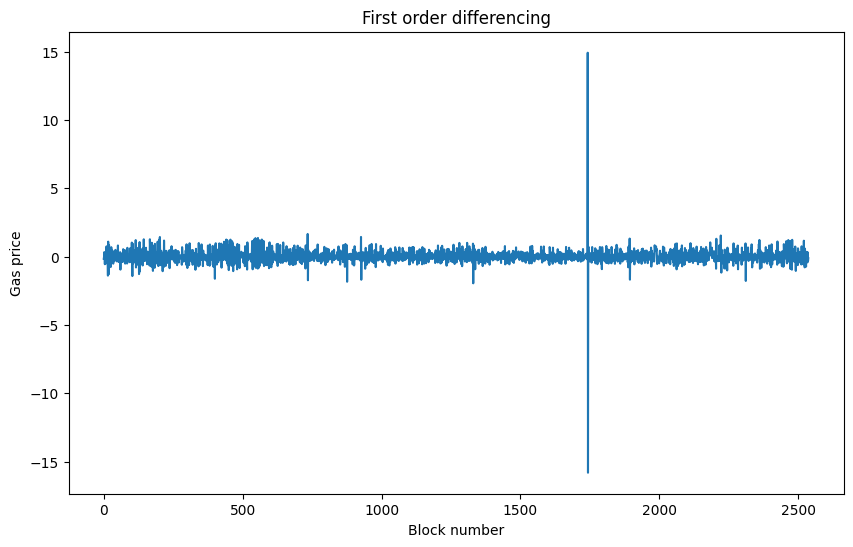

In [17]:
# plot train_plus_val_1_diff
plt.figure(figsize=(10, 6))
plt.plot(train_plus_val_1_diff)
plt.xlabel('Block number')
plt.ylabel('Gas price')
plt.title('First order differencing')
plt.show()

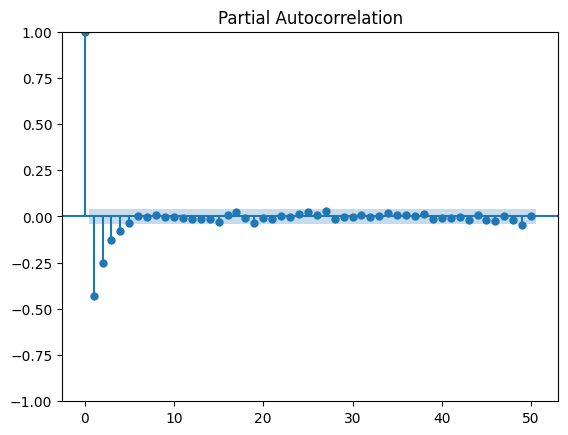

In [18]:
tsaplots.plot_pacf(train_plus_val_1_diff, lags=50);

In [19]:
automatic_sarima_model = auto_arima(train_plus_val, seasonal=False, d=1, D=1,
                                     max_p=5, max_q=5, max_P=5, max_Q=5, error_action='warn', trace=True,
                                        suppress_warnings=True, random_state=42, n_fits=100)

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3726.461, Time=1.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4458.077, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3946.732, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3723.133, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4456.091, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3725.083, Time=0.56 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3725.077, Time=0.62 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3727.120, Time=0.79 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3721.234, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3723.183, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3723.177, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3944.767, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3725.221, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.045 seconds


In [20]:
best_order = automatic_sarima_model.get_params()['order']
best_seasonal_order = automatic_sarima_model.get_params()['seasonal_order']

print(f"Best order: {best_order}")
print(f"Best seasonal order: {best_seasonal_order}")

Best order: (0, 1, 1)
Best seasonal order: (0, 0, 0, 0)


In [21]:
# forecast the next block price (in a loop over the test set)
# we will use all last blocks to predict the next block

import pandas as pd

# Assuming 'train_plus_val' and 'test_data_min_gas_prices' are your data arrays
# Concatenate training, validation, and test data

SARIMA_forecasts = []
Prophet_forecasts = []
for i in range(len(test_data_min_gas_prices)):
    current_train_data = np.concatenate([train_plus_val, test_data_min_gas_prices[:i]])

    automatic_sarima_model = auto_arima(current_train_data, seasonal=False, d=1, D=1,
                                     max_p=5, max_q=5, max_P=5, max_Q=5, error_action='warn', trace=True,
                                        suppress_warnings=True, random_state=42, n_fits=100)
    best_order = automatic_sarima_model.get_params()['order']
    best_seasonal_order = automatic_sarima_model.get_params()['seasonal_order']
    model = SARIMAX(current_train_data, order=best_order, seasonal_order=best_seasonal_order)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=1)
    SARIMA_forecasts.append(forecast)

    prophet_model = Prophet()
    # Create a date range starting from a specific date
    start_date = '2023-01-01'
    date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data

    # Create a DataFrame with the synthetic dates and your data
    df = pd.DataFrame({'ds': date_range, 'y': current_train_data})
    prophet_model.fit(df)
    future = prophet_model.make_future_dataframe(periods=1)
    forecast = prophet_model.predict(future)['yhat'].iloc[-1]
    Prophet_forecasts.append(forecast)

SARIMA_forecasts = np.array(SARIMA_forecasts).flatten()
Prophet_forecasts = np.array(Prophet_forecasts).flatten()

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3726.461, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4458.077, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3946.732, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3723.133, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4456.091, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3725.083, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3725.077, Time=0.60 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3727.120, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3721.234, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3723.183, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3723.177, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3944.767, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3725.221, Time=0.30 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.117 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:03:12 - cmdstanpy - INFO - Chain [1] start processing
14:03:12 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3727.482, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4458.982, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3947.563, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3724.133, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4456.997, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3726.084, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3726.078, Time=0.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3728.121, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3722.243, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3724.194, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3724.188, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3945.602, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3726.231, Time=0.35 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.017 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:03:17 - cmdstanpy - INFO - Chain [1] start processing
14:03:18 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3730.544, Time=1.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4461.025, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3950.186, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3727.606, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4459.046, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3729.558, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3729.553, Time=0.44 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3731.591, Time=0.70 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3725.740, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3727.691, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3727.686, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3948.237, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3729.725, Time=0.36 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.088 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:03:24 - cmdstanpy - INFO - Chain [1] start processing
14:03:24 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3732.179, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4464.377, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3952.291, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3728.814, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4462.391, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3730.763, Time=0.94 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3730.757, Time=0.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3732.799, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3726.936, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3728.885, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3728.879, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3950.332, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3730.921, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.928 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:03:29 - cmdstanpy - INFO - Chain [1] start processing
14:03:29 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3733.947, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4465.444, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3954.749, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3730.585, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4463.455, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3732.553, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3732.549, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3734.554, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3728.692, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3730.659, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3730.655, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3952.780, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3732.142, Time=0.85 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.079 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:03:34 - cmdstanpy - INFO - Chain [1] start processing
14:03:34 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3734.722, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4466.221, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3955.312, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3731.289, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4464.233, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3733.260, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3733.256, Time=0.71 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3735.256, Time=0.70 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3729.389, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3731.360, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3731.356, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3953.342, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3732.843, Time=1.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.468 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:03:40 - cmdstanpy - INFO - Chain [1] start processing
14:03:41 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3735.196, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4467.009, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3955.938, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3731.759, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4465.021, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3733.729, Time=1.54 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3733.726, Time=0.65 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3735.725, Time=0.69 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3729.858, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3731.829, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3731.825, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3953.970, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3733.312, Time=1.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.235 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:03:47 - cmdstanpy - INFO - Chain [1] start processing
14:03:48 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3735.816, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4467.896, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3956.730, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3732.367, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4465.910, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3734.339, Time=0.62 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3734.336, Time=0.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3736.333, Time=0.63 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3730.472, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3732.443, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3732.440, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3954.765, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3733.920, Time=0.86 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.836 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:03:54 - cmdstanpy - INFO - Chain [1] start processing
14:03:54 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3736.956, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4468.904, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3957.815, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3733.474, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4466.920, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3735.449, Time=0.79 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3735.446, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3737.436, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3731.589, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3733.564, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3733.561, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3955.856, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3735.033, Time=0.75 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.631 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:03:59 - cmdstanpy - INFO - Chain [1] start processing
14:04:00 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3738.219, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4469.783, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3958.764, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3734.699, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4467.801, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3736.677, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3736.675, Time=0.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3738.136, Time=1.90 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3732.827, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3734.804, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3734.802, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3956.810, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3736.265, Time=0.80 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.810 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:04:06 - cmdstanpy - INFO - Chain [1] start processing
14:04:07 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3738.689, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4470.676, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3959.376, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3735.168, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4468.692, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3737.146, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3737.144, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3738.605, Time=1.43 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3733.297, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3735.274, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3735.272, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3957.420, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3736.735, Time=0.89 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.101 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:04:12 - cmdstanpy - INFO - Chain [1] start processing
14:04:13 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3740.863, Time=1.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4472.921, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3961.307, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3737.744, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4470.944, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3739.715, Time=0.68 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3739.711, Time=0.44 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3741.709, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3735.894, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3737.864, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3737.860, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3959.361, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3739.352, Time=0.76 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.346 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:04:19 - cmdstanpy - INFO - Chain [1] start processing
14:04:19 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3741.946, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4474.935, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3962.300, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3738.418, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4472.951, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3740.388, Time=0.38 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3740.384, Time=0.44 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3742.385, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3736.561, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3738.530, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3738.527, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3960.348, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3740.027, Time=0.91 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.254 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:04:24 - cmdstanpy - INFO - Chain [1] start processing
14:04:25 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3742.411, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4475.723, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3962.956, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3738.884, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4473.741, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3740.854, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3740.850, Time=0.44 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3742.849, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3737.026, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3738.996, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3738.992, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3961.001, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3740.491, Time=0.72 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.871 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:04:30 - cmdstanpy - INFO - Chain [1] start processing
14:04:30 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3742.907, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4476.485, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3963.507, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3739.366, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4474.502, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3741.336, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3741.333, Time=0.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3743.332, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3737.506, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3739.476, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3739.473, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3961.552, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3740.974, Time=0.76 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.213 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:04:35 - cmdstanpy - INFO - Chain [1] start processing
14:04:36 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3743.127, Time=1.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4477.419, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3964.239, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3739.999, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4475.439, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3741.968, Time=0.57 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3741.965, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3743.968, Time=0.62 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3738.146, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3740.114, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3740.111, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3962.288, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3741.621, Time=0.81 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.114 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:04:41 - cmdstanpy - INFO - Chain [1] start processing
14:04:42 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3743.820, Time=1.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4478.537, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3965.007, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3740.673, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4476.553, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3742.642, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3742.639, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3744.645, Time=0.59 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3738.813, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3740.781, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3740.778, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3963.053, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3742.297, Time=0.93 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.279 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:04:48 - cmdstanpy - INFO - Chain [1] start processing
14:04:48 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3744.306, Time=1.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4479.425, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3965.572, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3741.161, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4477.444, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3743.129, Time=0.63 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3743.126, Time=0.64 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3745.134, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3739.304, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3741.271, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3741.268, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3963.619, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3743.278, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.798 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:04:53 - cmdstanpy - INFO - Chain [1] start processing
14:04:54 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3746.427, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4481.263, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3967.079, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3742.858, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4479.276, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3744.825, Time=0.88 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3744.821, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3746.840, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3740.985, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3742.951, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3742.947, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3965.117, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3744.967, Time=0.31 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.014 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:04:59 - cmdstanpy - INFO - Chain [1] start processing
14:04:59 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3747.225, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4482.017, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3967.821, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3743.663, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4480.030, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3745.633, Time=0.38 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3745.629, Time=0.43 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3747.640, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3741.782, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3743.750, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3743.747, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3965.856, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3745.759, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.465 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:05:03 - cmdstanpy - INFO - Chain [1] start processing
14:05:04 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3747.686, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4482.877, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3968.521, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3744.127, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4480.892, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3746.096, Time=0.38 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3746.093, Time=0.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3748.103, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3742.246, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3744.214, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3744.211, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3966.558, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3746.223, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.448 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:05:08 - cmdstanpy - INFO - Chain [1] start processing
14:05:08 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3751.444, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4486.205, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3971.695, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3747.940, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4484.213, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3749.899, Time=0.57 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3749.895, Time=0.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3751.919, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3746.036, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3747.994, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3747.989, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3969.721, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3750.015, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.300 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:05:13 - cmdstanpy - INFO - Chain [1] start processing
14:05:14 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3751.988, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4488.266, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3972.500, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3748.473, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4486.278, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3750.430, Time=0.74 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3750.426, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3752.452, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3746.571, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3748.528, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3748.523, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3970.530, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3750.063, Time=0.96 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.519 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:05:19 - cmdstanpy - INFO - Chain [1] start processing
14:05:19 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3752.807, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4489.422, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3973.075, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3749.273, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4487.432, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3751.223, Time=0.73 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3751.218, Time=0.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3753.260, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3747.365, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3749.314, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3749.308, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3971.104, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3750.879, Time=0.93 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.753 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:05:25 - cmdstanpy - INFO - Chain [1] start processing
14:05:25 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3753.297, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4490.330, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3973.643, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3749.749, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4488.341, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3751.700, Time=0.74 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3751.694, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3753.736, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3747.842, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3749.792, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3749.786, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3971.673, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3751.359, Time=1.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.833 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:05:31 - cmdstanpy - INFO - Chain [1] start processing
14:05:31 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3755.340, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4492.124, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3975.927, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3751.774, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4490.140, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3753.733, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3753.728, Time=0.63 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3755.749, Time=0.67 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3749.883, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3751.841, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3751.836, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3973.967, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3753.361, Time=1.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.920 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:05:37 - cmdstanpy - INFO - Chain [1] start processing
14:05:38 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3755.802, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4493.348, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3976.553, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3752.241, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4491.361, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3754.199, Time=0.51 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3754.194, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3756.216, Time=0.69 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3750.349, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3752.306, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3752.301, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3974.590, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3753.826, Time=0.92 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.878 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:05:43 - cmdstanpy - INFO - Chain [1] start processing
14:05:44 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3756.715, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4494.454, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3977.212, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3753.120, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4492.470, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3755.074, Time=0.52 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3755.069, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3757.096, Time=0.65 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3751.236, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3753.190, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3753.185, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3975.252, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3754.721, Time=1.16 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.742 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:05:49 - cmdstanpy - INFO - Chain [1] start processing
14:05:50 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3760.151, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4496.623, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3980.321, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3756.643, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4494.646, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3758.599, Time=0.53 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3758.594, Time=0.74 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3760.616, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3754.784, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3756.739, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3756.734, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3978.374, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3758.250, Time=0.96 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.889 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:05:55 - cmdstanpy - INFO - Chain [1] start processing
14:05:56 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3760.611, Time=1.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4498.164, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3981.045, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3757.105, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4496.181, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3759.060, Time=0.70 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3759.055, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3761.078, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3755.245, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3757.201, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3757.195, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3979.095, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3758.712, Time=0.94 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.196 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:06:02 - cmdstanpy - INFO - Chain [1] start processing
14:06:02 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3761.221, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4499.029, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3981.596, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3757.710, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4497.048, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3759.661, Time=0.53 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3759.656, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3761.688, Time=0.84 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3755.857, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3757.807, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3757.802, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3979.645, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3759.335, Time=0.93 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.864 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:06:08 - cmdstanpy - INFO - Chain [1] start processing
14:06:08 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3761.784, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4499.797, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3982.238, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3758.310, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4497.817, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3760.260, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3760.254, Time=0.62 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3762.289, Time=0.64 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3756.463, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3758.411, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3758.405, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3980.290, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3759.937, Time=0.84 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.725 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:06:13 - cmdstanpy - INFO - Chain [1] start processing
14:06:14 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3764.887, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4502.067, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3984.823, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3761.460, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4500.095, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3763.402, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3763.396, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3765.446, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3759.638, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3761.580, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3761.573, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3982.889, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3763.140, Time=1.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.221 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:06:19 - cmdstanpy - INFO - Chain [1] start processing
14:06:19 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3765.453, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4504.003, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3985.757, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3762.019, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4502.024, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3763.961, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3763.954, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3766.006, Time=0.68 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3760.193, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3762.133, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3762.126, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3983.817, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3763.701, Time=0.79 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.615 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:06:24 - cmdstanpy - INFO - Chain [1] start processing
14:06:25 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3765.913, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4504.770, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3986.445, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3762.481, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4502.792, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3764.423, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3764.416, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3766.468, Time=0.61 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3760.654, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3762.595, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3762.588, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3984.502, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3764.161, Time=1.46 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.128 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:06:31 - cmdstanpy - INFO - Chain [1] start processing
14:06:31 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3766.398, Time=2.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4505.708, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3987.169, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3763.213, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4503.727, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3765.158, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3765.151, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3767.201, Time=0.77 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3761.377, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3763.321, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3763.315, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3985.222, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3764.894, Time=0.93 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.228 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:06:38 - cmdstanpy - INFO - Chain [1] start processing
14:06:38 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3767.595, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4506.545, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3988.001, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3764.086, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4504.563, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3766.034, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3766.029, Time=0.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3768.069, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3762.241, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3764.188, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3764.182, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3986.048, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3765.740, Time=0.99 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.467 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:06:44 - cmdstanpy - INFO - Chain [1] start processing
14:06:44 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3768.480, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4507.347, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3988.703, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3764.950, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4505.363, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3766.900, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3766.894, Time=0.66 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3768.933, Time=0.68 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3763.095, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3765.043, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3765.038, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3986.747, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3766.603, Time=1.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.178 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:06:50 - cmdstanpy - INFO - Chain [1] start processing
14:06:50 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3769.115, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4508.097, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3989.274, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3765.584, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4506.114, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3767.533, Time=0.95 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3767.527, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3769.566, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3763.722, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3765.671, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3765.665, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3987.317, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3767.227, Time=0.80 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.886 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:06:56 - cmdstanpy - INFO - Chain [1] start processing
14:06:56 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3769.606, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4508.847, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3989.821, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3766.079, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4506.864, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3768.027, Time=1.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3768.022, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3770.062, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3764.215, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3766.162, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3766.156, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3987.864, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3767.722, Time=1.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.454 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:07:02 - cmdstanpy - INFO - Chain [1] start processing
14:07:03 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3770.174, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4509.731, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3990.550, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3766.637, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4507.749, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3768.587, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3768.582, Time=0.64 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3770.620, Time=0.78 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3764.778, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3766.727, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3766.721, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3988.597, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3768.285, Time=0.89 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.882 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:07:08 - cmdstanpy - INFO - Chain [1] start processing
14:07:09 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3770.680, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4510.479, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3991.131, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3767.135, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4508.497, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3769.087, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3769.081, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3771.117, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3765.279, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3767.230, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3767.224, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3989.180, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3768.783, Time=0.80 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.429 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:07:14 - cmdstanpy - INFO - Chain [1] start processing
14:07:14 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3771.179, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4511.312, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3991.777, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3767.644, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4509.329, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3769.595, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3769.589, Time=0.80 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3771.625, Time=0.61 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3765.784, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3767.734, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3767.729, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3989.823, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3769.287, Time=0.94 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.931 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:07:20 - cmdstanpy - INFO - Chain [1] start processing
14:07:20 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3771.641, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4512.061, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3992.329, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3768.107, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4510.078, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3770.058, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3770.053, Time=0.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3772.089, Time=0.74 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3766.247, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3768.197, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3768.191, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3990.375, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3769.749, Time=0.90 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.930 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:07:26 - cmdstanpy - INFO - Chain [1] start processing
14:07:27 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3772.850, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4513.306, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3993.450, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3769.303, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4511.320, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3771.254, Time=1.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3771.248, Time=0.68 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3773.285, Time=0.89 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3767.430, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3769.380, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3769.374, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3991.489, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3770.934, Time=1.32 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.755 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:07:33 - cmdstanpy - INFO - Chain [1] start processing
14:07:34 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3773.489, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4514.055, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3994.067, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3769.943, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4512.070, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3771.895, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3771.890, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3773.923, Time=0.65 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3768.065, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3770.016, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3770.010, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3992.104, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3771.564, Time=0.82 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.472 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:07:39 - cmdstanpy - INFO - Chain [1] start processing
14:07:39 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3773.951, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4514.885, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3994.732, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3770.408, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4512.901, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3772.360, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3772.355, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3774.388, Time=0.61 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3768.531, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3770.482, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3770.477, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3992.772, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3772.028, Time=1.18 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.913 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:07:45 - cmdstanpy - INFO - Chain [1] start processing
14:07:45 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3774.483, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4515.664, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3995.390, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3770.932, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4513.681, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3772.886, Time=0.70 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3772.881, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3774.912, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3769.059, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3771.012, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3771.007, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3993.432, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3772.556, Time=0.92 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.755 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:07:51 - cmdstanpy - INFO - Chain [1] start processing
14:07:51 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3775.025, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4516.571, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3996.062, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3771.488, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4514.586, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3773.440, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3773.435, Time=0.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3775.468, Time=0.62 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3769.610, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3771.562, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3771.556, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3994.102, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3773.109, Time=0.88 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.630 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:07:57 - cmdstanpy - INFO - Chain [1] start processing
14:07:57 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3775.512, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4517.316, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3996.644, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3771.980, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4515.331, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3773.933, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3773.927, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3775.960, Time=0.63 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3770.099, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3772.051, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3772.046, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3994.682, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3773.596, Time=1.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.866 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:08:03 - cmdstanpy - INFO - Chain [1] start processing
14:08:03 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3776.004, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4518.133, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3997.273, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3772.475, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4516.148, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3774.428, Time=0.68 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3774.423, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3776.455, Time=0.79 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3770.598, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3772.550, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3772.545, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3995.313, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3774.093, Time=0.94 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.923 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:08:09 - cmdstanpy - INFO - Chain [1] start processing
14:08:09 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3776.663, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4519.122, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3997.992, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3773.139, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4517.136, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3775.091, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3775.086, Time=0.60 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3777.119, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3771.256, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3773.207, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3773.201, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3996.029, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3774.752, Time=0.90 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.695 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:08:15 - cmdstanpy - INFO - Chain [1] start processing
14:08:15 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3777.169, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4519.867, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3998.577, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3773.650, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4517.880, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3775.602, Time=0.67 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3775.597, Time=0.70 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3777.629, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3771.763, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3773.715, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3773.709, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3996.613, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3775.258, Time=0.90 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.624 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:08:21 - cmdstanpy - INFO - Chain [1] start processing
14:08:22 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3779.102, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4521.998, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4000.846, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3775.605, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4520.018, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3777.558, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3777.553, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3779.581, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3773.735, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3775.688, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3775.682, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3998.892, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3777.220, Time=0.90 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.396 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:08:27 - cmdstanpy - INFO - Chain [1] start processing
14:08:27 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3781.555, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4526.138, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4003.583, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3778.087, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4524.149, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3780.027, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3780.021, Time=0.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3782.072, Time=0.74 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3776.198, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3778.137, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3778.131, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4001.617, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3779.705, Time=0.92 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.207 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:08:33 - cmdstanpy - INFO - Chain [1] start processing
14:08:34 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3782.013, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4527.284, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4004.154, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3778.550, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4525.298, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3780.491, Time=0.49 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3780.485, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3782.534, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3776.660, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3778.600, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3778.594, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4002.188, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3780.164, Time=1.31 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.084 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:08:40 - cmdstanpy - INFO - Chain [1] start processing
14:08:40 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3784.197, Time=1.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4529.140, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4005.446, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3780.616, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4527.149, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3782.552, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3782.544, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3784.609, Time=0.81 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3778.710, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3780.645, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3780.637, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4003.474, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3782.703, Time=0.42 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.000 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:08:46 - cmdstanpy - INFO - Chain [1] start processing
14:08:47 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3784.651, Time=1.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4530.265, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4006.022, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3781.071, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4528.277, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3783.007, Time=0.56 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3783.000, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3785.064, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3779.165, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3781.100, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3781.092, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4004.050, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3783.158, Time=0.30 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.348 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:08:51 - cmdstanpy - INFO - Chain [1] start processing
14:08:52 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3785.474, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4531.270, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4006.637, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3781.887, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4529.280, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3783.817, Time=0.88 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3783.809, Time=0.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3785.884, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3779.974, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3781.902, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3781.895, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4004.664, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3783.971, Time=0.31 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.173 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:08:57 - cmdstanpy - INFO - Chain [1] start processing
14:08:57 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3785.942, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4532.042, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4007.181, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3782.365, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4530.052, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3784.294, Time=0.62 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3784.286, Time=0.66 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3786.361, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3780.450, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3782.378, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3782.370, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4005.208, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3784.446, Time=0.29 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.420 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:09:02 - cmdstanpy - INFO - Chain [1] start processing
14:09:03 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3786.530, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4532.935, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4007.979, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3783.431, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4530.947, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3784.879, Time=0.49 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3784.871, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3786.941, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3781.036, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3782.967, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3782.959, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4006.009, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3785.031, Time=0.33 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.639 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:09:07 - cmdstanpy - INFO - Chain [1] start processing
14:09:08 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3789.961, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4536.533, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4011.364, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3786.450, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4534.538, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3788.368, Time=1.00 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3788.359, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3789.998, Time=1.70 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3784.520, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3786.437, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3786.428, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4009.383, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3788.515, Time=0.31 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.753 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:09:14 - cmdstanpy - INFO - Chain [1] start processing
14:09:14 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3794.876, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4544.492, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4016.619, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3791.309, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4542.508, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3793.202, Time=0.53 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3793.191, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3795.307, Time=0.63 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3789.403, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3791.295, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3791.283, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4014.653, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3793.401, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.672 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:09:19 - cmdstanpy - INFO - Chain [1] start processing
14:09:19 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3795.356, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4546.037, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4017.244, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3791.796, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4544.050, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3793.695, Time=0.81 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3793.684, Time=0.69 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3795.793, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3789.892, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3791.790, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3791.778, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4015.280, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3793.889, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.250 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:09:24 - cmdstanpy - INFO - Chain [1] start processing
14:09:24 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3795.894, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4546.794, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4017.885, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3792.298, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4544.806, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3794.196, Time=0.79 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3794.185, Time=0.63 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3796.297, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3790.397, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3792.293, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3792.282, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4015.918, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3794.395, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.164 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:09:29 - cmdstanpy - INFO - Chain [1] start processing
14:09:30 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3796.889, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4547.849, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4018.867, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3793.344, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4545.864, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3795.238, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3795.227, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3797.341, Time=0.71 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3791.453, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3793.345, Time=0.62 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3793.334, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4016.905, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3795.449, Time=0.46 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.500 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:09:35 - cmdstanpy - INFO - Chain [1] start processing
14:09:35 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3797.884, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4548.661, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4019.713, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3794.352, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4546.678, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3796.246, Time=0.54 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3796.235, Time=0.75 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3798.350, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3792.470, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3794.363, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3794.351, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4017.756, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3796.468, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.472 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:09:40 - cmdstanpy - INFO - Chain [1] start processing
14:09:41 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3798.830, Time=1.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4549.462, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4020.402, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3795.299, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4547.480, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3797.190, Time=0.76 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3797.178, Time=0.74 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3799.296, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3793.426, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3795.317, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3795.305, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4018.448, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3797.424, Time=0.30 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.221 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:09:47 - cmdstanpy - INFO - Chain [1] start processing
14:09:47 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3799.538, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4550.806, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4021.498, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3795.993, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4548.820, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3797.888, Time=1.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3797.876, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3799.989, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3794.114, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3796.008, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3795.996, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4019.537, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3798.111, Time=0.39 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.964 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:09:53 - cmdstanpy - INFO - Chain [1] start processing
14:09:53 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3799.995, Time=1.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4551.592, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4022.059, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3796.450, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4549.607, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3798.345, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3798.334, Time=0.63 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3800.445, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3794.570, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3796.464, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3796.453, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4020.097, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3798.566, Time=0.35 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.686 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:09:59 - cmdstanpy - INFO - Chain [1] start processing
14:09:59 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3800.837, Time=1.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4552.690, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4023.169, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3797.339, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4550.707, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3799.232, Time=0.72 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3799.220, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3801.334, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3795.468, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3797.360, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3797.348, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4021.214, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3799.464, Time=0.30 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.707 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:10:04 - cmdstanpy - INFO - Chain [1] start processing
14:10:05 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3804.690, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4557.136, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4027.124, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3801.195, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4555.145, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3803.081, Time=0.78 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3803.068, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3805.189, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3799.300, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3801.185, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3801.172, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4025.155, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3803.294, Time=0.44 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.460 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:10:10 - cmdstanpy - INFO - Chain [1] start processing
14:10:11 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3805.495, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4558.047, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4027.881, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3802.001, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4556.058, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3803.899, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3803.888, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3805.991, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3800.098, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3801.995, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3801.984, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4025.909, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3803.637, Time=0.78 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.159 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:10:16 - cmdstanpy - INFO - Chain [1] start processing
14:10:16 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3806.061, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4558.794, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4028.480, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3802.540, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4556.805, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3804.436, Time=0.60 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3804.425, Time=0.60 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3806.531, Time=0.59 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3800.634, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3802.529, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3802.517, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4026.510, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3804.626, Time=0.39 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.019 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:10:21 - cmdstanpy - INFO - Chain [1] start processing
14:10:21 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3807.931, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4560.854, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4030.688, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3804.336, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4558.870, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3806.242, Time=0.74 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3806.232, Time=0.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3808.327, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3802.444, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3804.349, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3804.339, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4028.727, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3806.004, Time=0.85 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.766 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:10:27 - cmdstanpy - INFO - Chain [1] start processing
14:10:27 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3808.456, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4562.294, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4031.371, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3804.877, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4560.306, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3806.778, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3806.768, Time=0.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3808.871, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3802.982, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3804.882, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3804.872, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4029.407, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3806.976, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.809 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:10:32 - cmdstanpy - INFO - Chain [1] start processing
14:10:32 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3810.149, Time=1.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4564.208, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4032.553, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3806.497, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4562.226, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3808.392, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3808.380, Time=0.72 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3810.494, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3804.616, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3806.510, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3806.498, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4030.595, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3808.614, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.404 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:10:37 - cmdstanpy - INFO - Chain [1] start processing
14:10:38 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3812.109, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4567.464, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4034.632, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3808.414, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4565.475, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3810.298, Time=0.61 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3810.286, Time=0.44 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3812.414, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3806.518, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3808.401, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3808.389, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4032.665, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3810.518, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.790 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:10:42 - cmdstanpy - INFO - Chain [1] start processing
14:10:42 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3812.699, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4568.285, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4035.374, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3809.012, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4566.297, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3810.903, Time=0.63 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3810.892, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3813.011, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3807.110, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3809.001, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3808.989, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4033.404, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3811.110, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.938 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:10:47 - cmdstanpy - INFO - Chain [1] start processing
14:10:48 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3813.480, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4569.552, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4036.782, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3809.845, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4567.566, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3811.738, Time=0.71 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3811.726, Time=0.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3813.844, Time=0.61 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3807.952, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3809.843, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3809.832, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4034.818, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3811.951, Time=0.36 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.251 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:10:52 - cmdstanpy - INFO - Chain [1] start processing
14:10:53 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3814.019, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4570.629, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4037.409, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3810.395, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4568.641, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3812.284, Time=0.72 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3812.273, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3814.394, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3808.498, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3810.386, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3810.374, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4035.443, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3812.497, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.947 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:10:57 - cmdstanpy - INFO - Chain [1] start processing
14:10:58 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3814.732, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4571.709, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4038.083, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3811.088, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4569.724, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3812.976, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3812.964, Time=0.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3815.087, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3809.198, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3811.084, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3811.072, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4036.120, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3813.196, Time=0.23 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.957 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:11:02 - cmdstanpy - INFO - Chain [1] start processing
14:11:03 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3815.649, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4572.578, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4039.068, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3812.020, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4570.594, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3813.911, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3813.899, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3816.018, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3810.138, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3812.028, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3812.016, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4037.110, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3814.137, Time=0.29 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.672 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:11:07 - cmdstanpy - INFO - Chain [1] start processing
14:11:08 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3816.783, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4573.448, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4039.924, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3813.130, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4571.466, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3815.023, Time=0.73 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3815.011, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3817.127, Time=0.61 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3811.260, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3813.151, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3813.140, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4037.970, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3815.257, Time=0.20 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.667 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:11:13 - cmdstanpy - INFO - Chain [1] start processing
14:11:14 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3818.482, Time=5.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4574.505, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4041.086, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3814.826, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4572.526, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3816.718, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3816.706, Time=0.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3818.824, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3812.972, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3814.862, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3814.850, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4039.139, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3816.970, Time=0.30 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 9.140 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:11:24 - cmdstanpy - INFO - Chain [1] start processing
14:11:24 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3818.936, Time=1.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4575.504, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4041.711, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3815.282, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4573.523, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3817.173, Time=1.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3817.162, Time=1.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3819.279, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3813.428, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3815.318, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3815.307, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4039.762, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3817.426, Time=0.22 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 7.161 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:11:32 - cmdstanpy - INFO - Chain [1] start processing
14:11:33 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3821.746, Time=1.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4577.967, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4043.717, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3818.134, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4575.993, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3820.002, Time=1.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3819.988, Time=2.40 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3822.134, Time=1.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3816.304, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3818.170, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3818.156, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4041.779, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3820.304, Time=0.21 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 7.888 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:11:41 - cmdstanpy - INFO - Chain [1] start processing
14:11:42 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3823.507, Time=1.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4581.718, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4045.936, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3819.824, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4579.735, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3821.688, Time=0.66 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3821.674, Time=0.86 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3823.824, Time=0.62 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3817.977, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3819.840, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3819.825, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4043.986, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3821.977, Time=0.30 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.058 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:11:47 - cmdstanpy - INFO - Chain [1] start processing
14:11:48 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3824.190, Time=1.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4582.482, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4046.923, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3820.504, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4580.499, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3822.382, Time=1.95 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3822.370, Time=1.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3824.503, Time=0.93 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3818.651, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3820.527, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3820.514, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4044.967, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3822.649, Time=0.30 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 7.509 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:11:56 - cmdstanpy - INFO - Chain [1] start processing
14:11:57 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3824.665, Time=1.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4583.406, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4047.752, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3821.004, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4581.426, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3822.880, Time=1.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3822.867, Time=0.62 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3825.002, Time=0.81 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3819.153, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3821.028, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3821.015, Time=0.39 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4045.801, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3823.152, Time=0.31 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.411 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:12:04 - cmdstanpy - INFO - Chain [1] start processing
14:12:05 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3825.162, Time=1.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4584.239, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4048.307, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3821.504, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4582.257, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3823.380, Time=0.71 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3823.367, Time=0.60 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3825.503, Time=0.96 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3819.651, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3821.525, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3821.511, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4046.355, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3823.649, Time=0.30 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.654 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:12:12 - cmdstanpy - INFO - Chain [1] start processing
14:12:12 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3825.894, Time=1.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4585.294, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4049.072, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3822.225, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4583.315, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3824.100, Time=2.54 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3824.087, Time=2.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3826.223, Time=1.66 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3820.379, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3822.252, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3822.239, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4047.124, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3824.378, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 9.593 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:12:22 - cmdstanpy - INFO - Chain [1] start processing
14:12:23 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3826.348, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4586.079, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4049.611, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3822.680, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4584.098, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3824.555, Time=0.53 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3824.542, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3826.678, Time=0.75 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3820.836, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3822.709, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3822.696, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4047.663, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3824.834, Time=0.34 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.495 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:12:28 - cmdstanpy - INFO - Chain [1] start processing
14:12:29 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3827.018, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4587.020, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4050.499, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3823.362, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4585.037, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3825.238, Time=0.53 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3825.225, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3827.360, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3821.510, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3823.385, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3823.372, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4048.546, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3825.509, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.316 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:12:34 - cmdstanpy - INFO - Chain [1] start processing
14:12:34 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3827.530, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4587.980, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4051.128, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3823.882, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4586.000, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3825.756, Time=0.57 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3825.743, Time=0.68 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3827.880, Time=0.87 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3822.034, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3823.907, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3823.893, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4049.179, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3826.032, Time=0.23 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.838 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:12:39 - cmdstanpy - INFO - Chain [1] start processing
14:12:40 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3828.000, Time=1.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4588.783, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4051.668, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3824.350, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4586.801, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3826.224, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3826.211, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3828.348, Time=0.59 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3822.500, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3824.373, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3824.359, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4049.717, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3826.499, Time=0.32 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.582 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:12:45 - cmdstanpy - INFO - Chain [1] start processing
14:12:46 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3828.831, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4589.751, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4052.622, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3825.197, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4587.767, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3827.072, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3827.059, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3829.195, Time=0.68 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3823.338, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3825.211, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3825.198, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4050.667, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3827.336, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.087 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:12:51 - cmdstanpy - INFO - Chain [1] start processing
14:12:51 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3829.420, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4590.908, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4053.396, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3825.793, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4588.927, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3827.666, Time=0.60 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3827.653, Time=0.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3829.791, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3823.939, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3825.811, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3825.797, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4051.444, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3827.938, Time=0.36 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.246 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:12:56 - cmdstanpy - INFO - Chain [1] start processing
14:12:56 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3830.040, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4591.678, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4054.177, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3826.416, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4589.698, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3828.293, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3828.280, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3830.413, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3824.569, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3826.445, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3826.431, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4052.230, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3828.567, Time=0.23 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.931 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:13:01 - cmdstanpy - INFO - Chain [1] start processing
14:13:01 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3831.814, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4593.007, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4055.580, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3828.139, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4591.032, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3830.020, Time=0.57 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3830.007, Time=0.75 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3832.136, Time=0.59 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3826.310, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3828.189, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3828.176, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4053.641, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3830.307, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.417 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:13:06 - cmdstanpy - INFO - Chain [1] start processing
14:13:07 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3832.668, Time=1.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4594.997, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4056.877, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3829.000, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4593.016, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3830.877, Time=0.61 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3830.864, Time=0.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3832.998, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3827.161, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3829.036, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3829.023, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4054.930, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3831.159, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.639 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:13:12 - cmdstanpy - INFO - Chain [1] start processing
14:13:13 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3833.594, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4596.579, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4057.646, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3829.926, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4594.602, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3831.791, Time=0.57 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3831.777, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3833.925, Time=0.72 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3828.098, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3829.961, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3829.947, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4055.704, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3832.097, Time=0.31 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.455 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:13:18 - cmdstanpy - INFO - Chain [1] start processing
14:13:19 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3834.082, Time=1.96 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4597.339, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4058.260, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3830.430, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4595.361, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3832.296, Time=0.60 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3832.282, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3834.429, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3828.606, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3830.470, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3830.456, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4056.321, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3832.605, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.389 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:13:25 - cmdstanpy - INFO - Chain [1] start processing
14:13:25 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3834.580, Time=1.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4598.184, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4058.977, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3830.936, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4596.205, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3832.803, Time=0.94 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3832.789, Time=0.90 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3834.934, Time=0.72 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3829.108, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3830.974, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3830.959, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4057.034, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3833.107, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.081 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:13:32 - cmdstanpy - INFO - Chain [1] start processing
14:13:32 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3835.443, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4599.102, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4059.900, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3831.777, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4597.120, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3833.650, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3833.636, Time=0.70 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3835.776, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3829.939, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3831.810, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3831.796, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4057.951, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3833.938, Time=0.33 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.154 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:13:37 - cmdstanpy - INFO - Chain [1] start processing
14:13:38 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3836.083, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4599.843, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4060.501, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3832.404, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4597.862, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3834.279, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3834.266, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3836.402, Time=0.64 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3830.560, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3832.433, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3832.420, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4058.550, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3834.558, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.294 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:13:43 - cmdstanpy - INFO - Chain [1] start processing
14:13:43 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3837.099, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4601.340, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4061.918, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3833.433, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4599.364, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3835.309, Time=0.58 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3835.296, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3837.430, Time=0.61 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3831.601, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3833.475, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3833.462, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4059.975, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3835.598, Time=0.53 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.642 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:13:48 - cmdstanpy - INFO - Chain [1] start processing
14:13:49 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3837.556, Time=1.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4602.313, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4062.466, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3833.895, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4600.334, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3835.769, Time=1.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3835.756, Time=1.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3837.892, Time=1.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3832.061, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3833.934, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3833.920, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4060.522, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3836.058, Time=0.48 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.504 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:13:56 - cmdstanpy - INFO - Chain [1] start processing
14:13:57 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3838.024, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4603.079, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4063.002, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3834.356, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4601.100, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3836.231, Time=0.51 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3836.217, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3838.354, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3832.525, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3834.397, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3834.384, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4061.057, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3836.522, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.521 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:14:02 - cmdstanpy - INFO - Chain [1] start processing
14:14:03 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3838.470, Time=0.98 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4603.817, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4063.537, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3834.804, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4601.839, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3836.679, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3836.665, Time=0.72 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3838.802, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3832.973, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3834.846, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3834.832, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4061.593, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3836.971, Time=0.35 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.528 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:14:08 - cmdstanpy - INFO - Chain [1] start processing
14:14:09 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3839.004, Time=1.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4604.611, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4064.132, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3835.338, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4602.634, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3837.212, Time=0.52 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3837.199, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3839.336, Time=0.67 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3833.512, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3835.384, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3835.371, Time=0.44 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4062.190, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3837.510, Time=0.37 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.035 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:14:14 - cmdstanpy - INFO - Chain [1] start processing
14:14:15 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3840.081, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4605.641, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4065.172, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3836.420, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4603.667, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3838.294, Time=0.85 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3838.281, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3840.417, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3834.607, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3836.479, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3836.466, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4063.237, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3838.604, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.991 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:14:21 - cmdstanpy - INFO - Chain [1] start processing
14:14:21 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3840.556, Time=1.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4606.441, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4065.704, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3836.894, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4604.466, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3838.769, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3838.756, Time=0.69 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3840.891, Time=0.65 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3835.084, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3836.957, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3836.944, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4063.770, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3839.081, Time=0.35 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.052 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:14:27 - cmdstanpy - INFO - Chain [1] start processing
14:14:28 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3841.077, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4607.283, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4066.466, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3837.416, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4605.306, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3839.294, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3839.281, Time=0.67 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3841.413, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3835.602, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3837.477, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3837.464, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4064.527, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3839.599, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.172 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:14:32 - cmdstanpy - INFO - Chain [1] start processing
14:14:33 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3841.523, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4608.035, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4066.998, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3837.862, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4606.058, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3839.739, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3839.726, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3841.858, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3836.047, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3837.922, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3837.909, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4065.058, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3840.044, Time=0.29 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.825 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:14:37 - cmdstanpy - INFO - Chain [1] start processing
14:14:38 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3842.049, Time=1.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4608.843, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4067.656, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3838.397, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4606.868, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3840.274, Time=0.68 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3840.261, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3842.394, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3836.588, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3838.463, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3838.449, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4065.720, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3840.585, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.835 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:14:43 - cmdstanpy - INFO - Chain [1] start processing
14:14:44 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3842.735, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4609.654, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4068.373, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3839.082, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4607.681, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3840.960, Time=0.61 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3840.947, Time=0.60 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3843.079, Time=0.84 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3837.281, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3839.157, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3839.144, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4066.442, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3841.279, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.912 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:14:50 - cmdstanpy - INFO - Chain [1] start processing
14:14:50 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3843.181, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4610.478, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4068.944, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3839.530, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4608.503, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3841.407, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3841.395, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3843.527, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3837.728, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3839.603, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3839.590, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4067.010, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3841.725, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.599 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:14:55 - cmdstanpy - INFO - Chain [1] start processing
14:14:56 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3843.665, Time=1.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4611.255, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4069.481, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3840.015, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4609.282, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3841.891, Time=1.00 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3841.879, Time=0.59 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3844.012, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3838.217, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3840.091, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3840.078, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4067.549, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3842.215, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.928 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:15:01 - cmdstanpy - INFO - Chain [1] start processing
14:15:02 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3845.529, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4612.876, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4071.314, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3841.914, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4610.908, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3843.789, Time=0.52 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3843.776, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3845.911, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3840.138, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3842.010, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3841.997, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4069.393, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3844.135, Time=0.34 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.796 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:15:06 - cmdstanpy - INFO - Chain [1] start processing
14:15:07 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3845.972, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4613.977, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4071.893, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3842.358, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4612.006, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3844.233, Time=0.56 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3844.219, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3846.354, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3840.581, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3842.454, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3842.440, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4069.970, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3844.578, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.934 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:15:12 - cmdstanpy - INFO - Chain [1] start processing
14:15:12 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3848.009, Time=1.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4615.911, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4074.678, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3844.412, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4613.933, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3846.302, Time=0.66 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3846.290, Time=0.77 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3848.403, Time=0.69 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3842.613, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3844.501, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3844.489, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4072.740, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3846.605, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.431 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:15:18 - cmdstanpy - INFO - Chain [1] start processing
14:15:18 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3848.614, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4617.676, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4075.572, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3845.050, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4615.704, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3846.933, Time=0.52 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3846.920, Time=0.66 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3849.043, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3843.259, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3845.140, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3845.127, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4073.639, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3847.253, Time=0.29 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.218 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:15:23 - cmdstanpy - INFO - Chain [1] start processing
14:15:24 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3849.934, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4619.429, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4076.503, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3846.325, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4617.450, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3848.199, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3848.186, Time=0.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3850.321, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3844.519, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3846.390, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3846.376, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4074.565, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3848.515, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.066 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:15:29 - cmdstanpy - INFO - Chain [1] start processing
14:15:29 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3852.667, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4620.930, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4079.138, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3849.140, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4618.947, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3851.024, Time=0.65 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3851.012, Time=0.61 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3853.127, Time=0.64 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3847.307, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3849.190, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3849.177, Time=0.39 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4077.186, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3851.296, Time=0.39 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.501 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:15:34 - cmdstanpy - INFO - Chain [1] start processing
14:15:35 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3853.165, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4622.004, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4079.720, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3849.629, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4620.024, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3851.514, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3851.502, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3853.617, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3847.793, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3849.677, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3849.664, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4077.770, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3851.782, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.810 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:15:39 - cmdstanpy - INFO - Chain [1] start processing
14:15:40 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3853.681, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4622.755, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4080.267, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3850.148, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4620.775, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3852.030, Time=0.53 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3852.017, Time=0.69 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3854.138, Time=0.62 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3848.308, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3850.187, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3850.175, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4078.318, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3852.299, Time=0.30 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.211 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:15:45 - cmdstanpy - INFO - Chain [1] start processing
14:15:45 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3854.507, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4623.677, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4081.091, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3851.029, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4621.694, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3852.903, Time=0.71 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3852.890, Time=0.85 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3855.020, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3849.178, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3851.051, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3851.037, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4079.138, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3853.170, Time=0.22 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.485 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:15:51 - cmdstanpy - INFO - Chain [1] start processing
14:15:51 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3855.391, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4625.205, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4082.229, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3851.892, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4623.227, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3853.769, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3853.756, Time=1.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3855.883, Time=1.72 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3850.052, Time=0.66 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3851.927, Time=1.40 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3851.914, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4080.283, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3854.044, Time=0.71 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 8.371 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:16:01 - cmdstanpy - INFO - Chain [1] start processing
14:16:01 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3855.950, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4625.939, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4082.905, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3852.444, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4623.961, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3854.327, Time=0.58 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3854.314, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3856.433, Time=0.69 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3850.610, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3852.490, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3852.477, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4080.962, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3854.599, Time=0.45 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.415 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:16:06 - cmdstanpy - INFO - Chain [1] start processing
14:16:07 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3856.856, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4626.828, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4083.609, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3853.306, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4624.852, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3855.190, Time=1.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3855.178, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3857.294, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3851.481, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3853.364, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3853.352, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4081.670, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3855.470, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.292 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:16:12 - cmdstanpy - INFO - Chain [1] start processing
14:16:12 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3858.533, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4629.207, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4085.659, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3854.981, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4627.224, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3856.863, Time=0.68 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3856.850, Time=0.60 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3858.971, Time=0.67 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3853.140, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3855.019, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3855.007, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4083.709, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3857.130, Time=0.29 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.281 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:16:18 - cmdstanpy - INFO - Chain [1] start processing
14:16:18 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3859.800, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4631.743, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4086.955, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3856.255, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4629.768, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3858.122, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3858.108, Time=0.79 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3860.250, Time=0.68 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3854.428, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3856.293, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3856.278, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4085.013, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3858.423, Time=0.30 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.276 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:16:23 - cmdstanpy - INFO - Chain [1] start processing
14:16:24 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3860.362, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4632.493, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4087.730, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3856.839, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4630.517, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3858.711, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3858.697, Time=0.76 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3860.832, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3855.018, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3856.888, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3856.874, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4085.792, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3859.011, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.163 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:16:29 - cmdstanpy - INFO - Chain [1] start processing
14:16:29 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3861.496, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4634.107, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4089.472, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3858.034, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4632.126, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3859.908, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3859.894, Time=0.70 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3862.022, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3856.200, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3858.071, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3858.057, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4087.524, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3860.188, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.094 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:16:34 - cmdstanpy - INFO - Chain [1] start processing
14:16:35 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3862.308, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4634.846, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4090.282, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3858.823, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4632.864, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3860.704, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3860.692, Time=0.90 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3862.810, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3856.980, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3858.859, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3858.846, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4088.330, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3860.967, Time=0.33 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.258 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:16:40 - cmdstanpy - INFO - Chain [1] start processing
14:16:41 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3862.784, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4635.811, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4091.058, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3859.312, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4633.831, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3861.192, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3861.180, Time=0.99 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3863.299, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3857.471, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3859.350, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3859.337, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4089.110, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3861.459, Time=0.33 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.591 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:16:46 - cmdstanpy - INFO - Chain [1] start processing
14:16:47 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3863.225, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4636.550, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4091.603, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3859.753, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4634.570, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3861.634, Time=0.53 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3861.621, Time=1.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3863.740, Time=0.66 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3857.913, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3859.792, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3859.779, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4089.656, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3861.901, Time=0.36 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.863 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:16:52 - cmdstanpy - INFO - Chain [1] start processing
14:16:53 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3863.860, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4637.405, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4092.251, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3860.370, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4635.427, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3862.252, Time=0.66 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3862.240, Time=0.64 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3864.358, Time=1.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3858.537, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3860.417, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3860.405, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4090.308, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3862.526, Time=0.33 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.118 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:16:59 - cmdstanpy - INFO - Chain [1] start processing
14:16:59 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3864.375, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4638.137, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4092.816, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3860.884, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4636.159, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3862.767, Time=0.52 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3862.755, Time=0.59 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3864.871, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3859.055, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3860.937, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3860.924, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4090.874, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3863.043, Time=0.35 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.159 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:17:04 - cmdstanpy - INFO - Chain [1] start processing
14:17:05 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3864.862, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4638.979, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4093.469, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3861.376, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4636.999, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3863.259, Time=0.58 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3863.246, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3865.362, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3859.543, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3861.425, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3861.412, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4091.525, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3863.531, Time=0.30 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.904 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:17:09 - cmdstanpy - INFO - Chain [1] start processing
14:17:10 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3865.692, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4640.146, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4094.325, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3862.215, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4638.171, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3864.095, Time=0.55 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3864.082, Time=0.67 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3866.203, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3860.394, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3862.271, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3862.258, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4092.385, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3864.382, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.887 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:17:14 - cmdstanpy - INFO - Chain [1] start processing
14:17:15 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3866.197, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4640.884, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4094.899, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3862.726, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4638.908, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3864.607, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3864.594, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3866.714, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3860.909, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3862.788, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3862.775, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4092.962, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3864.897, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.915 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:17:20 - cmdstanpy - INFO - Chain [1] start processing
14:17:20 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3866.635, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4641.630, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4095.459, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3863.165, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4639.654, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3865.046, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3865.033, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3867.152, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3861.348, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3863.227, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3863.214, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4093.520, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3865.336, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.924 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:17:25 - cmdstanpy - INFO - Chain [1] start processing
14:17:25 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3867.810, Time=1.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4642.925, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4096.578, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3864.364, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4640.953, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3866.240, Time=0.70 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3866.226, Time=0.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3868.352, Time=0.59 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3862.561, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3864.435, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3864.422, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4094.647, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3866.550, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.497 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:17:31 - cmdstanpy - INFO - Chain [1] start processing
14:17:32 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3874.099, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4650.000, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4103.018, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3870.612, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4648.013, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3872.479, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3872.464, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3874.603, Time=0.67 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3868.770, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3870.635, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3870.621, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4101.064, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3872.762, Time=0.51 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.278 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:17:37 - cmdstanpy - INFO - Chain [1] start processing
14:17:37 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3879.325, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4660.332, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4108.521, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3875.864, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4658.364, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3877.658, Time=0.69 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3877.636, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3879.864, Time=1.00 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3874.059, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3875.850, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3875.828, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4106.588, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3878.058, Time=0.32 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.692 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:17:43 - cmdstanpy - INFO - Chain [1] start processing
14:17:43 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3879.824, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4661.792, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4109.340, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3876.385, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4659.818, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3878.191, Time=0.78 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3878.171, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3880.385, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3874.585, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3876.388, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3876.367, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4107.412, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3878.585, Time=0.30 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.887 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:17:48 - cmdstanpy - INFO - Chain [1] start processing
14:17:48 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3880.265, Time=1.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4662.561, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4110.243, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3876.829, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4660.586, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3878.635, Time=0.95 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3878.615, Time=0.95 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3880.829, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3875.028, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3876.832, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3876.811, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4108.309, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3879.028, Time=0.43 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.367 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:17:54 - cmdstanpy - INFO - Chain [1] start processing
14:17:55 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3880.763, Time=0.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4663.316, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4110.833, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3877.309, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4661.340, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3879.117, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3879.097, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3881.309, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3875.505, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3877.310, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3877.290, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4108.897, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3879.504, Time=0.23 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.999 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:17:59 - cmdstanpy - INFO - Chain [1] start processing
14:18:00 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3881.454, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4664.154, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4111.542, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3877.987, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4662.176, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3879.799, Time=0.61 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3879.779, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3881.986, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3876.174, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3877.984, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3877.963, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4109.602, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3880.174, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.668 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:18:04 - cmdstanpy - INFO - Chain [1] start processing
14:18:04 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3882.057, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4664.896, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4112.136, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3878.579, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4662.918, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3880.393, Time=0.66 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3880.374, Time=0.68 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3882.579, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3876.760, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3878.572, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3878.552, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4110.193, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3880.760, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.806 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:18:09 - cmdstanpy - INFO - Chain [1] start processing
14:18:09 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3882.504, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4665.706, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4112.732, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3879.028, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4663.729, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3880.842, Time=0.55 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3880.823, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3883.028, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3877.211, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3879.023, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3879.003, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4110.792, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3881.211, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.625 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:18:14 - cmdstanpy - INFO - Chain [1] start processing
14:18:14 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3883.084, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4666.512, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4113.445, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3879.603, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4664.537, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3881.420, Time=0.69 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3881.401, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3883.603, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3877.792, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3879.607, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3879.587, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4111.509, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3881.792, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.641 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:18:18 - cmdstanpy - INFO - Chain [1] start processing
14:18:19 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3883.548, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4667.359, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4114.032, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3880.074, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4665.381, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3881.890, Time=0.66 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3881.870, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3884.074, Time=0.46 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3878.260, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3880.073, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3880.054, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4112.093, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3882.260, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.758 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:18:23 - cmdstanpy - INFO - Chain [1] start processing
14:18:24 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3884.147, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4668.276, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4114.657, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3880.669, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4666.301, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3882.483, Time=0.62 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3882.464, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3884.669, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3878.862, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3880.674, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3880.654, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4112.721, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3882.862, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.626 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:18:28 - cmdstanpy - INFO - Chain [1] start processing
14:18:28 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3884.731, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4669.027, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4115.312, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3881.259, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4667.053, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3883.075, Time=0.61 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3883.056, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3885.259, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3879.459, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3881.273, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3881.253, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4113.380, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3883.459, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.527 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:18:32 - cmdstanpy - INFO - Chain [1] start processing
14:18:33 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3885.663, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4669.922, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4116.102, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3882.178, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4667.951, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3883.994, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3883.975, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3886.178, Time=0.46 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3880.390, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3882.203, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3882.184, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4114.175, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3884.390, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.337 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:18:37 - cmdstanpy - INFO - Chain [1] start processing
14:18:37 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3886.100, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4670.758, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4116.654, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3882.617, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4668.784, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3884.433, Time=0.49 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3884.413, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3886.617, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3880.830, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3882.643, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3882.623, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4114.726, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3884.830, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.407 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:18:41 - cmdstanpy - INFO - Chain [1] start processing
14:18:42 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3887.107, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4671.901, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4117.489, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3883.631, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4669.933, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3885.439, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3885.419, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3887.631, Time=0.46 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3881.858, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3883.662, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3883.642, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4115.567, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3885.857, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.408 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:18:46 - cmdstanpy - INFO - Chain [1] start processing
14:18:46 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3887.638, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4673.028, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4118.166, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3884.152, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4671.055, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3885.959, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3885.939, Time=0.62 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3888.152, Time=0.45 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3882.373, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3884.178, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3884.157, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4116.239, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3886.373, Time=0.36 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.684 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:18:50 - cmdstanpy - INFO - Chain [1] start processing
14:18:51 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3888.083, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4673.763, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4118.741, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3884.597, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4671.790, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3886.406, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3886.386, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3888.597, Time=0.45 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3882.817, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3884.623, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3884.602, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4116.812, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3886.817, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.261 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:18:55 - cmdstanpy - INFO - Chain [1] start processing
14:18:55 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3888.722, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4674.704, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4119.557, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3885.264, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4672.734, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3887.071, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3887.050, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3889.264, Time=0.44 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3883.493, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3885.296, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3885.275, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4117.635, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3887.493, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.383 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:18:59 - cmdstanpy - INFO - Chain [1] start processing
14:19:00 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3889.600, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4675.544, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4120.428, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3886.141, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4673.577, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3887.950, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3887.930, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3890.141, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3884.382, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3886.188, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3886.167, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4118.512, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3888.382, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.436 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:19:04 - cmdstanpy - INFO - Chain [1] start processing
14:19:04 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3890.053, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4676.479, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4121.068, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3886.597, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4674.508, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3888.406, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3888.385, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3890.597, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3884.836, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3886.641, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3886.621, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4119.148, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3888.836, Time=0.30 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.558 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:19:08 - cmdstanpy - INFO - Chain [1] start processing
14:19:09 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3890.516, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4677.256, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4121.592, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3887.063, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4675.287, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3888.870, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3888.849, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3891.063, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3885.305, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3887.109, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3887.088, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4119.672, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3889.305, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.345 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:19:13 - cmdstanpy - INFO - Chain [1] start processing
14:19:13 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3890.973, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4678.024, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4122.127, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3887.515, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4676.054, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3889.322, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3889.301, Time=0.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3891.515, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3885.755, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3887.558, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3887.538, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4120.206, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3889.755, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.599 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:19:18 - cmdstanpy - INFO - Chain [1] start processing
14:19:18 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3891.407, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4678.756, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4122.650, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3887.950, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4676.786, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3889.757, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3889.736, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3891.950, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3886.190, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3887.994, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3887.973, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4120.728, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3890.190, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.413 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:19:22 - cmdstanpy - INFO - Chain [1] start processing
14:19:22 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3891.882, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4679.518, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4123.226, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3888.430, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4677.549, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3890.236, Time=0.58 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3890.216, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3892.429, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3886.674, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3888.477, Time=0.86 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3888.456, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4121.307, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3890.674, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.329 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:19:27 - cmdstanpy - INFO - Chain [1] start processing
14:19:28 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3892.379, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4680.351, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4123.821, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3888.928, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4678.380, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3890.734, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3890.714, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3892.928, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3887.168, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3888.970, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3888.949, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4121.899, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3891.167, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.412 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:19:32 - cmdstanpy - INFO - Chain [1] start processing
14:19:32 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3893.168, Time=0.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4681.229, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4124.685, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3889.718, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4679.256, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3891.527, Time=0.61 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3891.507, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3893.718, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3887.947, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3889.752, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3889.732, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4122.758, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3891.946, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.013 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:19:37 - cmdstanpy - INFO - Chain [1] start processing
14:19:37 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3893.818, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4682.461, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4125.568, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3890.380, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4680.492, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3892.186, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3892.166, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3894.379, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3888.617, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3890.421, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3890.400, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4123.646, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3892.617, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.387 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:19:41 - cmdstanpy - INFO - Chain [1] start processing
14:19:42 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3894.946, Time=1.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4684.107, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4126.611, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3891.509, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4682.132, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3893.305, Time=0.64 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3893.284, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3895.508, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3889.731, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3891.525, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3891.503, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4124.682, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3893.730, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.304 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:19:47 - cmdstanpy - INFO - Chain [1] start processing
14:19:47 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3895.463, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4684.856, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4127.216, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3892.037, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4682.883, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3893.837, Time=0.65 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3893.815, Time=0.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3896.036, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3890.254, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3892.050, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3892.029, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4125.284, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3894.253, Time=0.22 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.903 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:19:52 - cmdstanpy - INFO - Chain [1] start processing
14:19:52 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3895.898, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4685.598, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4127.780, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3892.471, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4683.625, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3894.271, Time=0.81 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3894.250, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3896.471, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3890.688, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3892.484, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3892.463, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4125.850, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3894.687, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.975 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:19:57 - cmdstanpy - INFO - Chain [1] start processing
14:19:57 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3897.419, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4687.140, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4129.423, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3893.955, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4685.173, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3895.762, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3895.742, Time=0.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3897.954, Time=0.64 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3892.190, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3893.994, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3893.974, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4127.505, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3896.190, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.803 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:20:02 - cmdstanpy - INFO - Chain [1] start processing
14:20:02 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3898.075, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4687.880, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4130.033, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3894.595, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4685.912, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3896.409, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3896.389, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3898.595, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3892.839, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3894.650, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3894.630, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4128.118, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3896.839, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.406 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:20:06 - cmdstanpy - INFO - Chain [1] start processing
14:20:06 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3899.566, Time=0.98 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4689.892, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4132.280, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3896.130, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4687.917, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3897.947, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3897.928, Time=0.63 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3900.130, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3894.355, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3896.169, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3896.150, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4130.351, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3898.355, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.920 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:20:11 - cmdstanpy - INFO - Chain [1] start processing
14:20:11 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3900.042, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4690.749, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4132.820, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3896.597, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4688.777, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3898.419, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3898.400, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3900.597, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3894.819, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3896.637, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3896.618, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4130.889, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3898.819, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.608 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:20:16 - cmdstanpy - INFO - Chain [1] start processing
14:20:16 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3900.581, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4691.638, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4133.724, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3897.158, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4689.668, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3898.981, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3898.962, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3901.158, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3895.387, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3897.206, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3897.187, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4131.800, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3899.387, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.885 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:20:21 - cmdstanpy - INFO - Chain [1] start processing
14:20:21 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3901.086, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4692.364, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4134.299, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3897.654, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4690.395, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3899.479, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3899.460, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3901.654, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3895.887, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3897.709, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3897.690, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4132.378, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3899.887, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.535 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:20:25 - cmdstanpy - INFO - Chain [1] start processing
14:20:26 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3902.797, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4693.792, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4135.717, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3899.334, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4691.828, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3901.160, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3901.142, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3903.333, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3897.588, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3899.411, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3899.393, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4133.806, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3901.588, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.500 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:20:30 - cmdstanpy - INFO - Chain [1] start processing
14:20:30 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3903.918, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4696.151, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4137.268, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3900.460, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4694.178, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3902.280, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3902.261, Time=0.62 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3904.460, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3898.699, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3900.516, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3900.497, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4135.346, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3902.699, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.526 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:20:34 - cmdstanpy - INFO - Chain [1] start processing
14:20:35 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3905.727, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4697.233, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4139.412, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3902.273, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4695.257, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3904.117, Time=0.63 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3904.101, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3906.272, Time=0.46 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3900.490, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3902.332, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3902.315, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4137.476, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3904.490, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.500 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:20:39 - cmdstanpy - INFO - Chain [1] start processing
14:20:40 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3906.208, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4698.147, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4139.968, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3902.736, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4696.173, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3904.582, Time=0.65 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3904.566, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3906.735, Time=0.46 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3900.951, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3902.794, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3902.777, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4138.035, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3904.950, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.792 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:20:44 - cmdstanpy - INFO - Chain [1] start processing
14:20:44 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3906.703, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4698.968, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4140.792, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3903.234, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4696.996, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3905.082, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3905.066, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3907.233, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3901.453, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3903.299, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3903.282, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4138.865, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3905.452, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.527 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:20:48 - cmdstanpy - INFO - Chain [1] start processing
14:20:49 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3907.143, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4699.696, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4141.316, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3903.670, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4697.724, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3905.519, Time=0.76 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3905.503, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3907.669, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3901.891, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3903.737, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3903.721, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4139.389, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3905.890, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.950 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:20:54 - cmdstanpy - INFO - Chain [1] start processing
14:20:54 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3907.574, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4700.420, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4141.837, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3904.101, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4698.448, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3905.950, Time=0.53 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3905.934, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3908.100, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3902.322, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3904.168, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3904.152, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4139.910, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3906.321, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.413 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:20:58 - cmdstanpy - INFO - Chain [1] start processing
14:20:59 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3908.360, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4701.402, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4142.659, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3904.886, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4699.433, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3906.736, Time=0.57 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3906.720, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3908.884, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3903.118, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3904.965, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3904.949, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4140.737, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3907.117, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.569 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:21:03 - cmdstanpy - INFO - Chain [1] start processing
14:21:03 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3909.401, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4702.265, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4143.609, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3905.922, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4700.299, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3907.776, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3907.761, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3909.920, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3904.169, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3906.020, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3906.005, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4141.695, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3908.167, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.527 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:21:07 - cmdstanpy - INFO - Chain [1] start processing
14:21:08 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3910.321, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4703.030, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4144.292, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3906.828, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4701.066, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3908.683, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3908.668, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3910.826, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3905.088, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3906.940, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3906.924, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4142.383, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3909.086, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.458 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:21:12 - cmdstanpy - INFO - Chain [1] start processing
14:21:12 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3911.258, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4703.828, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4144.970, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3907.769, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4701.865, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3909.621, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3909.606, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3911.768, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3906.043, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3907.892, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3907.876, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4143.065, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3910.042, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.466 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:21:16 - cmdstanpy - INFO - Chain [1] start processing
14:21:17 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3912.723, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4706.052, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4146.994, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3909.209, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4704.081, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3911.067, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3911.052, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3913.207, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3907.463, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3909.318, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3909.303, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4145.076, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3911.462, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.478 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:21:21 - cmdstanpy - INFO - Chain [1] start processing
14:21:21 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3914.265, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4706.926, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4148.546, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3910.705, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4704.953, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3912.585, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3912.572, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3914.698, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3908.940, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3910.817, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3910.805, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4146.617, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3912.934, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.490 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:21:25 - cmdstanpy - INFO - Chain [1] start processing
14:21:25 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3914.694, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4707.983, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4149.269, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3911.140, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4706.013, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3913.019, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3913.006, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3915.133, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3909.376, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3911.253, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3911.240, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4147.345, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3913.370, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.517 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:21:29 - cmdstanpy - INFO - Chain [1] start processing
14:21:30 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3915.159, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4708.746, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4149.788, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3911.607, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4706.775, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3913.484, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3913.471, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3915.600, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3909.840, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3911.714, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3911.701, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4147.864, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3913.834, Time=0.23 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.529 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:21:34 - cmdstanpy - INFO - Chain [1] start processing
14:21:35 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3915.702, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4709.602, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4150.400, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3912.133, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4707.633, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3914.011, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3913.999, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3916.126, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3910.372, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3912.248, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3912.235, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4148.480, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3914.367, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.506 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:21:39 - cmdstanpy - INFO - Chain [1] start processing
14:21:39 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3916.166, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4710.323, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4150.948, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3912.596, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4708.354, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3914.476, Time=0.53 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3914.463, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3916.589, Time=0.46 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3910.839, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3912.716, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3912.703, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4149.029, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3914.832, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.501 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:21:43 - cmdstanpy - INFO - Chain [1] start processing
14:21:43 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3916.652, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4711.143, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4151.584, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3913.090, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4709.172, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3914.969, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3914.956, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3917.083, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3911.328, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3913.205, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3913.192, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4149.661, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3915.322, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.417 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:21:47 - cmdstanpy - INFO - Chain [1] start processing
14:21:48 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3917.147, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4711.990, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4152.158, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3913.587, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4710.021, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3915.465, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3915.453, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3917.580, Time=0.44 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3911.830, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3913.706, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3913.693, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4150.239, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3915.824, Time=0.29 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.539 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:21:52 - cmdstanpy - INFO - Chain [1] start processing
14:21:52 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3919.074, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4713.577, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4154.117, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3915.528, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4711.615, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3917.411, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3917.398, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3919.521, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3913.796, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3915.675, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3915.662, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4152.211, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3917.789, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.302 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:21:56 - cmdstanpy - INFO - Chain [1] start processing
14:21:57 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3919.536, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4714.511, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4154.637, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3915.987, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4712.546, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3917.871, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3917.859, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3919.980, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3914.258, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3916.139, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3916.126, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4152.730, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3918.251, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.471 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:22:01 - cmdstanpy - INFO - Chain [1] start processing
14:22:02 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3920.627, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4715.599, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4155.355, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3917.062, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4713.638, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3918.938, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3918.925, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3921.057, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3915.349, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3917.222, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3917.208, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4153.454, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3919.345, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.425 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:22:06 - cmdstanpy - INFO - Chain [1] start processing
14:22:06 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3921.873, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4717.667, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4156.864, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3918.261, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4715.698, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3920.138, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3920.125, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3922.257, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3916.530, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3918.405, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3918.392, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4154.951, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3920.527, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.476 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:22:10 - cmdstanpy - INFO - Chain [1] start processing
14:22:11 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3922.327, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4718.477, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4157.426, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3918.713, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4716.510, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3920.593, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3920.581, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3922.708, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3916.980, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3918.857, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3918.844, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4155.511, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3920.976, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.461 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:22:15 - cmdstanpy - INFO - Chain [1] start processing
14:22:15 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3922.865, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4719.359, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4158.289, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3919.280, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4717.395, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3921.160, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3921.147, Time=0.73 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3923.275, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3917.554, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3919.431, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3919.418, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4156.380, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3921.550, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.633 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:22:19 - cmdstanpy - INFO - Chain [1] start processing
14:22:20 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3924.550, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4720.673, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4159.899, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3920.937, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4718.715, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3922.823, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3922.811, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3924.934, Time=0.64 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3919.234, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3921.117, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3921.104, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4158.003, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3923.232, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.527 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:22:24 - cmdstanpy - INFO - Chain [1] start processing
14:22:24 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3925.051, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4721.500, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4160.413, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3921.432, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4719.540, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3923.319, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3923.307, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3925.428, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3919.735, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3921.619, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3921.607, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4158.517, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3923.731, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.553 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:22:29 - cmdstanpy - INFO - Chain [1] start processing
14:22:29 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3925.476, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4722.236, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4161.019, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3921.858, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4720.275, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3923.745, Time=0.54 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3923.734, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3925.854, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3920.161, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3922.045, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3922.033, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4159.119, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3924.158, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.524 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:22:33 - cmdstanpy - INFO - Chain [1] start processing
14:22:34 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3926.080, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4723.105, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4161.667, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3922.485, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4721.147, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3924.369, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3924.357, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3926.481, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3920.798, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3922.678, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3922.665, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4159.772, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3924.794, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.460 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:22:38 - cmdstanpy - INFO - Chain [1] start processing
14:22:38 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3926.542, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4723.825, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4162.198, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3922.955, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4721.866, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3924.838, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3924.826, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3926.951, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3921.272, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3923.151, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3923.139, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4160.305, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3925.268, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.558 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:22:42 - cmdstanpy - INFO - Chain [1] start processing
14:22:43 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3927.150, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4724.767, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4163.008, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3923.562, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4722.804, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3925.447, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3925.435, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3927.557, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3921.870, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3923.752, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3923.740, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4161.108, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3925.866, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.364 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:22:47 - cmdstanpy - INFO - Chain [1] start processing
14:22:47 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3928.292, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4726.401, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4164.217, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3924.729, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4724.446, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3926.606, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3926.594, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3928.726, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3923.056, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3924.930, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3924.916, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4162.328, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3927.053, Time=0.36 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.556 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:22:51 - cmdstanpy - INFO - Chain [1] start processing
14:22:52 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3929.793, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4728.850, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4165.732, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3926.204, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4726.885, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3928.074, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3928.060, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3930.202, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3924.509, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3926.376, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3926.362, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4163.830, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3928.508, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.414 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:22:56 - cmdstanpy - INFO - Chain [1] start processing
14:22:56 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3930.632, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4729.571, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4166.717, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3927.059, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4727.605, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3928.939, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3928.926, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3931.055, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3925.350, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3927.227, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3927.214, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4164.807, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3929.348, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.445 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:23:00 - cmdstanpy - INFO - Chain [1] start processing
14:23:01 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3931.077, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4730.342, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4167.283, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3927.495, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4728.378, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3929.375, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3929.363, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3931.492, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3925.785, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3927.661, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3927.649, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4165.376, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3929.782, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.400 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:23:05 - cmdstanpy - INFO - Chain [1] start processing
14:23:05 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3931.510, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4731.060, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4167.799, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3927.932, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4729.096, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3929.811, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3929.798, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3931.928, Time=0.59 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3926.219, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3928.095, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3928.082, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4165.892, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3930.216, Time=0.31 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.563 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:23:09 - cmdstanpy - INFO - Chain [1] start processing
14:23:10 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3931.996, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4731.807, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4168.355, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3928.427, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4729.842, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3930.305, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3930.292, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3932.424, Time=0.63 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3926.709, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3928.584, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3928.571, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4166.447, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3930.707, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.617 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:23:14 - cmdstanpy - INFO - Chain [1] start processing
14:23:15 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3932.503, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4732.666, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4168.978, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3928.930, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4730.703, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3930.808, Time=0.56 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3930.796, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3932.927, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3927.218, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3929.093, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3929.080, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4167.073, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3931.216, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.557 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:23:19 - cmdstanpy - INFO - Chain [1] start processing
14:23:19 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3935.063, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4735.366, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4171.395, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3931.506, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4733.394, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3933.374, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3933.360, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3935.505, Time=0.75 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3929.765, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3931.630, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3931.616, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4169.475, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3933.765, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.747 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:23:24 - cmdstanpy - INFO - Chain [1] start processing
14:23:24 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3935.513, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4736.423, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4171.906, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3931.959, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4734.455, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3933.830, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3933.816, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3935.959, Time=0.71 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3930.215, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3932.082, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3932.068, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4169.986, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3934.215, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.727 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:23:29 - cmdstanpy - INFO - Chain [1] start processing
14:23:29 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3936.217, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4737.455, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4173.230, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3932.686, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4735.491, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3934.562, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3934.549, Time=0.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3936.684, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3930.953, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3932.826, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3932.813, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4171.320, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3934.952, Time=0.30 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.596 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:23:34 - cmdstanpy - INFO - Chain [1] start processing
14:23:34 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3936.752, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4738.171, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4173.803, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3933.198, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4736.207, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3935.079, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3935.066, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3937.197, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3931.471, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3933.349, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3933.336, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4171.895, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3935.470, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.649 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:23:38 - cmdstanpy - INFO - Chain [1] start processing
14:23:39 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3937.186, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4738.891, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4174.320, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3933.629, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4736.926, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3935.509, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3935.497, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3937.627, Time=0.68 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3931.904, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3933.781, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3933.769, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4172.412, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3935.902, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.537 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:23:43 - cmdstanpy - INFO - Chain [1] start processing
14:23:44 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3937.832, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4739.739, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4174.967, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3934.276, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4737.777, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3936.156, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3936.143, Time=0.62 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3938.274, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3932.561, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3934.437, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3934.424, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4173.063, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3936.559, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.604 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:23:48 - cmdstanpy - INFO - Chain [1] start processing
14:23:49 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3938.257, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4740.536, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4175.496, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3934.701, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4738.572, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3936.581, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3936.568, Time=0.62 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3938.700, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3932.985, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3934.861, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3934.849, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4173.591, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3936.984, Time=0.33 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.926 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:23:53 - cmdstanpy - INFO - Chain [1] start processing
14:23:54 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3938.706, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4741.264, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4176.077, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3935.152, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4739.299, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3937.033, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3937.020, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3939.150, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3933.433, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3935.310, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3935.297, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4174.169, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3937.431, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.626 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:23:58 - cmdstanpy - INFO - Chain [1] start processing
14:23:58 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3942.867, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4744.448, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4179.820, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3939.252, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4742.472, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3941.140, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3941.129, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3943.249, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3937.495, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3939.380, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3939.369, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4177.892, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3941.493, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.564 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:24:03 - cmdstanpy - INFO - Chain [1] start processing
14:24:03 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3945.179, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4745.210, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4181.312, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3941.530, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4743.233, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3943.437, Time=0.58 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3943.428, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3945.522, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3939.748, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3941.652, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3941.642, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4179.374, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3943.740, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.728 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:24:08 - cmdstanpy - INFO - Chain [1] start processing
14:24:08 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3945.768, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4747.041, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4182.959, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3942.142, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4745.071, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3944.051, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3944.042, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3946.132, Time=0.64 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3940.368, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3942.274, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3942.264, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4181.032, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3944.359, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.637 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:24:12 - cmdstanpy - INFO - Chain [1] start processing
14:24:13 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3946.513, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4748.298, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4183.566, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3942.926, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4746.323, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3944.822, Time=0.60 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3944.811, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3946.918, Time=0.75 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3941.141, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3943.034, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3943.023, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4181.635, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3945.134, Time=0.29 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.937 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:24:17 - cmdstanpy - INFO - Chain [1] start processing
14:24:18 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3947.081, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4749.017, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4184.263, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3943.536, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4747.042, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3945.431, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3945.420, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3947.529, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3941.743, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3943.636, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3943.624, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4182.329, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3945.737, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.542 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:24:22 - cmdstanpy - INFO - Chain [1] start processing
14:24:23 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3947.707, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4750.102, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4185.181, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3944.164, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4748.130, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3946.061, Time=0.66 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3946.050, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3948.154, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3942.379, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3944.274, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3944.263, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4183.252, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3946.371, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.763 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:24:27 - cmdstanpy - INFO - Chain [1] start processing
14:24:28 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3948.782, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4751.702, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4186.257, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3945.270, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4749.725, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3947.157, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3947.146, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3949.264, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3943.471, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3945.356, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3945.344, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4184.321, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3947.466, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.483 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:24:32 - cmdstanpy - INFO - Chain [1] start processing
14:24:32 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3949.213, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4752.510, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4186.777, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3945.706, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4750.535, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3947.594, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3947.583, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3949.700, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3943.906, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3945.791, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3945.779, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4184.840, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3947.900, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.762 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:24:37 - cmdstanpy - INFO - Chain [1] start processing
14:24:37 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3950.300, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4753.829, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4188.302, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3946.815, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4751.858, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3948.709, Time=0.75 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3948.697, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3950.807, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3945.029, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3946.920, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3946.909, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4186.375, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3949.022, Time=0.38 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.833 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:24:41 - cmdstanpy - INFO - Chain [1] start processing
14:24:42 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3951.224, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4755.641, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4189.436, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3947.775, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4753.664, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3949.660, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3949.647, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3951.768, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3945.976, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3947.859, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3947.846, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4187.501, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3949.970, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.493 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:24:46 - cmdstanpy - INFO - Chain [1] start processing
14:24:46 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3952.677, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4756.630, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4191.114, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3949.262, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4754.650, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3951.156, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3951.145, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3953.252, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3947.446, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3949.338, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3949.326, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4189.170, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3951.437, Time=0.30 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.639 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:24:51 - cmdstanpy - INFO - Chain [1] start processing
14:24:51 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3954.615, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4757.617, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4192.312, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3951.130, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4755.635, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3953.029, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3953.018, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3955.121, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3949.295, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3951.192, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3951.181, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4190.360, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3953.286, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.723 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:24:56 - cmdstanpy - INFO - Chain [1] start processing
14:24:56 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3955.246, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4758.372, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4192.821, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3951.759, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4756.391, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3953.657, Time=0.53 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3953.647, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3955.750, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3949.917, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3951.813, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3951.802, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4190.868, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3953.908, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.435 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:25:00 - cmdstanpy - INFO - Chain [1] start processing
14:25:01 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3956.299, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4759.305, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4193.507, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3952.832, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4757.321, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3954.721, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3954.709, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3956.825, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3950.977, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3952.864, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3952.852, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4191.551, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3954.971, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.527 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:25:05 - cmdstanpy - INFO - Chain [1] start processing
14:25:05 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3956.722, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4760.122, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4194.032, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3953.260, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4758.140, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3955.149, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3955.137, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3957.254, Time=0.62 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3951.405, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3953.291, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3953.279, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4192.078, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3955.399, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.850 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:25:10 - cmdstanpy - INFO - Chain [1] start processing
14:25:10 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3957.244, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4760.893, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4194.553, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3953.793, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4758.910, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3955.677, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3955.665, Time=0.68 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3957.789, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3951.933, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3953.815, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3953.803, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4192.597, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3955.929, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.697 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:25:15 - cmdstanpy - INFO - Chain [1] start processing
14:25:15 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3957.669, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4761.648, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4195.072, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3954.215, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4759.666, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3956.100, Time=0.51 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3956.087, Time=0.67 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3958.211, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3952.356, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3954.238, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3954.226, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4193.118, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3956.351, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.786 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:25:20 - cmdstanpy - INFO - Chain [1] start processing
14:25:20 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3958.186, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4762.416, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4195.711, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3954.727, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4760.435, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3956.613, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3956.601, Time=0.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3958.721, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3952.872, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3954.757, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3954.744, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4193.759, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3956.866, Time=0.29 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.714 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:25:24 - cmdstanpy - INFO - Chain [1] start processing
14:25:25 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3958.636, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4763.229, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4196.275, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3955.184, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4761.246, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3957.070, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3957.057, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3959.178, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3953.326, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3955.210, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3955.198, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4194.322, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3957.321, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.434 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:25:29 - cmdstanpy - INFO - Chain [1] start processing
14:25:30 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3959.274, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4764.038, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4197.032, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3955.831, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4762.054, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3957.717, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3957.705, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3959.825, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3953.966, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3955.851, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3955.839, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4195.075, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3957.961, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.924 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:25:34 - cmdstanpy - INFO - Chain [1] start processing
14:25:35 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3959.728, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4764.917, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4197.630, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3956.289, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4762.935, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3958.175, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3958.163, Time=0.71 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3960.284, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3954.428, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3956.312, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3956.299, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4195.676, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3958.423, Time=0.29 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.014 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:25:39 - cmdstanpy - INFO - Chain [1] start processing
14:25:40 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3960.163, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4765.671, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4198.137, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3956.724, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4763.688, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3958.609, Time=0.56 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3958.597, Time=0.82 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3960.719, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3954.861, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3956.744, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3956.732, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4196.182, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3958.856, Time=0.29 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.050 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:25:44 - cmdstanpy - INFO - Chain [1] start processing
14:25:45 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3960.910, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4766.681, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4198.898, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3957.456, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4764.701, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3959.340, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3959.328, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3961.451, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3955.600, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3957.483, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3957.471, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4196.947, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3959.596, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.765 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:25:49 - cmdstanpy - INFO - Chain [1] start processing
14:25:50 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3969.712, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4775.127, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4207.353, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3966.250, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4773.135, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3968.117, Time=0.60 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3968.103, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3970.249, Time=0.65 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3964.356, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3966.222, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3966.208, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4205.381, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3968.355, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.519 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:25:55 - cmdstanpy - INFO - Chain [1] start processing
14:25:56 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3975.502, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4787.734, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4214.079, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3972.049, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4785.757, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3973.844, Time=0.54 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3973.823, Time=0.66 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3976.041, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3970.186, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3971.979, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3971.958, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4212.125, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3972.905, Time=1.37 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.040 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:26:01 - cmdstanpy - INFO - Chain [1] start processing
14:26:02 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3976.144, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4788.972, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4215.308, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3972.724, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4786.992, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3974.546, Time=0.74 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3974.527, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3976.722, Time=0.94 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3970.868, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3972.688, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3972.669, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4213.362, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3974.866, Time=0.38 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.291 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:26:07 - cmdstanpy - INFO - Chain [1] start processing
14:26:07 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3978.134, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4790.245, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4216.048, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3974.482, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4788.268, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3976.300, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3976.281, Time=0.74 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3978.470, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3972.643, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3974.459, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3974.441, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4214.106, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3975.447, Time=0.86 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.952 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:26:13 - cmdstanpy - INFO - Chain [1] start processing
14:26:14 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3978.630, Time=1.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4791.591, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4216.831, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3974.966, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4789.610, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3976.784, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3976.766, Time=0.85 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3978.952, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3973.124, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3974.940, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3974.921, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4214.884, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3975.922, Time=0.90 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.227 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:26:19 - cmdstanpy - INFO - Chain [1] start processing
14:26:20 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3980.071, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4793.318, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4217.878, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3976.426, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4791.343, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3978.223, Time=0.92 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3978.203, Time=0.92 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3980.397, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3974.600, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3976.394, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3976.374, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4215.938, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3978.569, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.394 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:26:25 - cmdstanpy - INFO - Chain [1] start processing
14:26:25 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3981.688, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4796.062, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4219.591, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3977.971, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4794.079, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3979.765, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3979.745, Time=0.76 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3981.927, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3976.128, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3977.920, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3977.900, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4217.641, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3978.909, Time=0.80 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.272 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:26:30 - cmdstanpy - INFO - Chain [1] start processing
14:26:31 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3982.760, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4796.803, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4220.843, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3979.034, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4794.819, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3980.849, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3980.830, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3983.013, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3977.179, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3978.992, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3978.974, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4218.886, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3981.158, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.665 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:26:35 - cmdstanpy - INFO - Chain [1] start processing
14:26:36 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3983.925, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4798.921, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4222.878, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3980.279, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4796.943, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3982.089, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3982.070, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3984.262, Time=0.62 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3978.438, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3980.246, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3980.226, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4220.931, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3981.227, Time=0.79 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.331 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:26:40 - cmdstanpy - INFO - Chain [1] start processing
14:26:41 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3984.605, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4800.449, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4223.573, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3980.969, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4798.466, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3982.770, Time=0.80 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3982.750, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3984.952, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3979.121, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3980.919, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3980.899, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4221.623, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3981.903, Time=0.81 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.532 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:47 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3985.027, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4801.240, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4224.097, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3981.391, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4799.258, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3983.190, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3983.171, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3985.373, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3979.543, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3981.340, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3981.320, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4222.145, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3982.324, Time=0.79 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.463 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:26:52 - cmdstanpy - INFO - Chain [1] start processing
14:26:52 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3985.450, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4801.956, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4224.610, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3981.813, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4799.975, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3983.613, Time=0.54 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3983.593, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3985.795, Time=0.59 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3979.965, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3981.762, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3981.742, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4222.660, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3982.745, Time=0.85 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.550 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:26:57 - cmdstanpy - INFO - Chain [1] start processing
14:26:58 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3985.870, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4802.670, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4225.118, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3982.234, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4800.689, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3984.034, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3984.014, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3986.217, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3980.385, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3982.183, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3982.163, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4223.167, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3983.166, Time=1.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.614 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:27:03 - cmdstanpy - INFO - Chain [1] start processing
14:27:03 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3986.519, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4803.542, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4225.822, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3982.885, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4801.558, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3984.684, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3984.664, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3986.867, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3981.029, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3982.826, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3982.806, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4223.868, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3983.807, Time=0.95 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.504 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:27:09 - cmdstanpy - INFO - Chain [1] start processing
14:27:09 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3986.941, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4804.339, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4226.346, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3983.308, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4802.358, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3985.107, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3985.087, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3987.289, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3981.453, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3983.250, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3983.229, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4224.392, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3984.230, Time=0.81 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.431 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:27:14 - cmdstanpy - INFO - Chain [1] start processing
14:27:14 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3987.432, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4805.095, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4226.987, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3983.802, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4803.114, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3985.602, Time=0.58 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3985.582, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3987.784, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3981.951, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3983.749, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3983.729, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4225.037, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3984.731, Time=0.83 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.296 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:27:19 - cmdstanpy - INFO - Chain [1] start processing
14:27:20 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3991.857, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4809.329, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4231.421, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3988.283, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4807.340, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3990.072, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3990.051, Time=0.86 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3992.265, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3986.404, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3988.191, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3988.170, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4229.456, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3989.148, Time=0.70 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.627 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:27:25 - cmdstanpy - INFO - Chain [1] start processing
14:27:26 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3992.465, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4810.448, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4231.966, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3988.888, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4808.461, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3990.687, Time=0.71 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3990.666, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3992.873, Time=0.76 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3987.003, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3988.800, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3988.780, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4229.999, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3989.763, Time=0.80 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.539 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:27:31 - cmdstanpy - INFO - Chain [1] start processing
14:27:31 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3993.025, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4811.168, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4232.516, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3989.428, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4809.181, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3991.222, Time=0.80 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3991.201, Time=0.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3993.411, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3987.539, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3989.331, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3989.310, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4230.551, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3990.293, Time=0.78 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.452 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:27:36 - cmdstanpy - INFO - Chain [1] start processing
14:27:37 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3993.462, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4811.948, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4233.082, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3989.857, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4809.962, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3991.651, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3991.631, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3993.839, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3987.969, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3989.762, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3989.741, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4231.118, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3990.727, Time=0.89 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.103 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:27:42 - cmdstanpy - INFO - Chain [1] start processing
14:27:42 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3994.036, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4812.828, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4233.697, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3990.451, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4810.840, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3992.240, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3992.218, Time=0.70 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3994.431, Time=0.75 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3988.558, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3990.345, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3990.324, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4231.731, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3991.293, Time=0.77 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.823 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:27:48 - cmdstanpy - INFO - Chain [1] start processing
14:27:48 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3994.648, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4813.576, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4234.368, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3991.083, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4811.588, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3992.870, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3992.849, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3995.063, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3989.184, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3990.970, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3990.949, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4232.399, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3991.903, Time=0.79 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.085 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:27:53 - cmdstanpy - INFO - Chain [1] start processing
14:27:53 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3995.887, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4815.312, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4235.936, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3992.319, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4813.328, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3994.109, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3994.088, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3996.304, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3990.432, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3992.221, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3992.199, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4233.975, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3993.176, Time=0.90 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.212 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:27:58 - cmdstanpy - INFO - Chain [1] start processing
14:27:59 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3996.382, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4816.523, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4236.530, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3992.824, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4814.536, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3994.609, Time=0.51 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3994.587, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3996.808, Time=0.68 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3990.933, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3992.717, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3992.695, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4234.567, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3993.662, Time=1.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.573 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:28:04 - cmdstanpy - INFO - Chain [1] start processing
14:28:05 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3996.964, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4817.285, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4237.380, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3993.427, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4815.297, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3995.215, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3995.194, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3997.413, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3991.531, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3993.318, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3993.296, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4235.412, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3994.253, Time=0.85 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.255 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:28:09 - cmdstanpy - INFO - Chain [1] start processing
14:28:10 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4004.683, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4822.408, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4243.822, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4001.035, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4820.413, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4002.833, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4002.813, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4005.017, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3999.109, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4000.906, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4000.885, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4241.840, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4001.833, Time=0.78 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.494 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:28:15 - cmdstanpy - INFO - Chain [1] start processing
14:28:16 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4023.496, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4828.691, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4257.412, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4019.721, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4826.692, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4021.603, Time=0.72 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4021.591, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4023.720, Time=0.46 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4017.756, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4019.637, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4019.625, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4255.417, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4021.756, Time=0.33 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.843 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:28:20 - cmdstanpy - INFO - Chain [1] start processing
14:28:21 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4026.768, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4829.883, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4258.051, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4022.871, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4827.884, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4024.767, Time=0.96 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4024.757, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4026.871, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4020.895, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4022.790, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4022.780, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4256.054, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4024.895, Time=0.29 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.105 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:28:25 - cmdstanpy - INFO - Chain [1] start processing
14:28:26 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4028.553, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4830.640, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4258.571, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4024.690, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4828.641, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4026.541, Time=0.55 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4026.527, Time=0.44 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4028.688, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4022.707, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4024.558, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4024.544, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4256.574, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4026.705, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.881 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:28:30 - cmdstanpy - INFO - Chain [1] start processing
14:28:31 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4030.107, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4833.376, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4261.258, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4026.050, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4831.379, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4027.935, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4027.924, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4030.050, Time=0.46 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4024.073, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4025.957, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4025.947, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4259.265, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4028.073, Time=0.32 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.022 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:28:36 - cmdstanpy - INFO - Chain [1] start processing
14:28:36 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4031.162, Time=1.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4834.113, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4262.481, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4027.007, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4832.117, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4028.920, Time=1.67 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4028.912, Time=1.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4031.004, Time=1.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4025.035, Time=0.65 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4026.947, Time=1.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4026.939, Time=0.58 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4260.491, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4029.031, Time=0.68 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 10.497 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:28:48 - cmdstanpy - INFO - Chain [1] start processing
14:28:49 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4034.476, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4835.936, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4264.523, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4030.100, Time=1.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4833.943, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4032.034, Time=1.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4032.029, Time=0.68 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4034.089, Time=0.45 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4028.139, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4030.072, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4030.067, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4262.540, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4032.127, Time=0.38 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.743 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:28:55 - cmdstanpy - INFO - Chain [1] start processing
14:28:56 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4037.125, Time=3.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4836.890, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4266.121, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4032.782, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4834.899, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4034.729, Time=0.55 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4034.725, Time=0.65 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4036.752, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4030.832, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4032.779, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4032.775, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4264.143, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4034.479, Time=0.87 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 8.352 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:29:05 - cmdstanpy - INFO - Chain [1] start processing
14:29:05 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4037.731, Time=1.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4837.757, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4266.672, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4033.376, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4835.764, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4035.322, Time=1.39 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4035.318, Time=1.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4037.349, Time=0.68 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4031.429, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4033.376, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4033.371, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4264.692, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4035.083, Time=0.80 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 8.483 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:29:14 - cmdstanpy - INFO - Chain [1] start processing
14:29:15 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4038.568, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4838.576, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4267.212, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4034.171, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4836.584, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4036.111, Time=0.53 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4036.106, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4038.149, Time=0.43 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4032.230, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4034.169, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4034.164, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4265.233, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4035.889, Time=1.53 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.607 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:29:21 - cmdstanpy - INFO - Chain [1] start processing
14:29:22 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4042.838, Time=2.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4841.360, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4270.773, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4038.625, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4839.374, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4040.548, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4040.542, Time=0.66 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4042.614, Time=0.61 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4036.703, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4038.626, Time=0.51 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4038.620, Time=0.49 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4268.805, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4040.693, Time=0.48 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.504 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:29:29 - cmdstanpy - INFO - Chain [1] start processing
14:29:30 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4043.296, Time=2.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4842.771, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4271.342, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4039.086, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4840.782, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4041.010, Time=0.57 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4041.004, Time=1.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4043.076, Time=0.93 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4037.167, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4039.090, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4039.084, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4269.372, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4041.156, Time=0.62 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 7.494 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:29:38 - cmdstanpy - INFO - Chain [1] start processing
14:29:39 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4043.922, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4843.539, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4271.870, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4039.655, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4841.551, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4041.572, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4041.565, Time=0.72 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4043.648, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4037.739, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4039.656, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4039.648, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4269.900, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4041.732, Time=0.21 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.871 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:29:43 - cmdstanpy - INFO - Chain [1] start processing
14:29:44 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4044.561, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4844.318, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4272.537, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4040.342, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4842.331, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4042.254, Time=0.80 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4042.246, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4044.336, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4038.433, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4040.343, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4040.336, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4270.569, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4042.426, Time=0.21 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.508 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:29:49 - cmdstanpy - INFO - Chain [1] start processing
14:29:50 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4045.908, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4845.381, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4273.649, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4041.717, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4843.396, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4043.622, Time=0.51 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4043.614, Time=0.60 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4045.713, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4039.818, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4041.722, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4041.714, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4271.687, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4043.815, Time=0.22 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.869 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:29:54 - cmdstanpy - INFO - Chain [1] start processing
14:29:55 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4046.891, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4846.124, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4274.384, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4042.719, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4844.140, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4044.622, Time=0.65 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4044.613, Time=0.77 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4046.716, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4040.830, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4042.731, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4042.723, Time=0.53 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4272.426, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4044.826, Time=0.36 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.553 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:30:00 - cmdstanpy - INFO - Chain [1] start processing
14:30:01 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4050.316, Time=1.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4848.118, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4276.679, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4046.163, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4846.140, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4048.052, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4048.042, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4050.163, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4044.296, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4046.184, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4046.174, Time=0.44 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4274.731, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4048.296, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.776 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:30:07 - cmdstanpy - INFO - Chain [1] start processing
14:30:07 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4051.998, Time=1.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4852.125, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4279.356, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4047.807, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4850.138, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4049.697, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4049.687, Time=0.61 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4051.807, Time=1.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4045.926, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4047.815, Time=0.58 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4047.805, Time=0.96 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4277.397, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4049.926, Time=0.72 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 7.150 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:30:16 - cmdstanpy - INFO - Chain [1] start processing
14:30:16 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4052.577, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4852.886, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4280.250, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4048.377, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4850.900, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4050.278, Time=0.70 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4050.269, Time=0.70 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4052.376, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4046.491, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4048.391, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4048.382, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4278.285, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4050.490, Time=0.19 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.400 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:30:21 - cmdstanpy - INFO - Chain [1] start processing
14:30:22 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4053.189, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4853.617, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4280.761, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4048.941, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4851.630, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4050.844, Time=2.51 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4050.836, Time=1.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4052.940, Time=1.20 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4047.050, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4048.952, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4048.944, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4278.797, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4051.050, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 7.720 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:30:30 - cmdstanpy - INFO - Chain [1] start processing
14:30:31 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4053.833, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4854.670, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4281.610, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4049.582, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4852.686, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4051.484, Time=0.71 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4051.476, Time=0.73 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4053.582, Time=1.00 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4047.697, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4049.598, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4049.590, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4279.650, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4051.697, Time=0.43 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.051 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:30:36 - cmdstanpy - INFO - Chain [1] start processing
14:30:37 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4054.310, Time=1.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4855.562, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4282.156, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4050.060, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4853.576, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4051.961, Time=0.52 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4051.952, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4054.060, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4048.172, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4050.072, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4050.063, Time=0.39 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4280.194, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4052.172, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.999 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:30:43 - cmdstanpy - INFO - Chain [1] start processing
14:30:44 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4054.842, Time=1.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4856.307, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4282.827, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4050.601, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4854.320, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4052.503, Time=1.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4052.495, Time=0.99 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4054.601, Time=0.86 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4048.710, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4050.611, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4050.602, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4280.863, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4052.710, Time=0.33 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.882 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:30:51 - cmdstanpy - INFO - Chain [1] start processing
14:30:52 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4055.698, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4857.577, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4283.885, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4051.475, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4855.594, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4053.376, Time=0.76 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4053.367, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4055.474, Time=0.70 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4049.592, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4051.492, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4051.483, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4281.926, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4053.591, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.743 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:30:57 - cmdstanpy - INFO - Chain [1] start processing
14:30:58 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4057.097, Time=1.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4858.560, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4285.260, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4052.866, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4856.579, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4054.775, Time=1.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4054.767, Time=1.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4056.865, Time=0.70 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4050.996, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4052.903, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4052.895, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4283.308, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4054.995, Time=0.38 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.847 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:31:05 - cmdstanpy - INFO - Chain [1] start processing
14:31:06 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4058.338, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4860.920, Time=0.52 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4287.147, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4054.139, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4858.933, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4056.044, Time=1.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4056.036, Time=1.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4058.138, Time=0.78 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4052.257, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4054.161, Time=0.57 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4054.153, Time=0.44 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4285.186, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4056.256, Time=1.19 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 8.565 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:31:16 - cmdstanpy - INFO - Chain [1] start processing
14:31:16 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4058.944, Time=1.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4861.640, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4287.913, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4054.741, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4859.653, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4056.653, Time=1.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4056.645, Time=1.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4058.739, Time=1.46 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4052.854, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4054.764, Time=0.83 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4054.756, Time=0.58 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4285.949, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4056.852, Time=0.56 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 9.564 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:31:27 - cmdstanpy - INFO - Chain [1] start processing
14:31:27 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4059.404, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4862.510, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4288.657, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4055.216, Time=1.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4860.526, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4057.127, Time=1.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4057.120, Time=1.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4059.214, Time=1.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4053.332, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4055.242, Time=0.96 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4055.234, Time=0.57 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4286.696, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4057.329, Time=0.43 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 8.409 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:31:37 - cmdstanpy - INFO - Chain [1] start processing
14:31:38 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4060.153, Time=1.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4863.362, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4289.532, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4055.955, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4861.380, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4057.869, Time=1.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4057.862, Time=1.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4059.952, Time=1.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4054.078, Time=0.42 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4055.991, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4055.983, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4287.576, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4058.075, Time=0.52 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 9.451 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:31:48 - cmdstanpy - INFO - Chain [1] start processing
14:31:49 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4061.901, Time=1.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4864.574, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4290.964, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4057.671, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4862.595, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4059.590, Time=1.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4059.583, Time=1.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4061.668, Time=1.38 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4055.809, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4057.727, Time=0.70 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4057.720, Time=0.59 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4289.016, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4059.806, Time=1.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 9.904 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:32:00 - cmdstanpy - INFO - Chain [1] start processing
14:32:01 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4065.141, Time=1.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4866.069, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4293.203, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4060.883, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4864.095, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4062.808, Time=0.61 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4062.801, Time=0.74 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4064.879, Time=0.70 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4059.045, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4060.968, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4060.962, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4291.266, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4063.041, Time=0.58 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.435 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:32:08 - cmdstanpy - INFO - Chain [1] start processing
14:32:09 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4065.617, Time=1.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4867.180, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4293.790, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4061.358, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4865.203, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4063.283, Time=0.52 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4063.276, Time=0.59 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4065.353, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4059.523, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4061.447, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4061.440, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4291.850, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4063.519, Time=0.36 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.561 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:32:15 - cmdstanpy - INFO - Chain [1] start processing
14:32:15 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4066.061, Time=1.94 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4867.890, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4294.376, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4061.805, Time=1.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4865.913, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4063.728, Time=1.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4063.721, Time=1.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4065.801, Time=0.68 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4059.972, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4061.894, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4061.887, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4292.434, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4063.969, Time=0.20 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 7.765 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:32:24 - cmdstanpy - INFO - Chain [1] start processing
14:32:24 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4066.489, Time=1.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4868.600, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4294.883, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4062.240, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4866.623, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4064.162, Time=1.56 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4064.155, Time=1.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4066.236, Time=1.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4060.409, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4062.330, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4062.323, Time=0.39 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4292.942, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4064.406, Time=0.63 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 7.794 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:32:33 - cmdstanpy - INFO - Chain [1] start processing
14:32:34 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4066.915, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4869.309, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4295.390, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4062.668, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4867.332, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4064.590, Time=0.75 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4064.583, Time=0.84 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4066.665, Time=0.91 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4060.839, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4062.759, Time=1.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4062.752, Time=0.82 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4293.449, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4064.836, Time=0.61 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.785 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:32:42 - cmdstanpy - INFO - Chain [1] start processing
14:32:42 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4067.340, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4870.018, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4295.897, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4063.095, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4868.041, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4065.016, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4065.009, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4067.091, Time=0.69 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4061.266, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4063.185, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4063.178, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4293.955, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4065.262, Time=0.22 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.687 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:32:48 - cmdstanpy - INFO - Chain [1] start processing
14:32:49 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4067.775, Time=1.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4870.738, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4296.416, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4063.529, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4868.760, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4065.451, Time=1.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4065.444, Time=1.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4067.525, Time=1.25 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4061.699, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4063.619, Time=0.60 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4063.612, Time=0.91 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4294.474, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4065.695, Time=0.84 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 9.771 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:33:00 - cmdstanpy - INFO - Chain [1] start processing
14:33:00 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4068.423, Time=1.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4871.603, Time=0.55 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4297.162, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4064.218, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4869.623, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4066.141, Time=0.83 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4066.135, Time=1.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4068.215, Time=1.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4062.380, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4064.301, Time=0.57 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4064.295, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4295.215, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4066.377, Time=0.57 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 7.898 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:33:09 - cmdstanpy - INFO - Chain [1] start processing
14:33:10 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4068.866, Time=2.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4872.456, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4297.721, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4064.663, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4870.478, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4066.585, Time=0.75 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4066.579, Time=1.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4068.659, Time=0.88 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4062.827, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4064.748, Time=0.54 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4064.741, Time=0.54 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4295.777, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4066.824, Time=0.58 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 7.997 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:33:19 - cmdstanpy - INFO - Chain [1] start processing
14:33:20 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4069.453, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4873.216, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4298.415, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4065.206, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4871.239, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4067.130, Time=0.49 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4067.124, Time=0.74 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4069.202, Time=0.84 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4063.376, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4065.298, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4065.291, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4296.474, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4067.372, Time=0.54 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.191 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:33:26 - cmdstanpy - INFO - Chain [1] start processing
14:33:27 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4069.972, Time=1.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4873.930, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4298.961, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4065.718, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4871.954, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4067.643, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4067.636, Time=0.63 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4069.714, Time=0.68 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4063.892, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4065.815, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4065.809, Time=0.56 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4297.023, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4067.889, Time=0.56 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.435 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:33:33 - cmdstanpy - INFO - Chain [1] start processing
14:33:34 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4070.449, Time=2.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4874.640, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4299.476, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4066.194, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4872.664, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4068.118, Time=0.63 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4068.112, Time=0.60 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4070.190, Time=0.63 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4064.372, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4066.295, Time=0.57 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4066.288, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4297.538, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4068.368, Time=0.36 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.195 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:33:41 - cmdstanpy - INFO - Chain [1] start processing
14:33:42 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4070.886, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4875.346, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4299.980, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4066.633, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4873.370, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4068.557, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4068.550, Time=0.64 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4070.629, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4064.813, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4066.736, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4066.729, Time=0.44 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4298.043, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4068.809, Time=0.65 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.139 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:33:48 - cmdstanpy - INFO - Chain [1] start processing
14:33:49 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4071.353, Time=1.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4876.111, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4300.557, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4067.097, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4874.134, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4069.022, Time=0.95 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4069.016, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4071.093, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4065.274, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4067.198, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4067.191, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4298.617, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4069.271, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.156 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:33:56 - cmdstanpy - INFO - Chain [1] start processing
14:33:57 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4071.780, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4876.819, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4301.065, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4067.524, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4874.842, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4069.449, Time=0.60 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4069.443, Time=0.75 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4071.520, Time=0.91 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4065.700, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4067.624, Time=0.63 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4067.617, Time=0.54 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4299.125, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4069.696, Time=0.38 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.823 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:34:03 - cmdstanpy - INFO - Chain [1] start processing
14:34:04 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4072.351, Time=1.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4877.611, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4301.662, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4068.090, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4875.632, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4070.015, Time=0.89 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4070.009, Time=0.81 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4072.085, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4066.260, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4068.184, Time=0.57 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4068.177, Time=0.48 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4299.719, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4070.256, Time=0.40 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 7.443 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:34:13 - cmdstanpy - INFO - Chain [1] start processing
14:34:14 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4073.053, Time=2.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4878.736, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4302.499, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4068.792, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4876.761, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4070.716, Time=1.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4070.710, Time=1.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4072.788, Time=0.81 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4066.971, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4068.893, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4068.886, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4300.561, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4070.967, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 7.707 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:34:22 - cmdstanpy - INFO - Chain [1] start processing
14:34:23 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4073.792, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4880.005, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4303.276, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4069.530, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4878.026, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4071.451, Time=0.79 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4071.444, Time=1.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4073.528, Time=1.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4067.700, Time=0.72 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4069.620, Time=0.71 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4069.613, Time=0.48 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4301.334, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4071.698, Time=1.00 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 8.259 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:34:32 - cmdstanpy - INFO - Chain [1] start processing
14:34:33 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4074.287, Time=1.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4880.710, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4303.882, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4070.033, Time=1.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4878.732, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4071.955, Time=1.38 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4071.948, Time=1.64 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4074.029, Time=1.85 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4068.198, Time=0.44 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4070.119, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4070.112, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4301.937, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4072.195, Time=0.30 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 9.738 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:34:43 - cmdstanpy - INFO - Chain [1] start processing
14:34:44 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4074.724, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4881.488, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4304.482, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4070.475, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4879.510, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4072.397, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4072.391, Time=0.59 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4074.471, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4068.643, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4070.564, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4070.557, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4302.540, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4072.640, Time=0.21 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.781 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:34:48 - cmdstanpy - INFO - Chain [1] start processing
14:34:49 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4075.247, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4882.231, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4305.104, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4070.992, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4880.255, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4072.916, Time=0.85 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4072.909, Time=1.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4074.988, Time=1.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4069.165, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4071.087, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4071.081, Time=0.47 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4303.165, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4073.162, Time=0.83 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 7.973 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:34:58 - cmdstanpy - INFO - Chain [1] start processing
14:34:59 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4075.735, Time=1.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4883.088, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4305.721, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4071.487, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4881.110, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4073.410, Time=0.96 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4073.403, Time=1.60 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4075.483, Time=1.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4069.655, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4071.577, Time=0.55 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4071.570, Time=0.56 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4303.778, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4073.652, Time=0.41 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 8.654 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:35:09 - cmdstanpy - INFO - Chain [1] start processing
14:35:09 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4076.198, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4883.891, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4306.248, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4071.948, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4881.914, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4073.871, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4073.864, Time=0.67 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4075.945, Time=0.62 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4070.121, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4072.041, Time=0.64 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4072.035, Time=0.52 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4304.307, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4074.118, Time=0.66 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.322 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:35:16 - cmdstanpy - INFO - Chain [1] start processing
14:35:16 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4076.704, Time=1.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4884.718, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4306.807, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4072.451, Time=1.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4882.739, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4074.372, Time=0.69 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4074.365, Time=0.61 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4076.448, Time=0.73 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4070.618, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4072.539, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4072.532, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4304.864, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4074.616, Time=0.30 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.396 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:35:23 - cmdstanpy - INFO - Chain [1] start processing
14:35:24 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4077.232, Time=1.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4885.601, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4307.399, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4072.975, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4883.625, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4074.895, Time=0.88 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4074.889, Time=1.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4076.972, Time=1.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4071.148, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4073.067, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4073.060, Time=0.56 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4305.459, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4075.146, Time=0.77 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 8.016 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:35:33 - cmdstanpy - INFO - Chain [1] start processing
14:35:34 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4077.827, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4886.348, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4308.087, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4073.576, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4884.373, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4075.498, Time=0.71 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4075.491, Time=0.67 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4077.573, Time=0.66 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4071.755, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4073.676, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4073.669, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4306.151, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4075.753, Time=0.78 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.509 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:35:40 - cmdstanpy - INFO - Chain [1] start processing
14:35:41 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4078.302, Time=1.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4887.233, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4308.727, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4074.056, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4885.255, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4075.978, Time=1.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4075.971, Time=0.59 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4078.053, Time=0.70 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4072.232, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4074.152, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4074.145, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4306.787, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4076.229, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.507 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:35:48 - cmdstanpy - INFO - Chain [1] start processing
14:35:49 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4079.660, Time=1.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4888.871, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4309.980, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4075.421, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4886.900, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4077.337, Time=1.33 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4077.330, Time=1.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4079.418, Time=1.22 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4073.612, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4075.527, Time=0.51 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4075.520, Time=0.80 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4308.049, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4077.610, Time=0.34 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 8.982 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:35:59 - cmdstanpy - INFO - Chain [1] start processing
14:35:59 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4080.672, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4889.612, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4310.935, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4076.447, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4887.641, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4078.368, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4078.361, Time=0.78 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4080.443, Time=1.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4074.651, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4076.571, Time=0.58 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4076.564, Time=0.54 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4309.010, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4078.648, Time=0.43 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.803 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:36:06 - cmdstanpy - INFO - Chain [1] start processing
14:36:07 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4081.302, Time=1.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4890.950, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4312.059, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4077.090, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4888.975, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4079.012, Time=0.67 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4079.006, Time=0.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4081.086, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4075.287, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4077.208, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4077.201, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4310.127, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4079.283, Time=0.39 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.706 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:36:13 - cmdstanpy - INFO - Chain [1] start processing
14:36:14 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4081.970, Time=1.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4891.687, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4312.900, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4077.744, Time=0.87 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4889.710, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4079.672, Time=1.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4079.666, Time=1.43 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4081.738, Time=1.60 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4075.933, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4077.859, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4077.853, Time=0.46 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4310.962, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4079.928, Time=0.30 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 8.492 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:36:24 - cmdstanpy - INFO - Chain [1] start processing
14:36:24 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4082.604, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4892.407, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4313.458, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4078.353, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4890.430, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4080.283, Time=0.55 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4080.277, Time=0.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4082.347, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4076.535, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4078.463, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4078.457, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4311.517, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4080.529, Time=0.31 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.794 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:36:29 - cmdstanpy - INFO - Chain [1] start processing
14:36:29 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4083.020, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4893.147, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4313.980, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4078.770, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4891.171, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4080.700, Time=1.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4080.694, Time=1.70 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4082.764, Time=1.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4076.952, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4078.880, Time=0.86 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4078.874, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4312.041, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4080.946, Time=1.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 9.442 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:36:40 - cmdstanpy - INFO - Chain [1] start processing
14:36:40 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4087.797, Time=1.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4897.105, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4318.099, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4083.563, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4895.119, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4085.484, Time=1.58 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4085.478, Time=1.68 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4087.557, Time=1.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4081.713, Time=0.42 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4083.633, Time=0.77 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4083.626, Time=0.46 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4316.143, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4085.708, Time=0.79 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 10.063 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:36:52 - cmdstanpy - INFO - Chain [1] start processing
14:36:52 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4088.426, Time=1.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4898.204, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4318.622, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4084.196, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4896.222, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4086.122, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4086.116, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4088.189, Time=0.65 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4082.339, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4084.264, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4084.257, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4316.666, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4086.333, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.530 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:36:59 - cmdstanpy - INFO - Chain [1] start processing
14:36:59 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4089.158, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4898.963, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4319.122, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4084.908, Time=1.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4896.980, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4086.827, Time=1.37 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4086.820, Time=1.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4088.904, Time=1.52 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4083.043, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4084.961, Time=0.72 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4084.954, Time=0.46 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4317.166, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4087.040, Time=0.39 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 8.404 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:37:08 - cmdstanpy - INFO - Chain [1] start processing
14:37:09 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4089.754, Time=1.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4899.682, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4319.690, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4085.541, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4897.698, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4087.456, Time=0.93 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4087.449, Time=0.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4089.538, Time=0.84 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4083.670, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4085.584, Time=0.38 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4085.577, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4317.732, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4087.667, Time=0.40 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.936 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:37:16 - cmdstanpy - INFO - Chain [1] start processing
14:37:16 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4090.662, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4901.065, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4320.910, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4086.429, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4899.085, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4088.350, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4088.343, Time=0.60 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4090.424, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4084.568, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4086.488, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4086.481, Time=0.55 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4318.959, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4088.563, Time=0.65 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.881 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:37:22 - cmdstanpy - INFO - Chain [1] start processing
14:37:23 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4091.079, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4901.908, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4321.409, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4086.848, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4899.926, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4088.768, Time=0.96 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4088.761, Time=0.84 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4090.842, Time=0.66 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4084.986, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4086.905, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4086.898, Time=0.54 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4319.457, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4088.981, Time=0.30 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.415 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:37:30 - cmdstanpy - INFO - Chain [1] start processing
14:37:31 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4092.255, Time=1.96 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4903.184, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4322.343, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4087.985, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4901.206, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4089.905, Time=1.37 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4089.898, Time=1.61 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4091.978, Time=0.90 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4086.135, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4088.054, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4088.047, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4320.397, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4090.129, Time=0.18 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 8.535 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:37:40 - cmdstanpy - INFO - Chain [1] start processing
14:37:41 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4093.193, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4903.929, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4323.192, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4088.929, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4901.952, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4090.854, Time=1.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4090.847, Time=1.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4092.921, Time=1.30 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4087.090, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4089.013, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4089.007, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4321.251, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4091.083, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.760 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:37:48 - cmdstanpy - INFO - Chain [1] start processing
14:37:49 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4094.604, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4904.874, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4324.109, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4090.314, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4902.900, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4092.238, Time=0.81 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4092.231, Time=1.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4094.308, Time=1.40 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4088.490, Time=0.69 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4090.412, Time=0.65 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4090.406, Time=0.58 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4322.174, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4092.484, Time=0.51 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 7.571 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:37:57 - cmdstanpy - INFO - Chain [1] start processing
14:37:58 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4095.229, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4906.341, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4325.146, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4090.932, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4904.362, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4092.856, Time=0.60 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4092.850, Time=0.86 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4094.926, Time=1.41 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4089.102, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4091.024, Time=0.92 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4091.018, Time=0.56 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4323.205, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4093.096, Time=0.39 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.448 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:38:05 - cmdstanpy - INFO - Chain [1] start processing
14:38:05 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4095.752, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4907.306, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4325.667, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4091.462, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4905.330, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4093.382, Time=0.57 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4093.375, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4095.458, Time=1.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4089.637, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4091.555, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4091.548, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4323.728, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4093.633, Time=0.67 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.561 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:38:12 - cmdstanpy - INFO - Chain [1] start processing
14:38:13 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4096.316, Time=2.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4908.230, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4326.243, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4092.003, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4906.251, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4093.923, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4093.916, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4095.999, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4090.172, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4092.091, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4092.084, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4324.301, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4094.169, Time=0.21 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.216 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:38:19 - cmdstanpy - INFO - Chain [1] start processing
14:38:20 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4096.738, Time=1.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4908.991, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4326.742, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4092.426, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4907.014, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4094.345, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4094.339, Time=0.61 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4096.422, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4090.596, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4092.514, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4092.507, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4324.800, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4094.593, Time=0.20 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.538 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:38:26 - cmdstanpy - INFO - Chain [1] start processing
14:38:27 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4097.155, Time=1.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4909.690, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4327.255, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4092.844, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4907.713, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4094.764, Time=1.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4094.757, Time=1.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4096.840, Time=0.98 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4091.016, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4092.934, Time=0.64 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4092.927, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4325.314, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4095.012, Time=0.56 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 8.059 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:38:36 - cmdstanpy - INFO - Chain [1] start processing
14:38:37 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4097.570, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4910.393, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4327.756, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4093.261, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4908.416, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4095.180, Time=0.72 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4095.174, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4097.257, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4091.432, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4093.350, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4093.343, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4325.815, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4095.429, Time=0.53 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.850 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:38:43 - cmdstanpy - INFO - Chain [1] start processing
14:38:44 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4098.388, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4911.426, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4328.618, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4094.083, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4909.452, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4096.002, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4095.995, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4098.079, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4092.264, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4094.181, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4094.175, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4326.683, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4096.260, Time=0.40 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.067 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:38:49 - cmdstanpy - INFO - Chain [1] start processing
14:38:50 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4098.871, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4912.131, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4329.145, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4094.567, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4910.156, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4096.487, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4096.480, Time=0.59 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4098.562, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4092.752, Time=0.49 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4094.670, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4094.664, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4327.212, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4096.748, Time=0.20 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.617 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:38:55 - cmdstanpy - INFO - Chain [1] start processing
14:38:56 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4100.957, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4913.799, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4330.742, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4096.635, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4911.831, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4098.551, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4098.544, Time=0.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4100.631, Time=0.43 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4094.841, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4096.756, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4096.749, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4328.819, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4098.838, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.235 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:39:00 - cmdstanpy - INFO - Chain [1] start processing
14:39:01 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4102.644, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4917.085, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4332.962, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4098.307, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4915.106, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4100.219, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4100.211, Time=0.61 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4102.304, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4096.495, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4098.405, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4098.398, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4331.026, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4100.493, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.164 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:39:06 - cmdstanpy - INFO - Chain [1] start processing
14:39:07 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4103.138, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4917.877, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4333.634, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4098.801, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4915.901, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4100.718, Time=0.53 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4100.711, Time=0.68 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4102.797, Time=0.71 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4096.985, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4098.900, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4098.893, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4331.694, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4100.981, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.535 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:39:12 - cmdstanpy - INFO - Chain [1] start processing
14:39:13 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4103.564, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4918.650, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4334.332, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4099.238, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4916.676, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4101.156, Time=0.56 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4101.149, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4103.234, Time=0.62 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4097.425, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4099.340, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4099.333, Time=0.66 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4332.396, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4101.421, Time=0.39 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.178 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:39:19 - cmdstanpy - INFO - Chain [1] start processing
14:39:20 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4104.690, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4919.762, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4335.537, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4100.342, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4917.791, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4102.262, Time=0.70 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4102.255, Time=0.71 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4104.339, Time=0.71 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4098.542, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4100.460, Time=0.67 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4100.454, Time=0.46 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4333.609, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4102.539, Time=0.71 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.854 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:39:26 - cmdstanpy - INFO - Chain [1] start processing
14:39:27 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4105.545, Time=1.94 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4920.484, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4336.262, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4101.186, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4918.514, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4103.109, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4103.103, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4105.181, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4099.397, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4101.319, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4101.313, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4334.339, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4103.393, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.587 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:39:34 - cmdstanpy - INFO - Chain [1] start processing
14:39:34 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4106.407, Time=1.79 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4921.242, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4336.879, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4102.034, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4919.274, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4103.957, Time=2.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4103.951, Time=1.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4106.031, Time=1.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4100.257, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4102.178, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4102.171, Time=0.47 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4334.960, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4104.254, Time=0.38 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 9.235 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:39:44 - cmdstanpy - INFO - Chain [1] start processing
14:39:45 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4106.821, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4922.016, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4337.409, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4102.450, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4920.046, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4104.372, Time=0.90 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4104.366, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4106.446, Time=0.87 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4100.673, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4102.594, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4102.588, Time=0.56 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4335.488, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4104.671, Time=0.54 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.655 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:39:51 - cmdstanpy - INFO - Chain [1] start processing
14:39:52 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4107.246, Time=1.79 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4922.718, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4337.904, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4102.878, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4920.749, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4104.800, Time=1.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4104.794, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4106.875, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4101.104, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4103.024, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4103.018, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4335.982, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4105.102, Time=0.37 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.602 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:40:00 - cmdstanpy - INFO - Chain [1] start processing
14:40:00 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4107.718, Time=2.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4923.441, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4338.447, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4103.360, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4921.473, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4105.280, Time=1.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4105.274, Time=1.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4107.357, Time=1.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4101.591, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4103.509, Time=0.56 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4103.502, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4336.527, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4105.588, Time=0.41 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 8.419 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:40:10 - cmdstanpy - INFO - Chain [1] start processing
14:40:11 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4108.162, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4924.217, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4338.995, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4103.803, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4922.247, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4105.723, Time=0.62 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4105.717, Time=0.71 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4107.800, Time=0.82 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4102.031, Time=0.47 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4103.949, Time=0.62 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4103.943, Time=0.53 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4337.073, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4106.028, Time=0.46 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.619 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:40:17 - cmdstanpy - INFO - Chain [1] start processing
14:40:18 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4108.618, Time=1.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4924.988, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4339.517, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4104.261, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4923.020, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4106.181, Time=0.87 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4106.175, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4108.259, Time=1.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4102.494, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4104.411, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4104.404, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4337.597, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4106.491, Time=0.21 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.328 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:40:26 - cmdstanpy - INFO - Chain [1] start processing
14:40:27 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4109.071, Time=1.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4925.689, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4340.057, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4104.719, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4923.721, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4106.639, Time=1.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4106.632, Time=1.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4108.716, Time=1.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4102.955, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4104.872, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4104.866, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4338.139, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4106.952, Time=0.43 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 8.074 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:40:36 - cmdstanpy - INFO - Chain [1] start processing
14:40:36 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4109.599, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4926.419, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4340.610, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4105.246, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4924.452, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4107.165, Time=0.80 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4107.159, Time=1.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4109.243, Time=1.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4103.488, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4105.406, Time=0.55 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4105.399, Time=0.54 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4338.695, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4107.486, Time=0.30 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.181 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:40:43 - cmdstanpy - INFO - Chain [1] start processing
14:40:43 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4110.010, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4927.146, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4341.114, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4105.657, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4925.178, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4107.576, Time=0.58 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4107.569, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4109.654, Time=1.20 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4103.899, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4105.816, Time=0.89 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4105.809, Time=0.59 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4339.198, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4107.896, Time=0.67 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.093 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:40:50 - cmdstanpy - INFO - Chain [1] start processing
14:40:51 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4110.457, Time=1.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4927.871, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4341.617, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4106.106, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4925.905, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4108.024, Time=0.98 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4108.018, Time=1.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4110.103, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4104.352, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4106.268, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4106.261, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4339.703, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4108.349, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.988 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:40:59 - cmdstanpy - INFO - Chain [1] start processing
14:41:00 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4111.055, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4928.782, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4342.294, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4106.696, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4926.813, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4108.615, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4108.608, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4110.694, Time=0.44 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4104.935, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4106.851, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4106.844, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4340.375, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4108.932, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.829 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:41:04 - cmdstanpy - INFO - Chain [1] start processing
14:41:05 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4111.479, Time=1.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4929.486, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4342.796, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4107.120, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4927.517, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4109.040, Time=1.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4109.033, Time=0.92 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4111.118, Time=0.97 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4105.357, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4107.274, Time=0.76 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4107.267, Time=0.55 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4340.876, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4109.355, Time=0.50 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 8.043 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:41:14 - cmdstanpy - INFO - Chain [1] start processing
14:41:15 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4112.023, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4930.329, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4343.516, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4107.673, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4928.363, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4109.592, Time=0.69 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4109.586, Time=0.92 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4111.670, Time=0.86 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4105.916, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4107.833, Time=0.67 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4107.827, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4341.601, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4109.914, Time=0.59 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.866 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:41:21 - cmdstanpy - INFO - Chain [1] start processing
14:41:22 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4112.660, Time=1.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4931.071, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4344.190, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4108.304, Time=0.99 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4929.106, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4110.225, Time=1.70 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4110.219, Time=1.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4112.301, Time=1.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4106.556, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4108.475, Time=0.77 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4108.469, Time=0.54 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4342.280, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4110.553, Time=0.58 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 9.218 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:41:32 - cmdstanpy - INFO - Chain [1] start processing
14:41:33 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4113.202, Time=1.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4931.769, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4344.716, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4108.840, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4929.805, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4110.762, Time=0.52 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4110.755, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4112.837, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4107.099, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4109.019, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4109.012, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4342.808, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4111.096, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.408 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:41:40 - cmdstanpy - INFO - Chain [1] start processing
14:41:40 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4114.309, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4933.273, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4346.129, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4109.946, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4931.303, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4111.870, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4111.863, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4113.942, Time=0.83 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4108.190, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4110.111, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4110.105, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4344.211, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4112.187, Time=0.21 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.042 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:41:45 - cmdstanpy - INFO - Chain [1] start processing
14:41:46 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4115.476, Time=1.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4934.077, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4347.254, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4111.096, Time=0.87 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4932.104, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4113.028, Time=1.55 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4113.022, Time=1.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4115.090, Time=1.25 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4109.324, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4111.254, Time=0.57 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4111.248, Time=0.48 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4345.327, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4113.319, Time=0.46 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 8.801 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:41:55 - cmdstanpy - INFO - Chain [1] start processing
14:41:56 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4115.885, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4934.937, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4347.831, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4111.504, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4932.968, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4113.436, Time=0.63 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4113.430, Time=0.64 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4115.499, Time=0.83 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4109.732, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4111.662, Time=0.53 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4111.656, Time=0.69 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4345.907, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4113.727, Time=0.76 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.759 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:42:03 - cmdstanpy - INFO - Chain [1] start processing
14:42:03 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4116.315, Time=1.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4935.644, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4348.322, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4111.936, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4933.674, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4113.867, Time=1.34 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4113.861, Time=1.39 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4115.931, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4110.162, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4112.090, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4112.085, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4346.399, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4114.157, Time=0.36 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 7.278 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:42:11 - cmdstanpy - INFO - Chain [1] start processing
14:42:12 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4116.870, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4936.491, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4348.953, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4112.478, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4934.524, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4114.410, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4114.404, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4116.472, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4110.710, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4112.640, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4112.634, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4347.034, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4114.705, Time=0.32 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.797 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:42:17 - cmdstanpy - INFO - Chain [1] start processing
14:42:18 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4117.370, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4937.188, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4349.517, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4112.975, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4935.221, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4114.908, Time=0.51 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4114.903, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4116.969, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4111.213, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4113.144, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4113.139, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4347.601, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4115.207, Time=0.42 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.684 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:42:22 - cmdstanpy - INFO - Chain [1] start processing
14:42:23 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4117.795, Time=1.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4937.879, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4350.005, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4113.398, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4935.912, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4115.331, Time=1.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4115.326, Time=0.92 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4117.391, Time=1.28 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4111.638, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4113.569, Time=0.60 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4113.564, Time=0.68 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4348.089, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4115.632, Time=1.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 8.901 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:42:32 - cmdstanpy - INFO - Chain [1] start processing
14:42:33 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4118.307, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4938.618, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4350.544, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4113.912, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4936.652, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4115.845, Time=0.52 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4115.839, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4117.905, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4112.158, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4114.089, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4114.083, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4348.630, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4116.152, Time=0.31 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.743 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:42:37 - cmdstanpy - INFO - Chain [1] start processing
14:42:38 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4118.775, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4939.311, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4351.060, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4114.382, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4937.345, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4116.315, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4116.310, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4118.376, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4112.633, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4114.564, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4114.559, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4349.148, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4116.628, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.701 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:42:42 - cmdstanpy - INFO - Chain [1] start processing
14:42:43 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4119.534, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4940.153, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4351.759, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4115.142, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4938.190, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4117.074, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4117.069, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4119.137, Time=0.46 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4113.405, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4115.334, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4115.329, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4349.852, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4117.400, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.624 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:42:47 - cmdstanpy - INFO - Chain [1] start processing
14:42:48 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4120.143, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4941.307, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4352.570, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4115.748, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4939.340, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4117.680, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4117.674, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4119.742, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4114.002, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4115.932, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4115.926, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4350.657, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4117.997, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.639 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:42:52 - cmdstanpy - INFO - Chain [1] start processing
14:42:53 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4120.559, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4942.014, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4353.087, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4116.163, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4940.047, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4118.096, Time=0.49 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4118.091, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4120.157, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4114.416, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4116.346, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4116.341, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4351.172, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4118.410, Time=0.30 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.660 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:42:57 - cmdstanpy - INFO - Chain [1] start processing
14:42:58 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4121.044, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4942.800, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4353.741, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4116.661, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4940.836, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4118.593, Time=0.60 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4118.588, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4120.654, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4114.919, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4116.849, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4116.844, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4351.831, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4118.914, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.646 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:43:02 - cmdstanpy - INFO - Chain [1] start processing
14:43:03 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4121.661, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4943.548, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4354.404, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4117.274, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4941.586, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4119.207, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4119.202, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4121.268, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4115.541, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4117.472, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4117.467, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4352.499, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4119.536, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.718 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:43:07 - cmdstanpy - INFO - Chain [1] start processing
14:43:07 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4122.069, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4944.316, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4354.928, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4117.683, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4942.351, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4119.616, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4119.610, Time=0.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4121.676, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4115.949, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4117.880, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4117.874, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4353.021, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4119.943, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.647 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:43:12 - cmdstanpy - INFO - Chain [1] start processing
14:43:12 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4122.503, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4945.017, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4355.484, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4118.118, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4943.052, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4120.052, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4120.046, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4122.111, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4116.380, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4118.312, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4118.307, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4353.574, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4120.375, Time=0.43 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.725 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:43:17 - cmdstanpy - INFO - Chain [1] start processing
14:43:17 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4126.039, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4947.772, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4358.684, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4121.608, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4945.798, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4123.547, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4123.542, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4125.602, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4119.839, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4121.775, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4121.770, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4356.757, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4123.834, Time=0.39 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.705 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:43:21 - cmdstanpy - INFO - Chain [1] start processing
14:43:22 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4130.770, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4955.644, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4364.390, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4126.372, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4953.687, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4128.290, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4128.283, Time=0.61 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4130.371, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4124.642, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4126.557, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4126.550, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4362.487, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4128.641, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.697 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:43:26 - cmdstanpy - INFO - Chain [1] start processing
14:43:27 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4131.410, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4958.425, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4364.986, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4127.006, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4956.459, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4128.911, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4128.904, Time=0.61 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4131.006, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4125.267, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4127.170, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4127.162, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4363.079, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4129.267, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.709 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:43:31 - cmdstanpy - INFO - Chain [1] start processing
14:43:32 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4131.830, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4959.122, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4365.822, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4127.441, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4957.156, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4129.349, Time=0.49 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4129.341, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4131.441, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4125.699, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4127.604, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4127.597, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4363.909, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4129.699, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.704 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:43:36 - cmdstanpy - INFO - Chain [1] start processing
14:43:37 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4132.991, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4960.215, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4366.748, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4128.538, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4958.245, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4130.447, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4130.440, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4132.537, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4126.780, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4128.687, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4128.680, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4364.828, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4130.780, Time=0.43 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.003 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:43:42 - cmdstanpy - INFO - Chain [1] start processing
14:43:42 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4133.397, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4961.050, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4367.249, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4128.944, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4959.082, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4130.853, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4130.846, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4132.943, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4127.186, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4129.093, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4129.086, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4365.330, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4131.185, Time=0.62 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.124 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:43:47 - cmdstanpy - INFO - Chain [1] start processing
14:43:47 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4134.236, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4962.040, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4367.916, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4129.774, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4960.068, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4131.679, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4131.672, Time=0.60 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4133.772, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4128.004, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4129.907, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4129.900, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4365.993, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4132.003, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.774 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:43:52 - cmdstanpy - INFO - Chain [1] start processing
14:43:52 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4135.188, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4963.632, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4369.028, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4130.702, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4961.667, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4132.607, Time=0.52 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4132.600, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4134.699, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4128.946, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4130.848, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4130.841, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4367.113, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4132.942, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.929 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:43:57 - cmdstanpy - INFO - Chain [1] start processing
14:43:57 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4135.793, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4964.321, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4369.748, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4131.306, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4962.356, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4133.216, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4133.209, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4135.305, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4129.558, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4131.466, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4131.459, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4367.839, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4133.557, Time=0.30 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.765 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:44:02 - cmdstanpy - INFO - Chain [1] start processing
14:44:02 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4138.616, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4967.543, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4373.287, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4134.206, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4965.568, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4136.114, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4136.106, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4138.205, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4132.430, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4134.335, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4134.328, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4371.359, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4136.429, Time=0.31 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.965 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:44:07 - cmdstanpy - INFO - Chain [1] start processing
14:44:08 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4142.323, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4968.850, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4376.412, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4137.875, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4966.871, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4139.807, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4139.802, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4141.875, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4136.068, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4137.998, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4137.993, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4374.469, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4140.068, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.660 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:44:12 - cmdstanpy - INFO - Chain [1] start processing
14:44:13 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4142.777, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4970.066, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4377.084, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4138.317, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4968.091, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4140.250, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4140.244, Time=0.66 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4142.317, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4136.507, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4138.438, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4138.432, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4375.145, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4140.507, Time=0.22 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.686 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:44:17 - cmdstanpy - INFO - Chain [1] start processing
14:44:18 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4143.214, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4970.814, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4377.948, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4138.752, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4968.840, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4140.687, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4140.682, Time=0.66 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4142.752, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4136.945, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4138.878, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4138.873, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4376.015, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4140.945, Time=0.22 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.789 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:44:22 - cmdstanpy - INFO - Chain [1] start processing
14:44:23 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4143.628, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4971.504, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4378.440, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4139.160, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4969.529, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4141.095, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4141.090, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4143.159, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4137.354, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4139.287, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4139.282, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4376.507, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4141.353, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.765 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:44:27 - cmdstanpy - INFO - Chain [1] start processing
14:44:28 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4144.107, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4972.228, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4378.964, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4139.629, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4970.256, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4141.565, Time=0.49 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4141.560, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4143.628, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4137.827, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4139.762, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4139.757, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4377.033, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4141.827, Time=0.57 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.151 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:44:33 - cmdstanpy - INFO - Chain [1] start processing
14:44:33 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4144.512, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4972.926, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4379.450, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4140.033, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4970.952, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4141.970, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4141.965, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4144.033, Time=0.59 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4138.232, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4140.167, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4140.162, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4377.518, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4142.232, Time=0.36 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.877 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:44:38 - cmdstanpy - INFO - Chain [1] start processing
14:44:38 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4144.921, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4973.621, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4379.956, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4140.444, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4971.647, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4142.381, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4142.376, Time=0.66 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4144.444, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4138.642, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4140.577, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4140.572, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4378.024, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4142.642, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.692 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:44:42 - cmdstanpy - INFO - Chain [1] start processing
14:44:43 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4145.391, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4974.381, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4380.506, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4140.916, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4972.409, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4142.853, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4142.848, Time=0.66 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4144.916, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4139.118, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4141.053, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4141.048, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4378.576, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4143.118, Time=0.38 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.838 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:44:48 - cmdstanpy - INFO - Chain [1] start processing
14:44:48 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4146.022, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4975.363, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4381.215, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4141.547, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4973.387, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4143.482, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4143.477, Time=0.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4145.546, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4139.741, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4141.675, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4141.670, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4379.280, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4143.741, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.773 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:44:52 - cmdstanpy - INFO - Chain [1] start processing
14:44:53 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4146.660, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4976.084, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4381.914, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4142.187, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4974.108, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4144.125, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4144.120, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4146.187, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4140.374, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4142.310, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4142.305, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4379.976, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4144.373, Time=0.30 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.794 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:44:57 - cmdstanpy - INFO - Chain [1] start processing
14:44:58 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4147.065, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4976.858, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4382.455, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4142.593, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4974.883, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4144.531, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4144.526, Time=0.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4146.593, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4140.781, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4142.717, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4142.712, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4380.519, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4144.781, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.594 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:45:02 - cmdstanpy - INFO - Chain [1] start processing
14:45:03 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4147.574, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4977.606, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4383.113, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4143.101, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4975.633, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4145.040, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4145.035, Time=0.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4147.101, Time=0.65 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4141.294, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4143.232, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4143.227, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4381.181, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4145.294, Time=0.30 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.740 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:45:07 - cmdstanpy - INFO - Chain [1] start processing
14:45:07 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4148.144, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4978.326, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4383.701, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4143.661, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4976.353, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4145.602, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4145.597, Time=0.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4147.661, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4141.861, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4143.800, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4143.795, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4381.771, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4145.860, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.808 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:45:12 - cmdstanpy - INFO - Chain [1] start processing
14:45:12 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4148.811, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4979.070, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4384.311, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4144.321, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4977.100, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4146.262, Time=0.55 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4146.257, Time=0.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4148.320, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4142.529, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4144.469, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4144.464, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4382.385, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4146.529, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.791 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:45:17 - cmdstanpy - INFO - Chain [1] start processing
14:45:17 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4149.311, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4979.755, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4384.813, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4144.821, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4977.785, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4146.762, Time=0.58 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4146.758, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4148.820, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4143.035, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4144.974, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4144.969, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4382.889, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4147.034, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.845 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:45:22 - cmdstanpy - INFO - Chain [1] start processing
14:45:22 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4150.055, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4980.566, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4385.458, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4145.569, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4978.598, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4147.508, Time=0.63 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4147.503, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4149.568, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4143.793, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4145.730, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4145.725, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4383.538, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4147.792, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.881 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:45:27 - cmdstanpy - INFO - Chain [1] start processing
14:45:27 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4150.690, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4981.269, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4386.042, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4146.212, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4979.301, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4148.151, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4148.146, Time=0.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4150.212, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4144.445, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4146.382, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4146.377, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4384.126, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4148.445, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.786 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:45:32 - cmdstanpy - INFO - Chain [1] start processing
14:45:32 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4151.592, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4982.683, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4387.300, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4147.109, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4980.710, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4149.050, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4149.045, Time=0.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4151.108, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4145.329, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4147.269, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4147.264, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4385.374, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4149.329, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.798 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:45:37 - cmdstanpy - INFO - Chain [1] start processing
14:45:38 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4152.024, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4983.635, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4387.810, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4147.547, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4981.665, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4149.486, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4149.481, Time=0.59 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4151.546, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4145.771, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4147.708, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4147.703, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4385.886, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4149.771, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.776 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:45:42 - cmdstanpy - INFO - Chain [1] start processing
14:45:43 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4152.425, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4984.320, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4388.329, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4147.950, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4982.350, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4149.889, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4149.885, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4151.950, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4146.175, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4148.113, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4148.108, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4386.407, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4150.175, Time=0.23 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.799 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:45:47 - cmdstanpy - INFO - Chain [1] start processing
14:45:47 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4153.221, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4985.343, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4389.254, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4148.758, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4983.370, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4150.697, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4150.692, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4152.757, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4146.972, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4148.910, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4148.905, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4387.326, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4150.971, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.695 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:45:52 - cmdstanpy - INFO - Chain [1] start processing
14:45:53 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4155.052, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4986.543, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4390.883, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4150.578, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4984.565, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4152.523, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4152.518, Time=0.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4154.577, Time=0.69 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4148.773, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4150.715, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4150.711, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4388.944, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4152.771, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.832 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:45:57 - cmdstanpy - INFO - Chain [1] start processing
14:45:58 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4157.084, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4987.486, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4392.182, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4152.583, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4985.506, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4154.531, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4154.527, Time=0.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4156.581, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4150.757, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4152.703, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4152.699, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4390.236, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4154.755, Time=0.37 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.825 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:46:02 - cmdstanpy - INFO - Chain [1] start processing
14:46:03 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4161.285, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4989.302, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4394.676, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4156.768, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4987.316, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4158.712, Time=0.49 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4158.707, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4160.767, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4154.913, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4156.855, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4156.851, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4392.718, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4158.912, Time=0.43 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.136 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:46:07 - cmdstanpy - INFO - Chain [1] start processing
14:46:08 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4167.297, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4991.215, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4398.147, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4162.825, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4989.225, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4164.763, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4164.758, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4166.824, Time=0.59 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4160.937, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4162.874, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4162.869, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4396.176, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4164.936, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.878 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:46:13 - cmdstanpy - INFO - Chain [1] start processing
14:46:13 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4167.984, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4994.543, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4400.254, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4163.503, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4992.560, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4165.444, Time=0.81 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4165.440, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4167.502, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4161.622, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4163.562, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4163.557, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4398.293, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4165.621, Time=0.29 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.129 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:46:18 - cmdstanpy - INFO - Chain [1] start processing
14:46:18 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4181.549, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5003.500, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4416.292, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4176.899, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5001.534, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4178.897, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4178.897, Time=0.78 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4180.828, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4175.069, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4177.067, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4177.067, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4414.364, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4178.661, Time=0.85 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.551 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:46:23 - cmdstanpy - INFO - Chain [1] start processing
14:46:24 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4182.015, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5006.802, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4416.969, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4177.340, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5004.825, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4179.339, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4179.339, Time=0.63 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4181.263, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4175.512, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4177.511, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4177.511, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4415.037, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4179.099, Time=0.88 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.447 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:46:29 - cmdstanpy - INFO - Chain [1] start processing
14:46:29 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4185.581, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5010.327, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4424.318, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4181.102, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5008.342, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4183.102, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4183.102, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4184.600, Time=1.62 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4179.248, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4181.248, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4181.248, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4422.363, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4182.748, Time=0.93 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.369 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:46:35 - cmdstanpy - INFO - Chain [1] start processing
14:46:36 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4186.514, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5011.113, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4425.000, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4181.969, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5009.130, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4183.966, Time=0.51 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4183.966, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4185.461, Time=1.62 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4180.105, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4182.103, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4182.103, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4423.041, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4183.599, Time=0.72 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.507 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:46:42 - cmdstanpy - INFO - Chain [1] start processing
14:46:43 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4187.012, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5011.811, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4425.558, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4182.445, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5009.828, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4184.443, Time=0.52 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4184.443, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4185.939, Time=1.63 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4180.578, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4182.576, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4182.576, Time=0.39 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4423.601, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4184.074, Time=0.83 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.545 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:46:49 - cmdstanpy - INFO - Chain [1] start processing
14:46:50 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4187.908, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5012.736, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4426.286, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4183.360, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5010.750, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4185.358, Time=0.64 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4185.358, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4187.233, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4181.483, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4183.482, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4183.482, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4424.326, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4184.983, Time=0.93 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.468 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:46:55 - cmdstanpy - INFO - Chain [1] start processing
14:46:55 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4188.448, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5013.858, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4427.024, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4183.891, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5011.876, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4185.889, Time=0.60 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4185.889, Time=0.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4187.766, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4182.019, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4184.018, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4184.018, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4425.068, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4185.519, Time=0.87 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.402 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:47:00 - cmdstanpy - INFO - Chain [1] start processing
14:47:01 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4190.995, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5015.749, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4429.825, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4186.440, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5013.772, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4188.435, Time=0.58 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4188.435, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4190.274, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4184.588, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4186.584, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4186.584, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4427.881, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4188.058, Time=0.74 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.262 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:47:06 - cmdstanpy - INFO - Chain [1] start processing
14:47:07 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4191.540, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5016.607, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4430.316, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4186.971, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5014.628, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4188.966, Time=0.87 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4188.965, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4190.799, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4185.125, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4187.120, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4187.119, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4428.373, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4188.592, Time=0.87 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.696 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:47:12 - cmdstanpy - INFO - Chain [1] start processing
14:47:12 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4191.964, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5017.298, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4430.879, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4187.391, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5015.319, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4189.386, Time=0.64 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4189.385, Time=0.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4191.220, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4185.546, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4187.541, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4187.541, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4428.933, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4189.015, Time=1.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.667 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:47:18 - cmdstanpy - INFO - Chain [1] start processing
14:47:18 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4192.515, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5018.124, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4431.567, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4187.929, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5016.143, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4189.923, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4189.923, Time=0.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4191.757, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4186.080, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4188.074, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4188.074, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4429.618, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4189.548, Time=0.99 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.468 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:47:23 - cmdstanpy - INFO - Chain [1] start processing
14:47:24 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4195.475, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5021.299, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4434.507, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4190.918, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5019.327, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4192.915, Time=0.56 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4192.914, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4194.407, Time=2.00 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4189.092, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4191.089, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4191.089, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4432.571, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4192.582, Time=0.83 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.198 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:47:31 - cmdstanpy - INFO - Chain [1] start processing
14:47:31 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4196.758, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5021.985, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4435.592, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4192.226, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5020.013, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4194.221, Time=0.58 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4194.220, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4195.689, Time=1.47 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4190.415, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4192.410, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4192.409, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4433.663, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4193.879, Time=1.34 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.172 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:47:38 - cmdstanpy - INFO - Chain [1] start processing
14:47:39 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4198.190, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5024.551, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4438.326, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4193.707, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5022.571, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4195.700, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4195.700, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4197.140, Time=1.78 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4191.880, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4193.873, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4193.873, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4436.384, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4195.315, Time=0.92 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.678 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:47:45 - cmdstanpy - INFO - Chain [1] start processing
14:47:45 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4198.639, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5025.353, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4438.883, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4194.151, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5023.376, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4196.143, Time=0.52 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4196.142, Time=0.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4197.580, Time=1.48 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4192.321, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4194.313, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4194.313, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4436.938, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4195.752, Time=0.82 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.211 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:47:51 - cmdstanpy - INFO - Chain [1] start processing
14:47:52 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4199.068, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5026.110, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4439.577, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4194.594, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5024.133, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4196.586, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4196.586, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4198.022, Time=1.68 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4192.767, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4194.760, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4194.759, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4437.636, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4196.197, Time=0.75 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.402 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:47:58 - cmdstanpy - INFO - Chain [1] start processing
14:47:58 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4199.503, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5026.797, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4440.097, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4195.027, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5024.821, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4197.019, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4197.019, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4198.455, Time=1.63 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4193.203, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4195.196, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4195.195, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4438.158, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4196.633, Time=0.89 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.446 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:48:04 - cmdstanpy - INFO - Chain [1] start processing
14:48:05 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4199.907, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5027.489, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4440.589, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4195.432, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5025.513, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4197.424, Time=0.64 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4197.423, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4198.859, Time=1.43 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4193.608, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4195.600, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4195.600, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4438.650, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4197.037, Time=1.15 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.032 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:48:11 - cmdstanpy - INFO - Chain [1] start processing
14:48:12 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4200.394, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5028.238, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4441.133, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4195.919, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5026.263, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4197.911, Time=0.49 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4197.911, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4199.348, Time=1.79 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4194.100, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4196.092, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4196.092, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4439.195, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4197.530, Time=0.96 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.876 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:48:18 - cmdstanpy - INFO - Chain [1] start processing
14:48:19 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4200.825, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5028.922, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4441.635, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4196.352, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5026.947, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4198.344, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4198.344, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4199.780, Time=1.47 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4194.535, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4196.528, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4196.527, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4439.698, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4197.965, Time=0.87 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.657 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:48:25 - cmdstanpy - INFO - Chain [1] start processing
14:48:26 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4201.229, Time=1.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5029.608, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4442.124, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4196.757, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5027.633, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4198.749, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4198.748, Time=0.61 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4200.184, Time=1.63 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4194.940, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4196.933, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4196.932, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4440.187, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4198.370, Time=0.74 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.862 seconds


/tmp/ipykernel_965044/354164010.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(current_train_data), freq='H')  # 'H' for hourly data
14:48:32 - cmdstanpy - INFO - Chain [1] start processing
14:48:33 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
# check results of just using the last block as the forecast
simple_forecasts = [train_plus_val[-1]] + test_data_min_gas_prices[:-1].tolist()
simple_forecasts = np.array(simple_forecasts)

SARIMA RMSE: 0.39147990687334616
Prophet RMSE: 0.9429426763217987
Simple RMSE: 0.4265333590368721


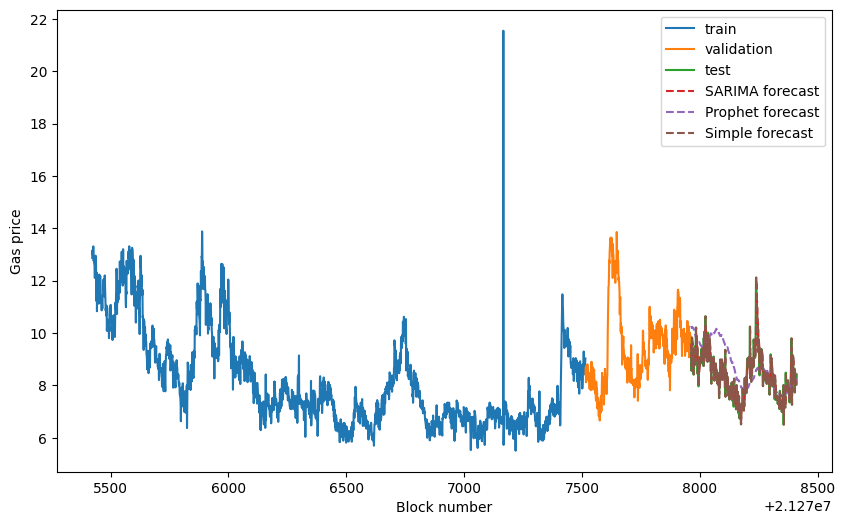

In [23]:
# plot the forecast
plt.figure(figsize=(10, 6))
# plot the train and validation data
plt.plot(train_block_numbers, train_data_min_gas_prices, label='train')
plt.plot(validation_block_numbers, validation_data_min_gas_prices, label='validation')
# plot the test data
plt.plot(test_block_numbers, test_data_min_gas_prices, label='test')
# plot the forecast
plt.plot(test_block_numbers, SARIMA_forecasts, label='SARIMA forecast', linestyle='--')
plt.plot(test_block_numbers, Prophet_forecasts, label='Prophet forecast', linestyle='--')
plt.plot(test_block_numbers, simple_forecasts, label='Simple forecast', linestyle='--')
plt.xlabel('Block number')
plt.ylabel('Gas price')
plt.legend()

# calculate the RMSE
SARIMA_RMSE = np.sqrt(np.mean((test_data_min_gas_prices - SARIMA_forecasts) ** 2))
print(f"SARIMA RMSE: {SARIMA_RMSE}")
Prophet_RMSE = np.sqrt(np.mean((test_data_min_gas_prices - Prophet_forecasts) ** 2))
print(f"Prophet RMSE: {Prophet_RMSE}")
simple_RMSE = np.sqrt(np.mean((test_data_min_gas_prices - simple_forecasts) ** 2))
print(f"Simple RMSE: {simple_RMSE}")

In [99]:
LSTM_predictions.shape

(429,)

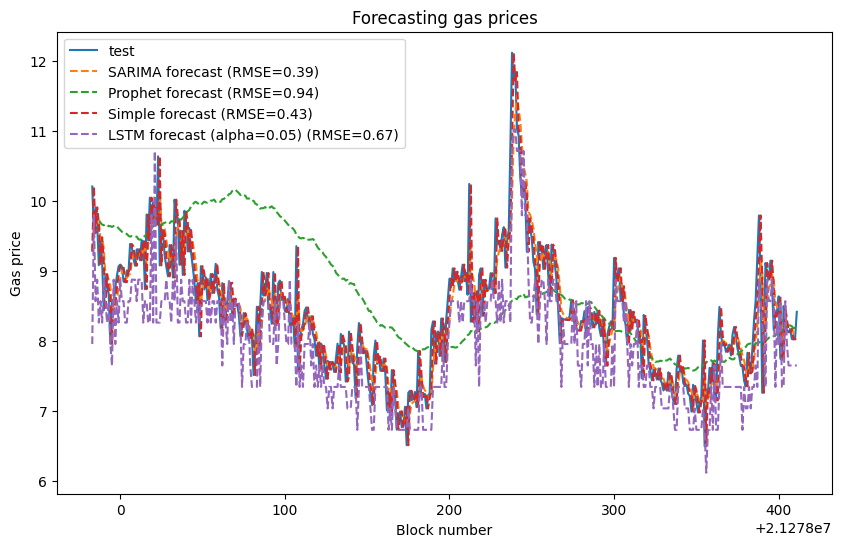

In [105]:
# plot the forecast
plt.figure(figsize=(10, 6))
# # plot the train and validation data
# plt.plot(train_block_numbers, train_data_min_gas_prices, label='train')
# plt.plot(validation_block_numbers, validation_data_min_gas_prices, label='validation')

SARIMA_RMSE = np.sqrt(np.mean((test_data_min_gas_prices - SARIMA_forecasts) ** 2))
Prophet_RMSE = np.sqrt(np.mean((test_data_min_gas_prices - Prophet_forecasts) ** 2))
simple_RMSE = np.sqrt(np.mean((test_data_min_gas_prices - simple_forecasts) ** 2))
LSTM_RMSE = np.sqrt(np.mean((test_data_min_gas_prices - LSTM_predictions) ** 2))



# plot the test data
plt.plot(test_block_numbers[seq_length:], test_data_min_gas_prices, label='test')
# plot the forecast
plt.plot(test_block_numbers[seq_length:], SARIMA_forecasts, label=f'SARIMA forecast (RMSE={SARIMA_RMSE:.2f})', linestyle='--')
plt.plot(test_block_numbers[seq_length:], Prophet_forecasts, label=f'Prophet forecast (RMSE={Prophet_RMSE:.2f})', linestyle='--')
plt.plot(test_block_numbers[seq_length:], simple_forecasts, label=f'Simple forecast (RMSE={simple_RMSE:.2f})', linestyle='--')
plt.plot(test_block_numbers[seq_length:], LSTM_predictions, label=f'LSTM forecast (alpha=0.05) (RMSE={LSTM_RMSE:.2f})', linestyle='--')
plt.xlabel('Block number')
plt.ylabel('Gas price')
plt.title('Forecasting gas prices')
plt.legend()

# # calculate the RMSE
# SARIMA_RMSE = np.sqrt(np.mean((test_data_min_gas_prices[seq_length:] - SARIMA_forecasts) ** 2))
# print(f"SARIMA RMSE: {SARIMA_RMSE}")
# Prophet_RMSE = np.sqrt(np.mean((test_data_min_gas_prices[seq_length:] - Prophet_forecasts) ** 2))
# print(f"Prophet RMSE: {Prophet_RMSE}")
# simple_RMSE = np.sqrt(np.mean((test_data_min_gas_prices[seq_length:] - simple_forecasts) ** 2))
# print(f"Simple RMSE: {simple_RMSE}")

In [24]:
# save forecasts to csv files in the forecasts/min_gas_prices/ folder
# first create the folder
import os
os.makedirs('forecasts/min_gas_prices/', exist_ok=True)

# save the forecasts using pickle
import pickle
with open('forecasts/min_gas_prices/SARIMA_forecasts.pkl', 'wb') as f:
    pickle.dump(SARIMA_forecasts, f)
with open('forecasts/min_gas_prices/Prophet_forecasts.pkl', 'wb') as f:
    pickle.dump(Prophet_forecasts, f)
with open('forecasts/min_gas_prices/simple_forecasts.pkl', 'wb') as f:
    pickle.dump(simple_forecasts, f)

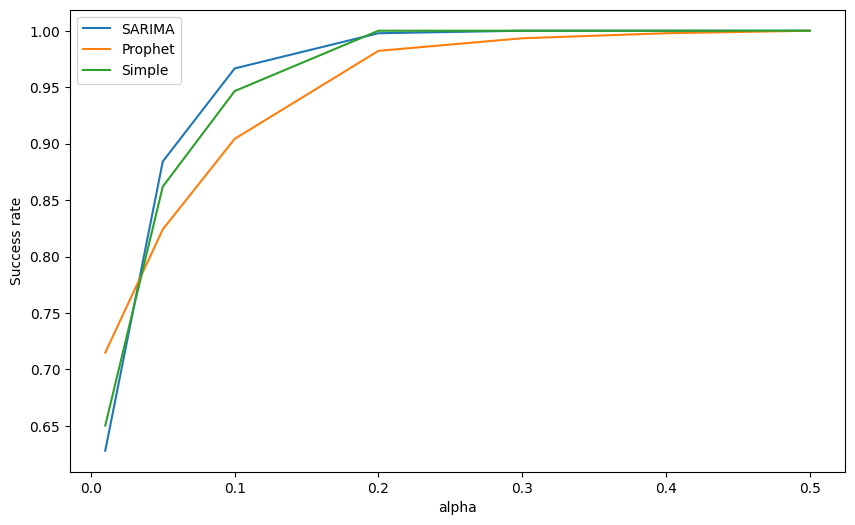

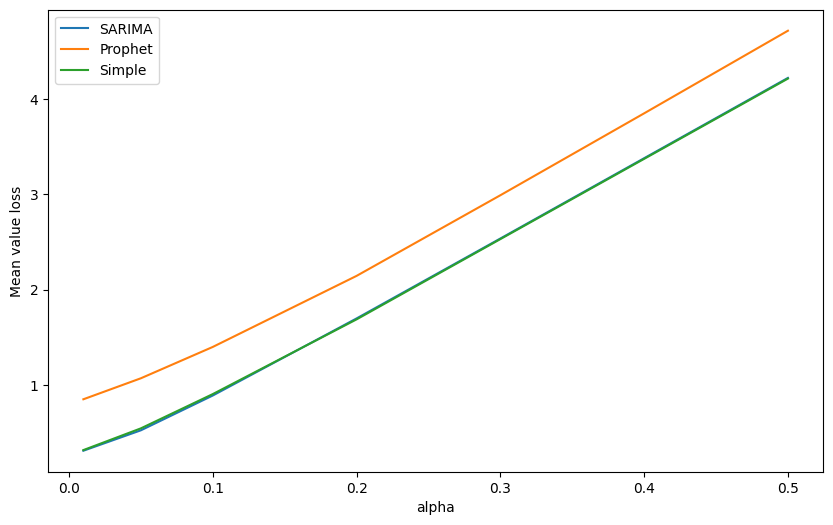

In [105]:
# suggest a bid of forecast + forecast*alpha, check the success rate of the bid (success=if we offer a bid higher than the actual price)
# also caclulate the mean value loss (MVL) which is the mean of the difference between the bid and the actual price
def calculate_success_rate_and_MVL(forecasts, test_data_min_gas_prices, alpha):
    bids = forecasts + forecasts * alpha
    success_rate = np.mean(bids > test_data_min_gas_prices)
    MVL = np.mean(bids[bids > test_data_min_gas_prices] - test_data_min_gas_prices[bids > test_data_min_gas_prices])
    return success_rate, MVL


alphas = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

SARIMA_success_rates = []
Prophet_success_rates = []
simple_success_rates = []
SARIMA_MVLs = []
Prophet_MVLs = []
simple_MVLs = []

for alpha in alphas:
    SARIMA_success_rate, SARIMA_MVL = calculate_success_rate_and_MVL(SARIMA_forecasts, test_data_min_gas_prices, alpha)
    Prophet_success_rate, Prophet_MVL = calculate_success_rate_and_MVL(Prophet_forecasts, test_data_min_gas_prices, alpha)
    simple_success_rate, simple_MVL = calculate_success_rate_and_MVL(simple_forecasts, test_data_min_gas_prices, alpha)
    SARIMA_success_rates.append(SARIMA_success_rate)
    Prophet_success_rates.append(Prophet_success_rate)
    simple_success_rates.append(simple_success_rate)
    SARIMA_MVLs.append(SARIMA_MVL)
    Prophet_MVLs.append(Prophet_MVL)
    simple_MVLs.append(simple_MVL)

# plot the success rates VS alpha
plt.figure(figsize=(10, 6))
plt.plot(alphas, SARIMA_success_rates, label='SARIMA')
plt.plot(alphas, Prophet_success_rates, label='Prophet')
plt.plot(alphas, simple_success_rates, label='Simple')
plt.xlabel('alpha')
plt.ylabel('Success rate')
plt.legend()

# plot the MVL VS alpha
plt.figure(figsize=(10, 6))
plt.plot(alphas, SARIMA_MVLs, label='SARIMA')
plt.plot(alphas, Prophet_MVLs, label='Prophet')
plt.plot(alphas, simple_MVLs, label='Simple')
plt.xlabel('alpha')
plt.ylabel('Mean value loss')
plt.legend()

# Distribution Prediction

## Data Preperation

In [7]:
# Define the quantization function
def quantize_gas_prices(gas_prices, min_gas_price, max_gas_price, num_bins=50):
    # Define bin edges based on the min and max gas prices
    bin_edges = np.linspace(min_gas_price, max_gas_price, num_bins)
    # Digitize the gas prices into bins
    quantized_prices = np.digitize(gas_prices, bin_edges) - 1
    # Create the quantized distribution
    quantized_distribution = np.bincount(quantized_prices, minlength=num_bins) / len(gas_prices)
    return quantized_distribution, bin_edges


class GasPriceDataset(Dataset):
    def __init__(self, data, min_gas_price, max_gas_price, num_bins=50, seq_length=20):
        self.data = data
        self.num_bins = num_bins
        self.seq_length = seq_length
        
        # Pre-process the data: quantize each distribution of gas prices
        self.quantized_data = []
        for gas_prices in data:
            quantized_distribution, bin_edges = quantize_gas_prices(gas_prices, min_gas_price, max_gas_price, num_bins)
            self.quantized_data.append(quantized_distribution.tolist())
            
        self.bin_edges = bin_edges
        # Create the X and y pairs
        self.X = []
        self.y = []
        for i in range(len(self.quantized_data) - self.seq_length):
            X = self.quantized_data[i:i + self.seq_length]
            y = self.quantized_data[i + self.seq_length]
            self.X.append(X)
            self.y.append(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float64)  # Sequence of 20 quantized distributions of gas prices
        y = torch.tensor(self.y[idx], dtype=torch.float64)  # The quantized distribution of gas prices at the next block
        return X, y

Percentage of gas prices above 0: 1.0
Percentage of gas prices above 5: 1.0
Percentage of gas prices above 10: 0.3405860042271056
Percentage of gas prices above 15: 0.0540664176727757
Percentage of gas prices above 20: 0.023208546860071223
Percentage of gas prices above 25: 0.016170126523639944
Percentage of gas prices above 30: 0.013017168997365297
Percentage of gas prices above 35: 0.010796490923304092
Percentage of gas prices above 40: 0.009007209241726743


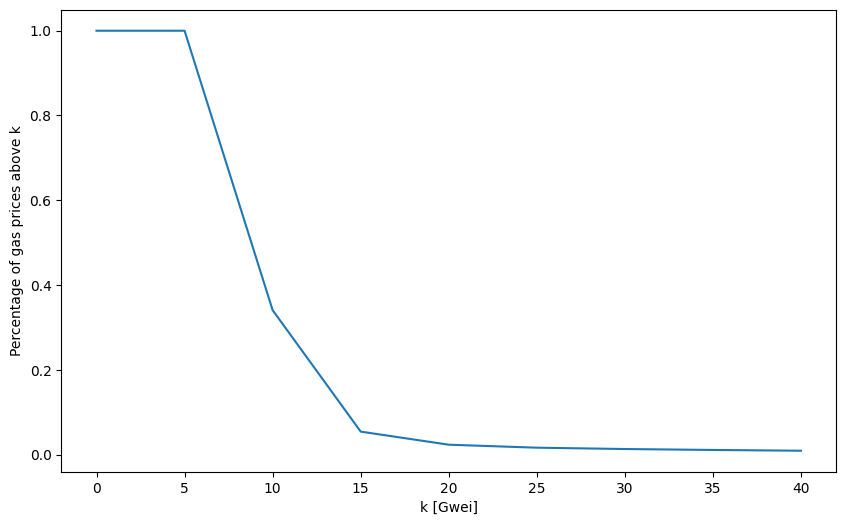

In [27]:
def percent_of_prices_above_k(gas_prices, k):
    all_prices = np.concatenate(gas_prices)
    return np.mean(all_prices > k)

ks = np.arange(0, 45, 5)
k_lst = []
for k in ks:
    percent_prices_above_k = percent_of_prices_above_k(train_data_block_gas_prices, k)
    print(f"Percentage of gas prices above {k}: {percent_prices_above_k}")
    k_lst.append(percent_prices_above_k)

plt.figure(figsize=(10, 6))
plt.plot(ks, k_lst)
plt.xlabel('k [Gwei]')
plt.ylabel('Percentage of gas prices above k')
plt.xticks(ks)
plt.show()

In [8]:
num_bins = 50
min_gas_price = 0
max_gas_price = 15

# Create the datasets for training, validation, and test
train_dataset = GasPriceDataset(train_data_block_gas_prices, min_gas_price, max_gas_price, num_bins=num_bins, seq_length=seq_length)
val_dataset = GasPriceDataset(validation_data_block_gas_prices, min_gas_price, max_gas_price, num_bins=num_bins, seq_length=seq_length)
test_dataset = GasPriceDataset(test_data_block_gas_prices, min_gas_price, max_gas_price, num_bins=num_bins, seq_length=seq_length)

bin_edges = train_dataset.bin_edges
bin_width = bin_edges[1] - bin_edges[0]

# Create DataLoader objects
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

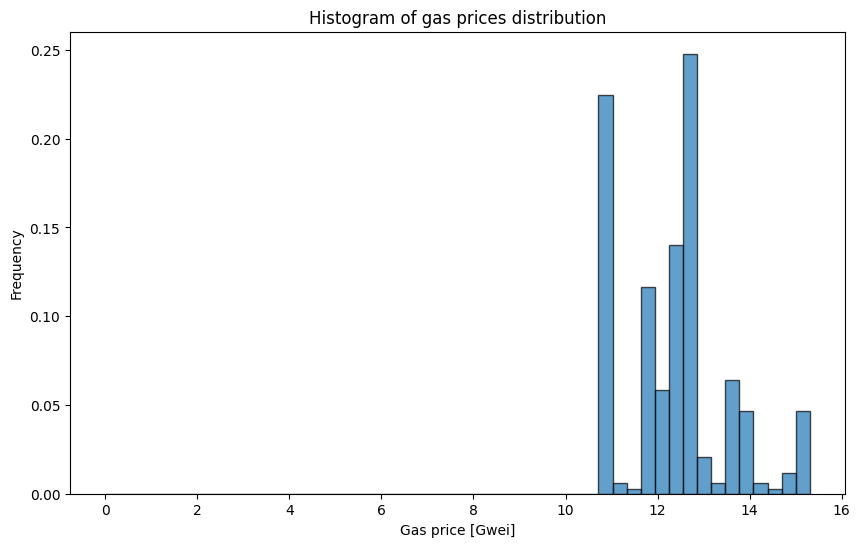

In [29]:
for X,y in train_dataset:
    plt.figure(figsize=(10, 6))
    # Calculate the width of the bars based on bin edges
    plt.bar(bin_edges, y, align='edge', edgecolor='black', width=bin_width, alpha=0.7)
    # plt.xticks(bin_edges, rotation=90)
    plt.xlabel('Gas price [Gwei]')
    plt.ylabel('Frequency')
    plt.title('Histogram of gas prices distribution')
    plt.show()
    break

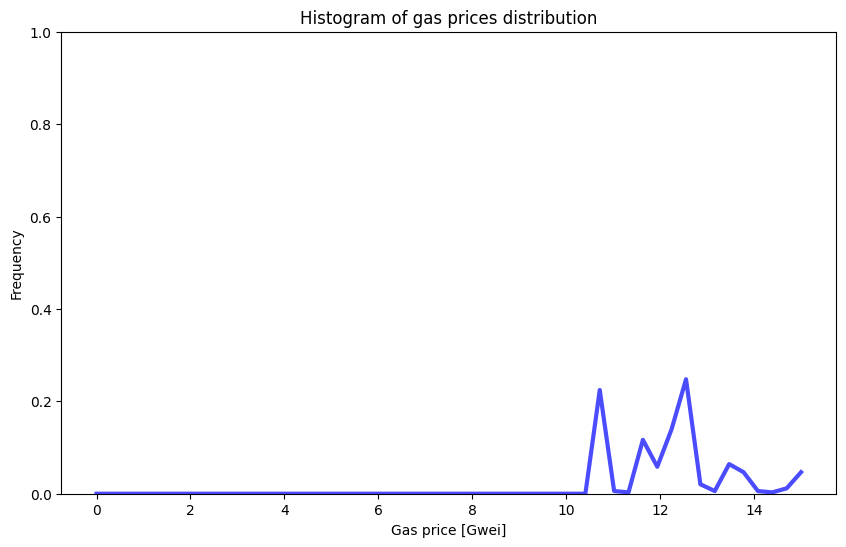

In [30]:
for X,y in train_dataset:
    plt.figure(figsize=(10, 6))
    # Calculate the width of the bars based on bin edges
    # plt.bar(bin_edges, y, align='edge', edgecolor='black', width=bin_width, alpha=0.7)
    plt.plot(bin_edges, y, color='blue', alpha=0.7, linewidth=3)
    # plt.xticks(bin_edges, rotation=90)
    plt.ylim(0, 1)
    plt.xlabel('Gas price [Gwei]')
    plt.ylabel('Frequency')
    plt.title('Histogram of gas prices distribution')
    plt.show()
    break

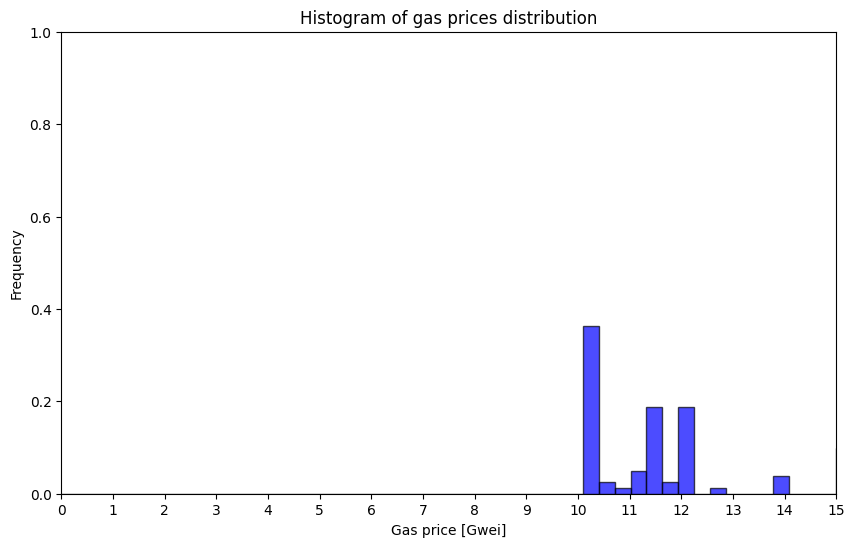

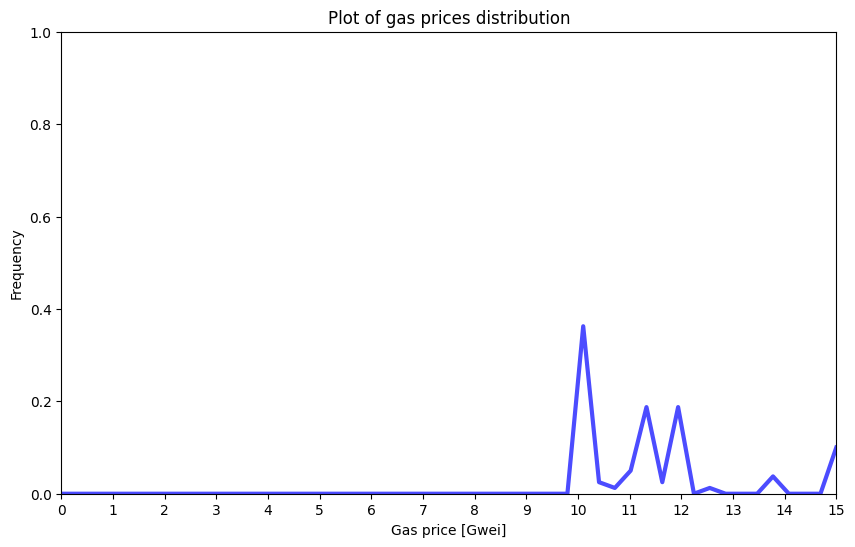

In [9]:
for X,y in test_dataset:
    plt.figure(figsize=(10, 6))
    # Calculate the width of the bars based on bin edges
    plt.bar(bin_edges, y, align='edge', edgecolor='black', width=bin_width, alpha=0.7, color='blue')
    # plt.xticks(bin_edges, rotation=90)
    plt.xlim(0,15)
    plt.ylim(0, 1)
    plt.xticks(np.arange(0, 16, 1))
    plt.xlabel('Gas price [Gwei]')
    plt.ylabel('Frequency')
    plt.title('Histogram of gas prices distribution')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(bin_edges, y, color='blue', alpha=0.7, linewidth=3)
    # plt.xticks(bin_edges, rotation=90)
    plt.ylim(0, 1)
    plt.xlim(0, 15)
    plt.xticks(np.arange(0, 16, 1))
    plt.xlabel('Gas price [Gwei]')
    plt.ylabel('Frequency')
    plt.title('Plot of gas prices distribution')
    plt.show()
    break

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
import io
import tqdm

# List to store frames
frames = []

for X, y in tqdm.tqdm(train_dataset):
    # Plot the histogram for each time slice
    plt.figure(figsize=(10, 6))
    plt.plot(bin_edges, y, color='blue', alpha=0.7, linewidth=3)
    # plt.xticks(bin_edges, rotation=90)
    plt.ylim(0, 1)
    plt.xlim(0, 15)
    plt.xticks(np.arange(0, 16, 1))
    plt.xlabel('Gas price [Gwei]')
    plt.ylabel('Frequency')
    plt.title('Plot of gas prices distribution over time (train set)')

    # Save the plot as an image in memory
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    img = Image.open(buf)
    frames.append(img)
    plt.close(fig)

  1%|          | 20/2071 [00:03<06:11,  5.51it/s]/tmp/ipykernel_965044/1985173238.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))
 99%|█████████▉| 2051/2071 [04:43<00:02,  7.53it/s]

In [32]:
# Calculate duration per frame
total_duration = 5000  # 5 seconds in ms
num_frames = len(frames)
duration_per_frame = total_duration // num_frames

# Create an animated GIF from the frames
frames[0].save('gas_price_distribution.gif', save_all=True, append_images=frames[1:], duration=duration_per_frame, loop=0)

## LSTM

In [10]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Set device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
class GasPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_bins, num_layers=1, bidirectional=False):
        super(GasPriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        num_directions = 2 if bidirectional else 1  # Adjust for bidirectional LSTM
        
        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=num_layers, bidirectional=bidirectional)
        
        # Fully connected layer to output the predicted distribution
        self.fc = nn.Linear(hidden_size * num_directions, num_bins)  # Adjusted for bidirectional
        
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Pass the input through the LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # We will use the output of the last time step
        lstm_out_last = lstm_out[:, -1, :]  # shape: (batch_size, hidden_size * num_directions)

        # Apply ReLU activation
        lstm_out_last = self.relu(lstm_out_last)

        # Pass through the fully connected layer
        output = self.fc(lstm_out_last)  # shape: (batch_size, num_bins)

        # Apply ReLU at the end
        output = torch.relu(output)

        # normalize the output (each distribution should sum to 1)
        output = output / output.sum(dim=1, keepdim=True)
        return output

Using device: cuda


In [11]:
# Define the function for training one epoch
def train_one_epoch(model, train_dataloader, optimizer, criterion):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for X_batch, y_batch in train_dataloader:
        # Move data to the device and convert to float64 (double precision)
        X_batch, y_batch = X_batch.to(device).double(), y_batch.to(device).double()
        
        optimizer.zero_grad()  # Clear the gradients
        output = model(X_batch)  # Predicted distribution
        loss = criterion(output, y_batch)  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_dataloader)
    return avg_train_loss

# Define the function for evaluating the model (validation or test)
def evaluate_model(model, dataloader, criterion):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient computation for evaluation
        for X_batch, y_batch in dataloader:
            # Move data to the device and convert to float64 (double precision)
            X_batch, y_batch = X_batch.to(device).double(), y_batch.to(device).double()
            
            output = model(X_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(dataloader)
    return avg_val_loss

# Define the function for training the model with validation
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs=20):
    best_val_loss = float('inf')  # Initialize to a very large number
    best_model_wts = None

    # Lists to store the training and validation loss per epoch
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Train for one epoch
        avg_train_loss = train_one_epoch(model, train_dataloader, optimizer, criterion)
        train_losses.append(avg_train_loss)
        
        # Evaluate on the validation set
        avg_val_loss = evaluate_model(model, val_dataloader, criterion)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
        
        # Save the model if it has the best validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = model.state_dict()  # Save the current best model weights
            print(f"Saving model with better validation loss: {avg_val_loss:.4f}")
    
    return best_model_wts, train_losses, val_losses

# Define the function to load the best model's weights
def load_best_model(model, best_model_wts):
    model.load_state_dict(best_model_wts)
    print("Loaded the best model with the lowest validation loss.")
    return model
# Define the function to plot the losses
def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Training Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red')
    plt.title('Training and Validation Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch [1/20], Train Loss: 0.0033, Validation Loss: 0.0030
Saving model with better validation loss: 0.0030
Epoch [2/20], Train Loss: 0.0027, Validation Loss: 0.0029
Saving model with better validation loss: 0.0029
Epoch [3/20], Train Loss: 0.0026, Validation Loss: 0.0028
Saving model with better validation loss: 0.0028
Epoch [4/20], Train Loss: 0.0026, Validation Loss: 0.0028
Saving model with better validation loss: 0.0028
Epoch [5/20], Train Loss: 0.0025, Validation Loss: 0.0028
Epoch [6/20], Train Loss: 0.0025, Validation Loss: 0.0028
Epoch [7/20], Train Loss: 0.0025, Validation Loss: 0.0028
Saving model with better validation loss: 0.0028
Epoch [8/20], Train Loss: 0.0025, Validation Loss: 0.0028
Epoch [9/20], Train Loss: 0.0025, Validation Loss: 0.0028
Epoch [10/20], Train Loss: 0.0025, Validation Loss: 0.0028
Saving model with better validation loss: 0.0028
Epoch [11/20], Train Loss: 0.0025, Validation Loss: 0.0028
Epoch [12/20], Train Loss: 0.0025, Validation Loss: 0.0028
Epoch [

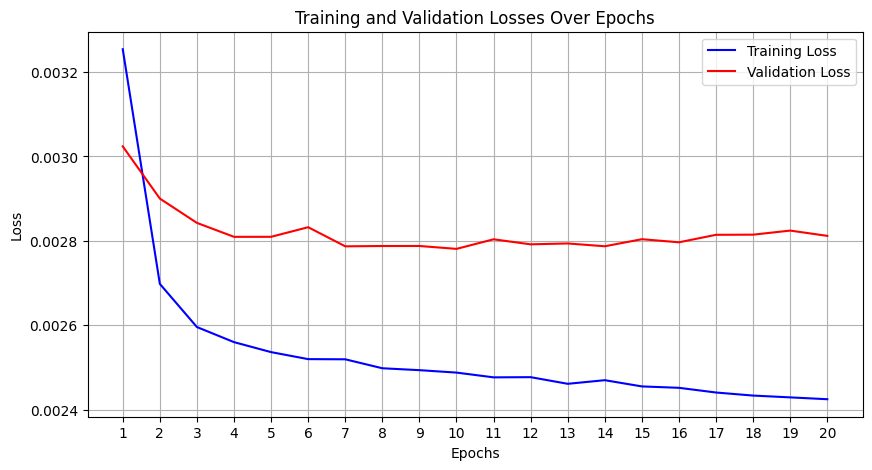

In [35]:
# Define model parameters
input_size = num_bins  # Each input has 'num_bins' features (one for each quantized price bin)
hidden_size = 128      # You can experiment with the hidden size
output_size = num_bins # We are predicting the distribution, so the output size is the same as input size

# Instantiate the model and move it to the device (GPU or CPU), ensure it's using float64
model = GasPriceLSTM(input_size, hidden_size, num_bins).to(device).double()

# Example usage:
# Initialize the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression tasks
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
best_model_wts, train_losses, val_losses = train_model(model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs=20)

model = load_best_model(model, best_model_wts)

# After training, evaluate on the test set
test_loss = evaluate_model(model, test_dataloader, criterion)
print(f"Test Loss: {test_loss:.4f}")

# Plot training and validation losses
plot_losses(train_losses, val_losses)

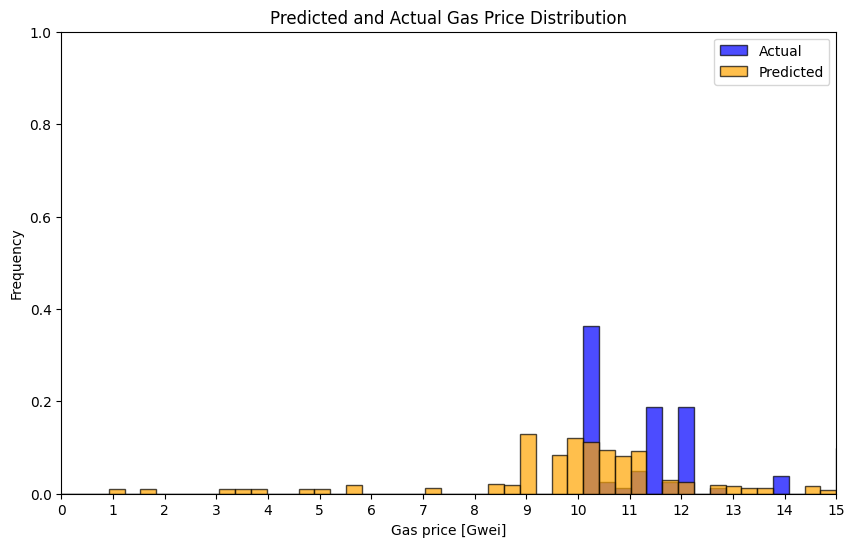

In [61]:
# plot example predictions of distributions vs actual distributions
model.eval()
X_example, y_example = next(iter(test_dataloader))
X_example, y_example = X_example.to(device).double(), y_example.to(device).double()
output = model(X_example)
output = output.cpu().detach().numpy()
y_example = y_example.cpu().detach().numpy()


# Plot the predicted and actual distributions for the first example
plt.figure(figsize=(10, 6))
plt.bar(bin_edges, y_example[0], align='edge', edgecolor='black', width=bin_width, alpha=0.7, label='Actual', color='blue')
plt.bar(bin_edges, output[0], align='edge', edgecolor='black', width=bin_width, alpha=0.7, label='Predicted', color='orange')
plt.ylim(0, 1)
plt.xlim(0, 15)
plt.xticks(np.arange(0, 16, 1))
plt.xlabel('Gas price [Gwei]')
plt.ylabel('Frequency')
plt.title('Predicted and Actual Gas Price Distribution')
plt.legend()
plt.show()

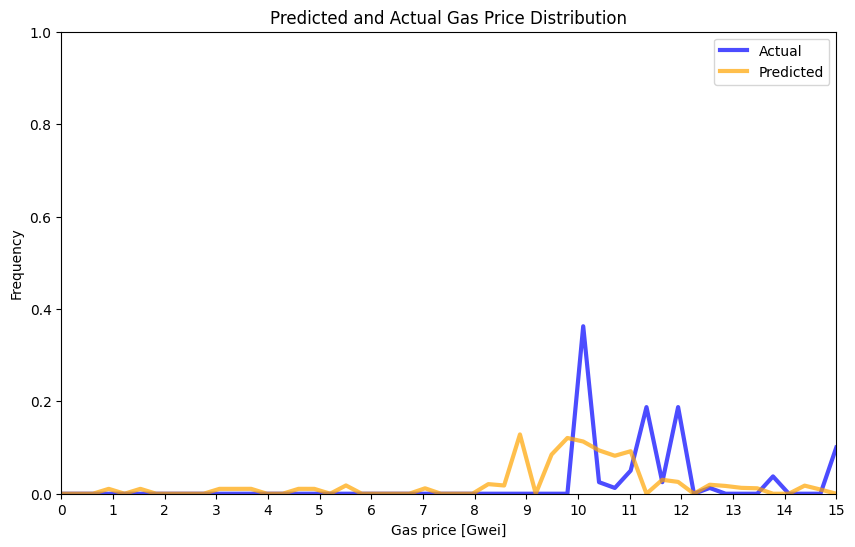

In [62]:
# Plot the predicted and actual distributions for the first example
plt.figure(figsize=(10, 6))
# plt.bar(bin_edges, output[0], align='edge', edgecolor='black', width=bin_width, alpha=0.5, label='Predicted')
# plt.bar(bin_edges, y_example[0], align='edge', edgecolor='black', width=bin_width, alpha=0.5, label='Actual')

plt.plot(bin_edges, y_example[0], color='blue', alpha=0.7, linewidth=3, label='Actual')
plt.plot(bin_edges, output[0], color='orange', alpha=0.7, linewidth=3, label='Predicted')
# plt.xticks(bin_edges, rotation=90)
plt.ylim(0, 1)
plt.xlim(0, 15)
plt.xticks(np.arange(0, 16, 1))
plt.xlabel('Gas price [Gwei]')
plt.ylabel('Frequency')
plt.title('Predicted and Actual Gas Price Distribution')
plt.legend()
plt.show()

Training model 1/24


Epoch [1/200], Train Loss: 0.0036, Validation Loss: 0.0036
Saving model with better validation loss: 0.0036
Epoch [2/200], Train Loss: 0.0032, Validation Loss: 0.0031
Saving model with better validation loss: 0.0031
Epoch [3/200], Train Loss: 0.0029, Validation Loss: 0.0030
Saving model with better validation loss: 0.0030
Epoch [4/200], Train Loss: 0.0028, Validation Loss: 0.0029
Saving model with better validation loss: 0.0029
Epoch [5/200], Train Loss: 0.0027, Validation Loss: 0.0028
Saving model with better validation loss: 0.0028
Epoch [6/200], Train Loss: 0.0027, Validation Loss: 0.0028
Saving model with better validation loss: 0.0028
Epoch [7/200], Train Loss: 0.0027, Validation Loss: 0.0028
Saving model with better validation loss: 0.0028
Epoch [8/200], Train Loss: 0.0026, Validation Loss: 0.0028
Saving model with better validation loss: 0.0028
Epoch [9/200], Train Loss: 0.0026, Validation Loss: 0.0028
Saving model with better validation loss: 0.0028
Epoch [10/200], Train Loss: 

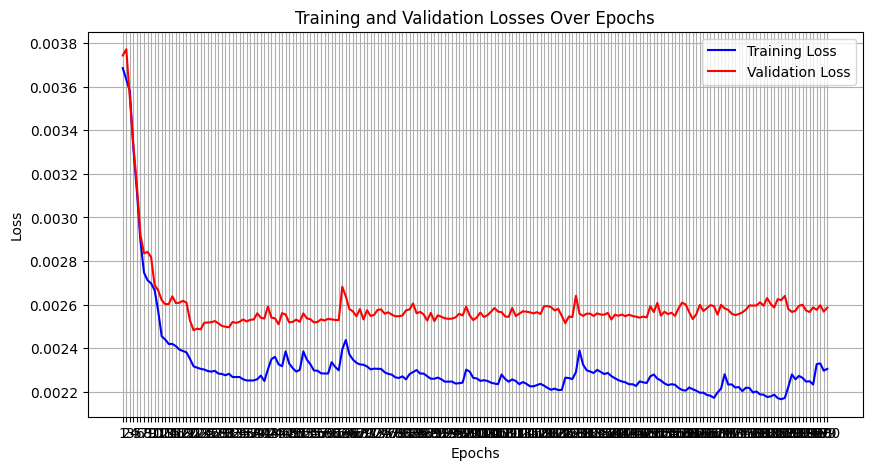

Best test loss: 0.0022057955977450145


In [37]:
# Define model parameters
input_size = num_bins  # Each input has 'num_bins' features (one for each quantized price bin)
output_size = num_bins # We are predicting the distribution, so the output size is the same as input size
epochs = 200

hidden_sizes = [32, 64, 128]
num_layers = [1, 2]
lrs = [0.001, 0.05]
bidirectional = [False, True]

results = dict()
count = 0
total_count = len(hidden_sizes) * len(num_layers) * len(lrs) * len(bidirectional)
for hidden_size in hidden_sizes:
    for num_layer in num_layers:
        for lr in lrs:
            for bi in bidirectional:
                count += 1
                print(f"Training model {count}/{total_count}")
                model = GasPriceLSTM(input_size, hidden_size, num_bins, num_layers=num_layer, bidirectional=bi).to(device).double()
                criterion = nn.MSELoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                trained_model_wts, train_losses, val_losses = train_model(model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs=epochs)
                trained_model = load_best_model(model, trained_model_wts)
                test_loss = evaluate_model(trained_model, test_dataloader, criterion)
                print(f"hidden_size: {hidden_size}, num_layers: {num_layer}, lr: {lr}, bidirectional: {bi}, Test Loss: {test_loss:.4f}")
                results[(hidden_size, num_layer, lr, bi)] = test_loss, train_losses, val_losses, trained_model_wts

# save the best results
best_result = min(results, key=lambda x: results[x][0])
best_test_loss, best_train_losses, best_val_losses, best_trained_model = results[best_result]

# save the best model
torch.save(best_trained_model, 'best_trained_model.pth')

# plot the best model losses
plot_losses(best_train_losses, best_val_losses)
print(f"Best test loss: {best_test_loss}")

In [38]:
# best model and its parameters
print(f"Best model parameters: {best_result}")

Best model parameters: (32, 2, 0.05, True)


In [39]:
# save results using pickle
import pickle
with open('results.pkl', 'wb') as f:
    pickle.dump(results, f)

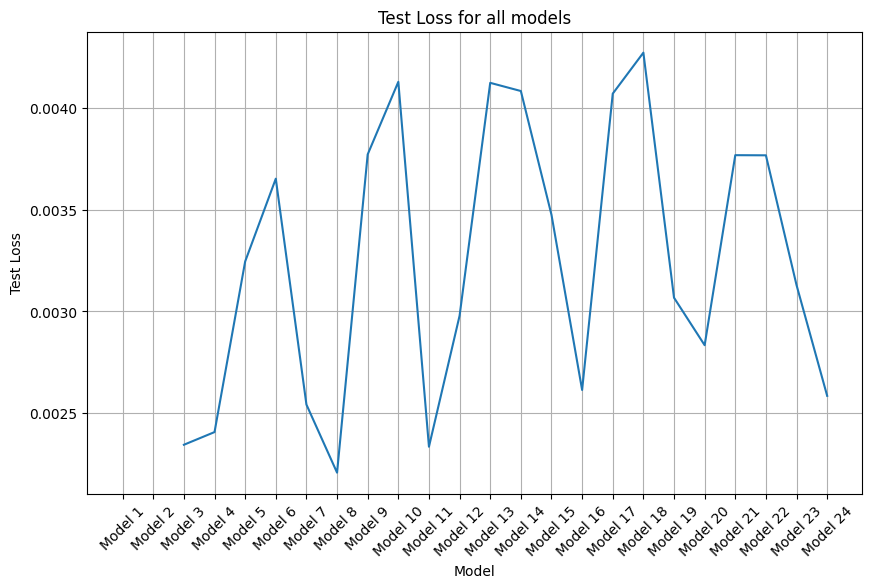

In [40]:
# plot all the test losses
test_losses = [results[key][0] for key in results]
plt.figure(figsize=(10, 6))
plt.plot(test_losses)
plt.xlabel('Model')
plt.ylabel('Test Loss')
plt.title('Test Loss for all models')
plt.xticks(range(len(test_losses)), [f'Model {i + 1}' for i in range(len(test_losses))], rotation=45)
plt.grid(True)
plt.show()

In [14]:
# load best model
# best_hidden_size, best_num_layers, best_lr, best_bi = best_result
best_hidden_size, best_num_layers, best_lr, best_bi = (32, 2, 0.05, True)
input_size = num_bins  
output_size = num_bins 
# load the best trained model
best_trained_model = GasPriceLSTM(input_size, best_hidden_size, num_bins, num_layers=best_num_layers, bidirectional=best_bi).to(device).double()
best_trained_model.load_state_dict(torch.load('best_trained_model.pth'))

/tmp/ipykernel_1040009/2718016414.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_trained_model.load_state_dict(torch.load('best_trained_model.pth'))


<All keys matched successfully>

In [75]:
def plot_index_pred(index):
    block_num = test_block_numbers[index]
    # Retrieve the random example from the test dataset
    X_example, y_example = test_dataloader.dataset[index]
    block_num = test_block_numbers[index]

    # Prepare the data for plotting (assuming bin_edges and bin_width are defined)
    X_example = X_example.to(device).double()
    y_example = y_example.to(device).double()

    # Evaluate with the trained model
    best_trained_model.eval()
    output = best_trained_model(X_example.unsqueeze(0))  # Assuming your model expects a batch dimension

    # Convert to numpy arrays
    output = output.cpu().detach().numpy().flatten()
    y_example = y_example.cpu().detach().numpy()

    
    # Plot the predicted and actual distributions for the first example
    plt.figure(figsize=(10, 6))
    plt.bar(bin_edges, y_example, align='edge', edgecolor='black', width=bin_width, alpha=0.7, label='Actual', color='blue')
    plt.bar(bin_edges, output, align='edge', edgecolor='black', width=bin_width, alpha=0.7, label='Predicted', color='orange')
    plt.ylim(0, 1)
    plt.xlim(0, 15)
    plt.xticks(np.arange(0, 16, 1))
    plt.xlabel('Gas price [Gwei]', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
    plt.title(f'Predicted and Actual Gas Price Distribution of block {block_num}', fontsize=20)
    # increase test sizes
    plt.legend(fontsize=20)
    plt.show()

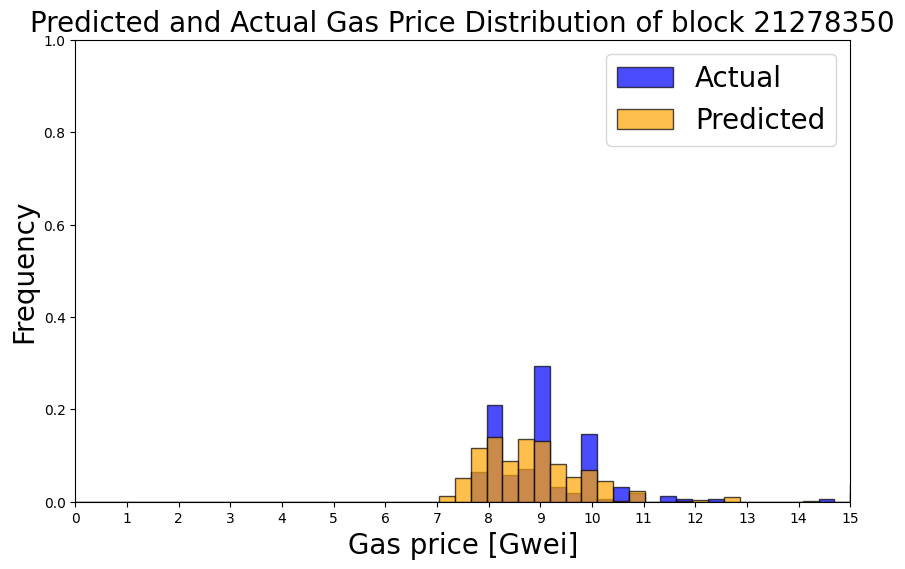

In [79]:
import random

# Assuming test_dataloader is your DataLoader for the test dataset

# Get the total number of examples in the test dataset
total_examples = len(test_dataloader.dataset)
# Choose a random index
random_index = random.randint(0, total_examples - 1)

plot_index_pred(random_index)

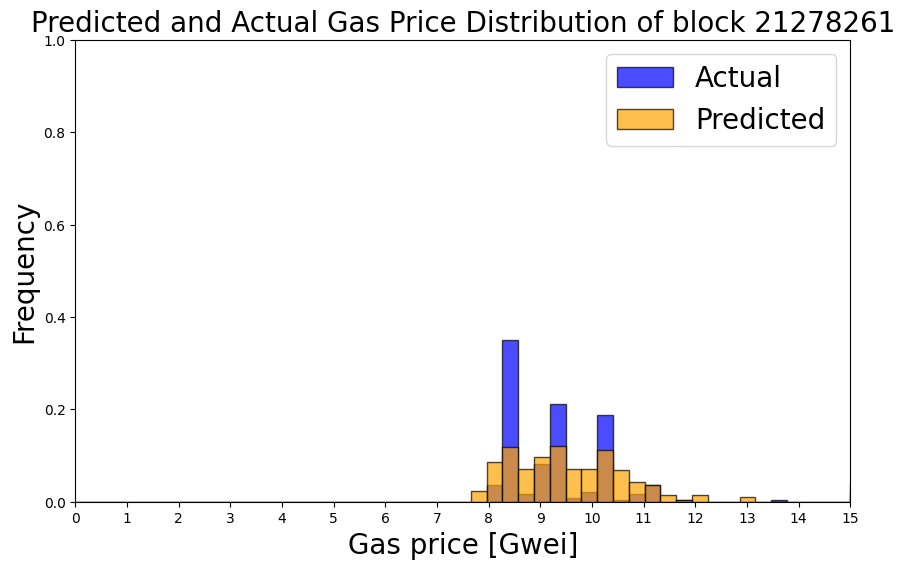

In [80]:
random_index = random.randint(0, total_examples - 1)
plot_index_pred(random_index)

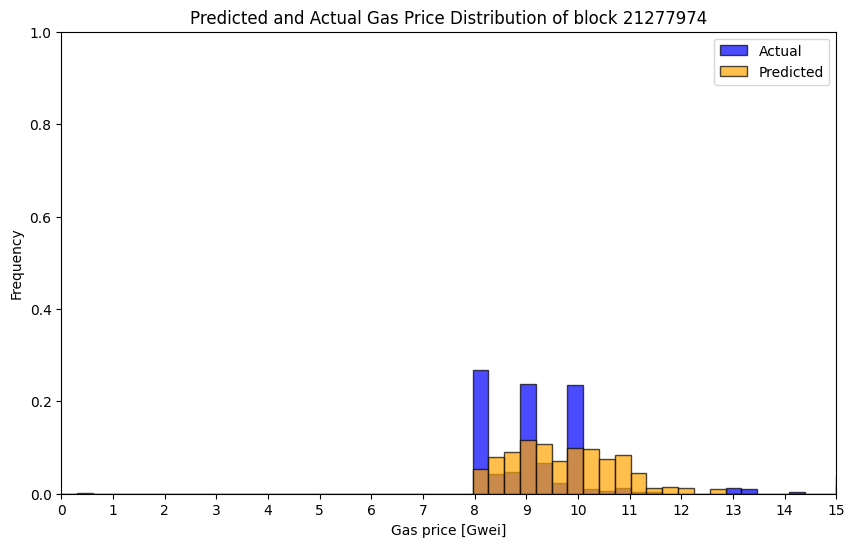

In [47]:
plot_index_pred(11)

In [32]:
import tqdm
# Calculate the mean error for each bin and plot the results
def calculate_mean_error_per_bin(model, dataloader):
    model.eval()
    mean_errors = np.zeros(num_bins)
    with torch.no_grad():
        for X_batch, y_batch in tqdm.tqdm(dataloader):
            X_batch, y_batch = X_batch.to(device).double(), y_batch.to(device).double()
            output = model(X_batch)
            output = output.cpu().detach().numpy()
            y_batch = y_batch.cpu().detach().numpy()
            errors = np.abs(output - y_batch)
            mean_errors += errors.sum(axis=0)
    mean_errors /= len(dataloader.dataset)
    return mean_errors

mean_errors = calculate_mean_error_per_bin(best_trained_model, test_dataloader)

100%|██████████| 14/14 [00:00<00:00, 181.42it/s]


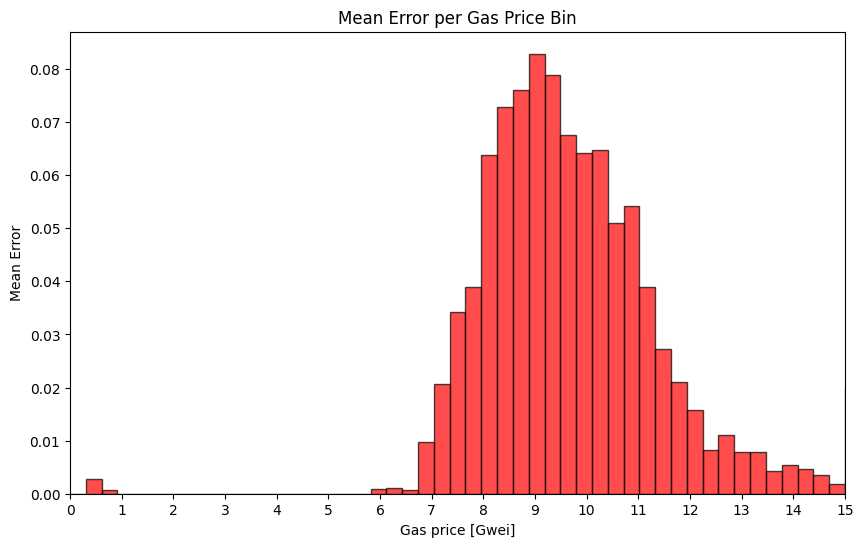

In [54]:
# plot the mean errors
plt.figure(figsize=(10, 6))
plt.bar(bin_edges, mean_errors, align='edge', edgecolor='black', width=bin_width, alpha=0.7, color='red')
plt.xlabel('Gas price [Gwei]')
plt.ylabel('Mean Error')
plt.xlim(0, 15)
plt.xticks(np.arange(0, 16, 1))
plt.title('Mean Error per Gas Price Bin')
plt.show()

In [34]:
# statistical test to check if mean_errors iss guassian distributed
from scipy.stats import shapiro

# Perform the Shapiro-Wilk test for normality
stat, p = shapiro(mean_errors)
print(f'Statistics={stat:.3f}, p-value={p:.3f}')

# Define the significance level
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.734, p-value=0.000
Sample does not look Gaussian (reject H0)


# Use Distribution to Predict Minimum Price

In [35]:
# Given a quantile alpha, calculate the quantile of the empirical distribution
def calc_quantile(alpha, distribution_hist):
    cum_dist = np.cumsum(distribution_hist)
    quantile = bin_edges[np.argmax(cum_dist >= alpha)]
    return quantile

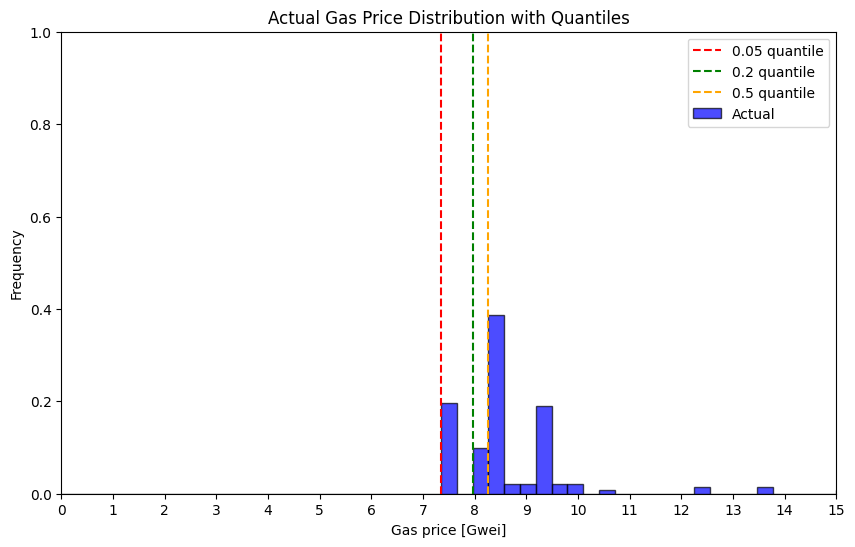

In [56]:
# plot example alpha quantiles on real example
# Retrieve the random example from the test dataset
random_index = random.randint(0, total_examples - 1)
X_example, y_example = test_dataloader.dataset[random_index]
block_num = test_block_numbers[random_index]

# Prepare the data for plotting (assuming bin_edges and bin_width are defined)
X_example = X_example.to(device).double()
y_example = y_example.to(device).double()
y_example = y_example.cpu().detach().numpy()

# plot y_example and some quantiles
plt.figure(figsize=(10, 6))
plt.bar(bin_edges, y_example, align='edge', edgecolor='black', width=bin_width, alpha=0.7, label='Actual', color='blue')
# plot the 0.25 quantile
quantile_25 = calc_quantile(0.05, y_example)
plt.axvline(quantile_25, color='red', linestyle='--', label='0.05 quantile')
# plot the 0.5 quantile
quantile_50 = calc_quantile(0.2, y_example)
plt.axvline(quantile_50, color='green', linestyle='--', label='0.2 quantile')
# plot the 0.75 quantile
quantile_75 = calc_quantile(0.5, y_example)
plt.axvline(quantile_75, color='orange', linestyle='--', label='0.5 quantile')
plt.ylim(0, 1)
plt.xlim(0, 15)
plt.xticks(np.arange(0, 16, 1))
plt.xlabel('Gas price [Gwei]')
plt.ylabel('Frequency')
plt.title('Actual Gas Price Distribution with Quantiles')
plt.legend()
plt.show()

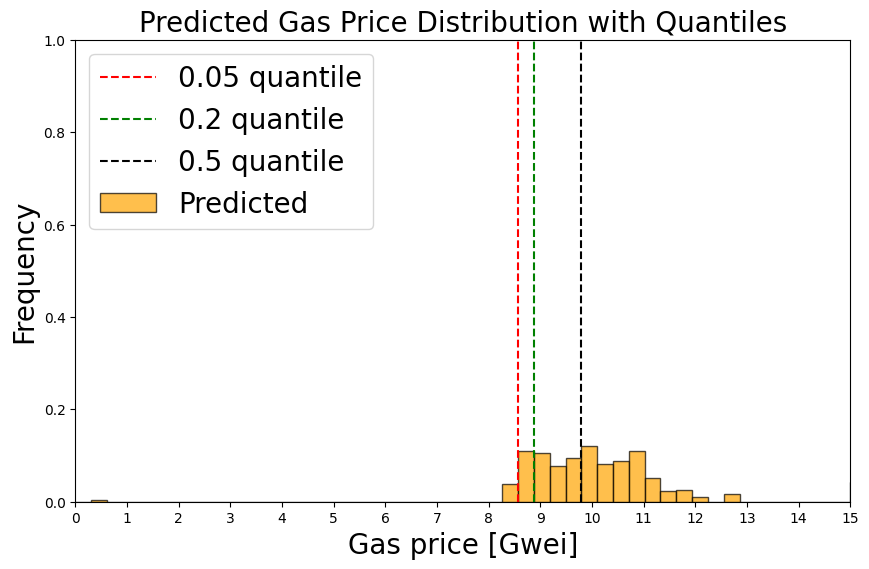

In [83]:
# plot example alpha quantiles on real example
# Retrieve the random example from the test dataset
random_index = random.randint(0, total_examples - 1)
X_example, y_example = test_dataloader.dataset[random_index]
block_num = test_block_numbers[random_index]

# Prepare the data for plotting (assuming bin_edges and bin_width are defined)
X_example = X_example.to(device).double()
y_example = y_example.to(device).double()

 # Prepare the data for plotting (assuming bin_edges and bin_width are defined)
X_example = X_example.to(device).double()
y_example = y_example.to(device).double()

# Evaluate with the trained model
best_trained_model.eval()
output = best_trained_model(X_example.unsqueeze(0))  # Assuming your model expects a batch dimension

# Convert to numpy arrays
output = output.cpu().detach().numpy().flatten()
y_example = y_example.cpu().detach().numpy()


# plot y_example and some quantiles
plt.figure(figsize=(10, 6))
plt.bar(bin_edges, output, align='edge', edgecolor='black', width=bin_width, alpha=0.7, label='Predicted', color='orange')
# plot the 0.25 quantile
quantile_25 = calc_quantile(0.05, output)
plt.axvline(quantile_25, color='red', linestyle='--', label='0.05 quantile')
# plot the 0.5 quantile
quantile_50 = calc_quantile(0.2, output)
plt.axvline(quantile_50, color='green', linestyle='--', label='0.2 quantile')
# plot the 0.75 quantile
quantile_75 = calc_quantile(0.5, output)
plt.axvline(quantile_75, color='black', linestyle='--', label='0.5 quantile')
plt.ylim(0, 1)
plt.xlim(0, 15)
plt.xticks(np.arange(0, 16, 1))
plt.xlabel('Gas price [Gwei]', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.title('Predicted Gas Price Distribution with Quantiles', fontsize=20)
plt.legend(fontsize=20)
plt.show()

In [84]:
random_index

56

In [37]:
alpha = 0.05
# for each predicted distribution, calculate the alpha quantile and suggest it as a bid
def calculate_alpha_quantile_bid(model, dataloader, alpha):
    model.eval()
    quantile_bids = []
    with torch.no_grad():
        for X_batch, y_batch in tqdm.tqdm(dataloader):
            X_batch, y_batch = X_batch.to(device).double(), y_batch.to(device).double()
            output = model(X_batch)
            output = output.cpu().detach().numpy()
            for distribution in output:
                quantile = calc_quantile(alpha, distribution)
                quantile_bids.append(quantile)
    return np.array(quantile_bids)

In [38]:
test_data_min_gas_prices.shape, np.array(test_dataloader.dataset.y).shape

((449,), (429, 50))

In [39]:
def calculate_success_rate_and_MVL_bids(best_trained_model, test_dataloader, test_data_min_gas_prices, alpha):
    real_dataset = test_data_min_gas_prices[seq_length:] # we begin predicting distributions from seq_length
    bids = calculate_alpha_quantile_bid(best_trained_model, test_dataloader, alpha)
    success_rate = np.mean(bids > real_dataset)
    MVL = np.mean(bids[bids > real_dataset] - real_dataset[bids > real_dataset])
    return success_rate, MVL

alpha = 0.05
LSTM_success_rate, LSTM_MVL = calculate_success_rate_and_MVL_bids(best_trained_model, test_dataloader, test_data_min_gas_prices, alpha)

100%|██████████| 14/14 [00:00<00:00, 184.38it/s]


100%|██████████| 14/14 [00:00<00:00, 176.13it/s]


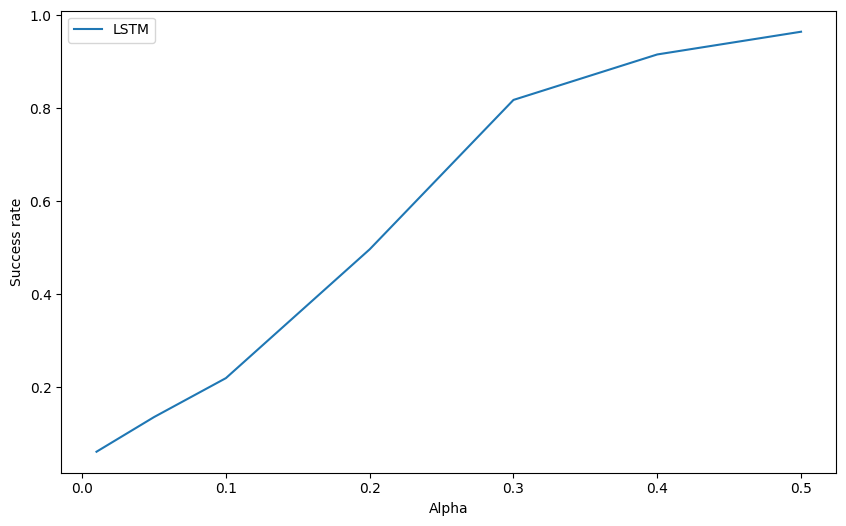

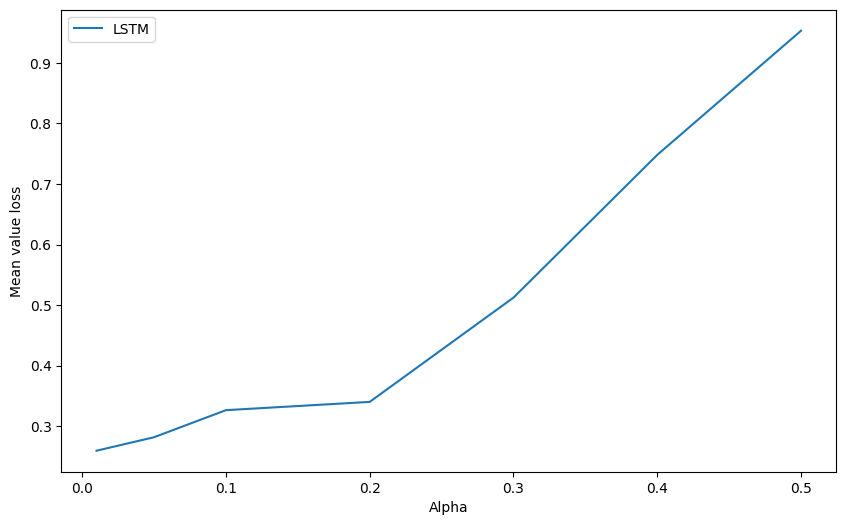

In [40]:
alphas = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

LSTM_success_rates = []
LSTM_MVLs = []

for alpha in alphas:
    success_rate, MVL = calculate_success_rate_and_MVL_bids(best_trained_model, test_dataloader, test_data_min_gas_prices, alpha)
    LSTM_success_rates.append(success_rate)
    LSTM_MVLs.append(MVL)

# plot the success rates VS alpha
plt.figure(figsize=(10, 6))
plt.plot(alphas, LSTM_success_rates, label='LSTM')
plt.xlabel('Alpha')
plt.ylabel('Success rate')
plt.legend()
plt.show()

# plot the MVL VS alpha
plt.figure(figsize=(10, 6))
plt.plot(alphas, LSTM_MVLs, label='LSTM')
plt.xlabel('Alpha')
plt.ylabel('Mean value loss')
plt.legend()
plt.show()

In [85]:
epsilon = 0.05
def get_bid_by_index(forecasts, epsilon, index):
    bids = forecasts[seq_length:] + forecasts[seq_length:] * epsilon
    return bids[index]

SARIMA_bid = get_bid_by_index(SARIMA_forecasts, epsilon, random_index)
Prophet_bid = get_bid_by_index(Prophet_forecasts, epsilon, random_index)
simple_bid = get_bid_by_index(simple_forecasts, epsilon, random_index)

print(f"SARIMA bid: {SARIMA_bid}")
print(f"Prophet bid: {Prophet_bid}")
print(f"Simple bid: {simple_bid}")

SARIMA bid: 16.202611341685692
Prophet bid: 17.140873017600022
Simple bid: 15.653432863250002


In [86]:
alpha = 0.05
LSTM_predictions = calculate_alpha_quantile_bid(best_trained_model, test_dataloader, alpha)

100%|██████████| 14/14 [00:00<00:00, 194.53it/s]


In [91]:
simple_forecasts.shape, LSTM_predictions.shape

((449,), (429,))

In [92]:
# load the forecasts using pickle
import pickle
with open('forecasts/min_gas_prices/SARIMA_forecasts.pkl', 'rb') as f:
    SARIMA_forecasts = pickle.load(f)
with open('forecasts/min_gas_prices/Prophet_forecasts.pkl', 'rb') as f:
    Prophet_forecasts = pickle.load(f)
with open('forecasts/min_gas_prices/simple_forecasts.pkl', 'rb') as f:
    simple_forecasts = pickle.load(f)

SARIMA_forecasts = SARIMA_forecasts[seq_length:]
Prophet_forecasts = Prophet_forecasts[seq_length:]
simple_forecasts = simple_forecasts[seq_length:]
test_data_min_gas_prices = test_data_min_gas_prices[seq_length:]

# calculate the success rate and MVL for the SARIMA, Prophet, and Simple forecasts (keep in mind to take only the test data after seq_length)
def calculate_success_rate_and_MVL(forecasts, test_data_min_gas_prices, epsilon):
    real_dataset = test_data_min_gas_prices[seq_length:]  # we begin predicting distributions from seq_length
    bids = forecasts[seq_length:] + forecasts[seq_length:] * epsilon
    success_rate = np.mean(bids > real_dataset)
    MVL = np.mean(bids[bids > real_dataset] - real_dataset[bids > real_dataset])
    return success_rate, MVL

epsilons = np.arange(0.05, 0.76, 0.05)
SARIMA_success_rates, Prophet_success_rates, simple_success_rates, LSTM_success_rates = [], [], [], []
SARIMA_MVLs, Prophet_MVLs, simple_MVLs, LSTM_MVLs = [], [], [], []

for epsilon in epsilons:
    SARIMA_success_rate, SARIMA_MVL = calculate_success_rate_and_MVL(SARIMA_forecasts, test_data_min_gas_prices, epsilon)
    Prophet_success_rate, Prophet_MVL = calculate_success_rate_and_MVL(Prophet_forecasts, test_data_min_gas_prices, epsilon)
    simple_success_rate, simple_MVL = calculate_success_rate_and_MVL(simple_forecasts, test_data_min_gas_prices, epsilon)
    LSTM_success_rate, LSTM_MVL = calculate_success_rate_and_MVL(LSTM_predictions, test_data_min_gas_prices, epsilon)

    SARIMA_success_rates.append(SARIMA_success_rate)
    Prophet_success_rates.append(Prophet_success_rate)
    simple_success_rates.append(simple_success_rate)
    LSTM_success_rates.append(LSTM_success_rate)
    SARIMA_MVLs.append(SARIMA_MVL)
    Prophet_MVLs.append(Prophet_MVL)
    simple_MVLs.append(simple_MVL)
    LSTM_MVLs.append(LSTM_MVL)

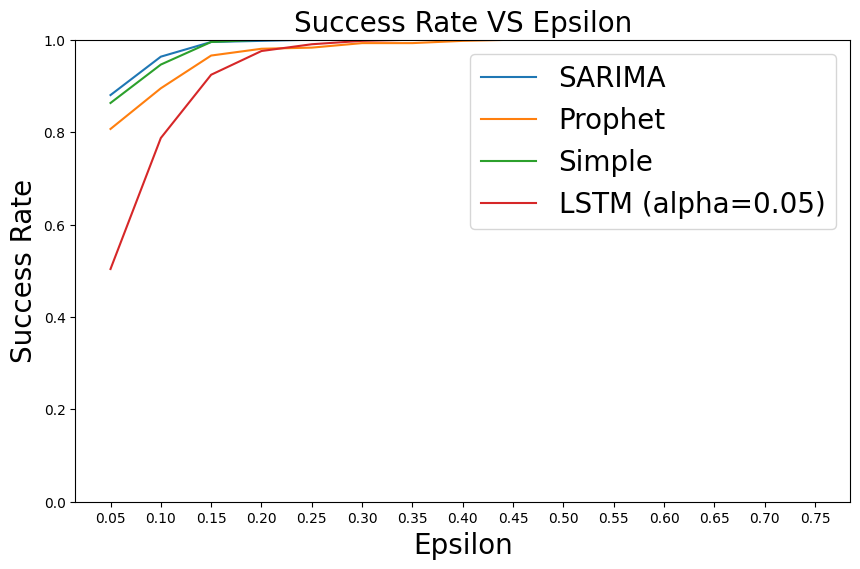

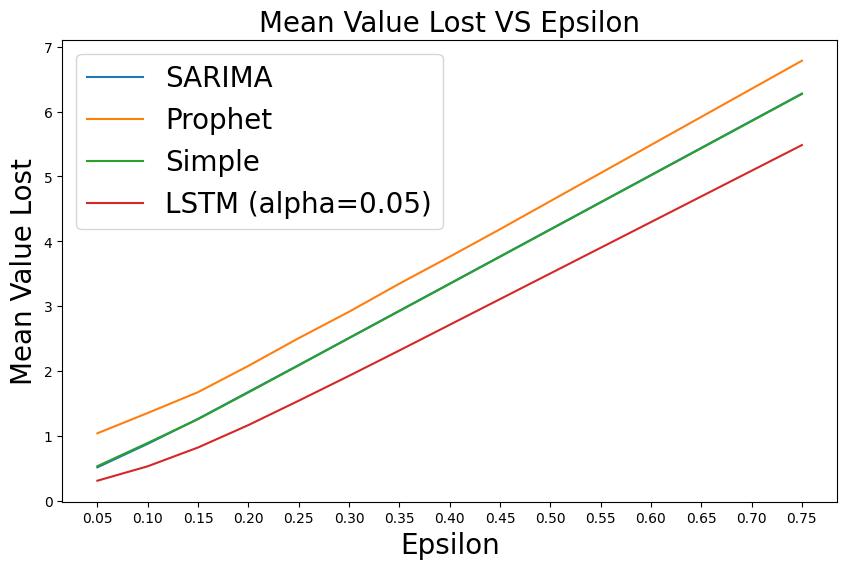

In [95]:
# plot the success rates VS epsilon
plt.figure(figsize=(10, 6))
plt.plot(epsilons, SARIMA_success_rates, label='SARIMA')
plt.plot(epsilons, Prophet_success_rates, label='Prophet')
plt.plot(epsilons, simple_success_rates, label='Simple')
plt.plot(epsilons, LSTM_success_rates, label='LSTM (alpha=0.05)')
plt.title('Success Rate VS Epsilon', fontsize=20)
plt.xlabel('Epsilon', fontsize=20)
plt.ylabel('Success Rate', fontsize=20)
plt.ylim(0, 1)
plt.xticks(epsilons)
plt.legend(fontsize=20)
plt.show()

# plot the MVL VS alpha
plt.figure(figsize=(10, 6))
plt.plot(epsilons, SARIMA_MVLs, label='SARIMA')
plt.plot(epsilons, Prophet_MVLs, label='Prophet')
plt.plot(epsilons, simple_MVLs, label='Simple')
plt.plot(epsilons, LSTM_MVLs, label='LSTM (alpha=0.05)')
plt.title('Mean Value Lost VS Epsilon', fontsize=20)
plt.xlabel('Epsilon', fontsize=20)
plt.ylabel('Mean Value Lost', fontsize=20)
plt.xticks(epsilons)
plt.legend(fontsize=20)
plt.show()